Similar to notebook [088] but using a single generator and compact syntax.

# Imports and Initialization

## Imports

In [1]:
from cbrain.climate_invariant import *
from cbrain.climate_invariant_utils import *
import pickle
#import h5netcdf
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

from cbrain.imports import *
from cbrain.utils import *
from cbrain.normalization import *

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


## Initialization

In [2]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_array = {}

In [3]:
climate_str = ['cold','hot','both']
set_str = ['train','valid','test']
test_clim_str = ['cold','hot','both','medium']

In [4]:
path_array['cold'] = [path_data+'2021_03_18_O3_TRAIN_M4K_shuffle.nc',
                      path_data+'2021_03_18_O3_VALID_M4K.nc',
                      path_data+'2021_03_18_O3_TEST_M4K.nc']
path_array['hot'] = [path_data+'2021_03_18_O3_TRAIN_P4K_shuffle.nc',
                     path_data+'2021_03_18_O3_VALID_P4K.nc',
                     path_data+'2021_03_18_O3_TEST_P4K.nc']
path_array['both'] = [path_data+'2022_04_18_TRAIN_M4K_P4K_shuffle.nc',
                      path_data+'2022_04_18_VALID_M4K_P4K.nc',
                      path_data+'2022_04_18_TEST_M4K_P4K.nc']
path_array['medium'] = [path_data+'2021_01_24_O3_TRAIN_shuffle.nc',
                        path_data+'2021_01_24_O3_VALID.nc',
                        path_data+'2021_01_24_O3_TEST.nc']

In [5]:
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
scale_dict_RH = scale_dict.copy()
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%
path_train_RH = path_data + '2021_01_24_O3_small_shuffle.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_train_BMSE = path_data + '2021_06_16_BMSE_small_shuffle.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'
path_train_LHF_nsDELQ = path_data + '2021_02_01_O3_LHF_nsQ_small_shuffle.nc'

In [6]:
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions

In [7]:
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))

In [41]:
fz = 15
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

# Data Generators

## First, define generators necessary for rescaling

In [9]:
def train_gen_rescaling(input_rescaling,path_norm,path_train,scale_dict):
    return DataGeneratorCI(
        data_fn = path_train,
        input_vars = input_rescaling,
        output_vars = out_vars,
        norm_fn = path_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict)

In [10]:
train_gen_RH = train_gen_rescaling(['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX'],
                                   path_norm_RH,path_train_RH,scale_dict_RH)
train_gen_BMSE = train_gen_rescaling(['QBP','BMSE','PS', 'SOLIN', 'SHFLX', 'LHFLX'],
                                     path_norm_BMSE,path_train_BMSE,scale_dict)
train_gen_LHF_nsDELQ = train_gen_rescaling(['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHF_nsDELQ'],
                                           path_norm_LHF_nsDELQ,path_train_LHF_nsDELQ,scale_dict)

## And generators only taking a subset of the data

### Implementation

In [11]:
class DataGeneratorCI_Small_Data(DataGenerator):
    def __init__(self, batch_list, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, 
             Qscaling=None,
             Tscaling=None,
             LHFscaling=None,
             SHFscaling=None,
             output_scaling=False,
             interpolate=False,
             hyam=None,hybm=None,
             inp_sub_Qscaling=None,inp_div_Qscaling=None,
             inp_sub_Tscaling=None,inp_div_Tscaling=None,
             inp_sub_LHFscaling=None,inp_div_LHFscaling=None,
             inp_sub_SHFscaling=None,inp_div_SHFscaling=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,epsQ=1e-3,epsT=1,
                 mode='train'):
        self.output_scaling = output_scaling
        self.interpolate = interpolate
        self.Qscaling = Qscaling
        self.Tscaling = Tscaling
        self.LHFscaling = LHFscaling
        self.SHFscaling = SHFscaling
        self.inp_shape = 64
        self.mode=mode
        self.batch_list = batch_list
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off) ## call the base data generator
        # Overwrite number of samples and number of batches
        self.n_samples = len(batch_list)*self.batch_size
        self.n_batches = int(np.floor(self.n_samples) / self.batch_size)
        ###################################################
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div
        if Qscaling=='RH':
            self.QLayer = QV2RHNumpy(self.inp_sub,self.inp_div,inp_sub_Qscaling,inp_div_Qscaling,hyam,hybm)
        elif Qscaling=='QSATdeficit':
            self.QLayer = QV2QSATdeficitNumpy(self.inp_sub,self.inp_div,inp_sub_Qscaling,inp_div_Qscaling,hyam,hybm)
        if Tscaling=='TfromNS':
            self.TLayer = T2TmTNSNumpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        elif Tscaling=='BCONS':
            self.TLayer = T2BCONSNumpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        elif Tscaling=='BMSE':
            self.TLayer = T2BMSENumpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        elif Tscaling=='T_NSto220':
            self.TLayer = T2T_NSto220Numpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        if LHFscaling=='LHF_nsDELQ':
            self.LHFLayer = LHF2LHF_nsDELQNumpy(self.inp_sub,self.inp_div,inp_sub_LHFscaling,inp_div_LHFscaling,hyam,hybm,epsQ)
        elif LHFscaling=='LHF_nsQ':
            self.LHFLayer = LHF2LHF_nsQNumpy(self.inp_sub,self.inp_div,inp_sub_LHFscaling,inp_div_LHFscaling,hyam,hybm,epsQ)
        if SHFscaling=='SHF_nsDELT':
            self.SHFLayer = SHF2SHF_nsDELTNumpy(self.inp_sub,self.inp_div,inp_sub_SHFscaling,inp_div_SHFscaling,hyam,hybm,epsT)
        if output_scaling:
            self.scalingLayer = ScalingNumpy(hyam,hybm)
            self.inp_shape += 1
        if interpolate:
            self.interpLayer = InterpolationNumpy(lev,is_continous,Tnot,lower_lim,interm_size)
            self.inp_shape += interm_size*2 + 4 + 30 ## 4 same as 60-64 and 30 for lev_tilde.size
    def __getitem__(self, index):
        # Compute start and end indices for batch
        # Modify generator behavior below to only take batches from the list
        start_idx = self.batch_list[index] * self.batch_size
        ####################################################################
        end_idx = start_idx + self.batch_size
        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]
        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        X_result = np.copy(X_norm)
        if self.Qscaling:
            X_result = self.QLayer.process(X_result)
        if self.Tscaling:
            # tgb - 3/21/2021 - BCONS needs qv in kg/kg as an input
            if self.Tscaling=='BCONS' or self.Tscaling=='BMSE':
                if self.Qscaling:
                    X_resultT = self.TLayer.process(X_norm)
                    X_result = np.concatenate([X_result[:,:30],X_resultT[:,30:60],X_result[:,60:]], axis=1)
                else:
                    X_result = self.TLayer.process(X_result)
            else:
                X_result = self.TLayer.process(X_result)
        if self.SHFscaling:
            X_result = self.SHFLayer.process(X_result)
        if self.LHFscaling:
            # tgb - 3/22/2021 - LHF_ns(DEL)Q needs qv in kg/kg and T in K
            if self.Qscaling or self.Tscaling:
                X_resultLHF = self.LHFLayer.process(X_norm)
                X_result = np.concatenate([X_result[:,:60],X_resultLHF[:,60:]],axis=1)
            else:
                X_result = self.LHFLayer.process(X_result)
        if self.output_scaling:
            scalings = self.scalingLayer.process(X)
            X_result = np.hstack((X_result,scalings))
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
        if self.mode=='val':
            return xr.DataArray(X_result), xr.DataArray(Y)
        return X_result,Y
    ##transforms the input data into the required format, take the unnormalized dataset
    def transform(self,X):
        X_norm = self.input_transform.transform(X)
        X_result = X_norm
        if self.Qscaling:
            X_result = self.QLayer.process(X_result)
        if self.Tscaling:
            X_result = self.TLayer.process(X_result)
        if self.SHFscaling:
            X_result = self.SHFLayer.process(X_result)
        if self.LHFscaling:
            X_result = self.LHFLayer.process(X_result)
        if self.scaling:
            scalings = self.scalingLayer.process(X)
            X_result = np.hstack((X_result,scalings))
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
        return X_result

In [12]:
def Generator_singleDS_smalldata(path,batch_list,batch_size,rescaling=None):
    
    in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
    out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
    path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
    scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
    
    if rescaling=='CI':
        gen = DataGeneratorCI_Small_Data(
        batch_list = batch_list,
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=batch_size,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        Qscaling = 'RH',
        Tscaling = 'BMSE',
        LHFscaling = 'LHF_nsDELQ',
        hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
        inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
        inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
        inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
        inp_div_Tscaling=train_gen_BMSE.input_transform.div,
        inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
        inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
        ) 
    else:
        gen = DataGeneratorCI_Small_Data(
        batch_list = batch_list,
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=batch_size,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict
        )

    return gen 

### Tests

In [128]:
batch_list = [50]

In [129]:
path = path_array['both'][0]
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))

gen_smalldata = DataGeneratorCI_Small_Data(
    batch_list = batch_list,
    data_fn = path,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_input_norm,
    batch_size=8192,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict
)

In [130]:
inp_test = Input(shape=(64,))
BF_model_test = NN_model(inp_test,7)
BF_model_test.compile(tf.keras.optimizers.Adam(), loss=mse)

In [131]:
path_test = path_data + '2022_04_29_BF_test.hdf5'
mcp_save = ModelCheckpoint(path_BF,save_best_only=True, monitor='loss', mode='min')

In [133]:
Nep = 100

In [134]:
BF_model_test.fit_generator(gen_smalldata,epochs=Nep,callbacks=[mcp_save])

Epoch 1/100
1/1 [==============================] - 0s 211ms/step - loss: 350.7897
Epoch 2/100
1/1 [==============================] - 0s 94ms/step - loss: 350.7195
Epoch 3/100
1/1 [==============================] - 0s 132ms/step - loss: 350.6418
Epoch 4/100
1/1 [==============================] - 0s 149ms/step - loss: 350.5347
Epoch 5/100
1/1 [==============================] - 0s 115ms/step - loss: 350.3830
Epoch 6/100
1/1 [==============================] - 0s 119ms/step - loss: 350.1694
Epoch 7/100
1/1 [==============================] - 0s 121ms/step - loss: 349.8742
Epoch 8/100
1/1 [==============================] - 0s 119ms/step - loss: 349.4729
Epoch 9/100
1/1 [==============================] - 0s 105ms/step - loss: 348.9348
Epoch 10/100
1/1 [==============================] - 0s 155ms/step - loss: 348.2247
Epoch 11/100
1/1 [==============================] - 0s 122ms/step - loss: 347.3086
Epoch 12/100
1/1 [==============================] - 0s 121ms/step - loss: 346.1619
Epoch 13/100
1

Epoch 100/100
1/1 [==============================] - 0s 159ms/step - loss: 251.9475


In [135]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFg = BFgen[clim][st]
    print(BF_model_test.evaluate_generator(BFg))

Climate =  cold
263.6350256133955
Climate =  hot
5811.602417221526
Climate =  both


KeyboardInterrupt: 

In [139]:
BFg.n_batches*8

93680

In [140]:
Nbatches = 8
b_random = np.random.choice(np.linspace(0,93680-1,93680),
                            size=((Nbatches,)),replace=False).astype('int')

In [141]:
b_random

array([65911, 88562, 45443, 20034,  1166, 79654, 83656, 66219])

In [142]:
gen_smalldata2 = DataGeneratorCI_Small_Data(
    batch_list = b_random,
    data_fn = path,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_input_norm,
    batch_size=1024,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict
)

In [147]:
inp_test = Input(shape=(64,))
BF_model_test2 = NN_model(inp_test,7)
BF_model_test2.compile(tf.keras.optimizers.Adam(), loss=mse)

path_test = path_data + '2022_04_29_BF_test2.hdf5'
mcp_save = ModelCheckpoint(path_BF,save_best_only=True, monitor='loss', mode='min')

Nep = 100

In [148]:
BF_model_test2.fit_generator(gen_smalldata2,epochs=Nep,callbacks=[mcp_save])

Epoch 1/100
8/8 [==============================] - 1s 98ms/step - loss: 556.2559
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 550.4319
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 542.6850
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 536.0072
Epoch 5/100
8/8 [==============================] - 0s 35ms/step - loss: 529.3535
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 515.4975
Epoch 7/100
8/8 [==============================] - 0s 32ms/step - loss: 498.6044
Epoch 8/100
8/8 [==============================] - 0s 32ms/step - loss: 480.2223
Epoch 9/100
8/8 [==============================] - 0s 36ms/step - loss: 467.2653
Epoch 10/100
8/8 [==============================] - 0s 29ms/step - loss: 451.8593
Epoch 11/100
8/8 [==============================] - 0s 31ms/step - loss: 439.5424
Epoch 12/100
8/8 [==============================] - 0s 31ms/step - loss: 433.4987
Epoch 13/100
8/8 [=======

In [149]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFg = BFgen[clim][st]
    print(BF_model_test2.evaluate_generator(BFg))

Climate =  cold
254.45303347072064
Climate =  hot
514.8951948600788
Climate =  both


KeyboardInterrupt: 

## Then, generate structure containing all data generators

In [13]:
def Generator_singleDS(path,rescaling=None):
    
    in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
    out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
    path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
    scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
    
    if rescaling=='CI':
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=8192,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        Qscaling = 'RH',
        Tscaling = 'BMSE',
        LHFscaling = 'LHF_nsDELQ',
        hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
        inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
        inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
        inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
        inp_div_Tscaling=train_gen_BMSE.input_transform.div,
        inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
        inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
        ) 
    else:
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=8192,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict
        )

    return gen 

In [14]:
BFgen = {}
CIgen = {}

In [15]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFgen[clim] = {}
    CIgen[clim] = {}
    
    for iset,st in enumerate(set_str):
        print('Set = ',st)
        
        BFgen[clim][st] = Generator_singleDS(path_array[clim][iset])
        CIgen[clim][st] = Generator_singleDS(path_array[clim][iset],rescaling='CI')

Climate =  cold
Set =  train
Set =  valid
Set =  test
Climate =  hot
Set =  train
Set =  valid
Set =  test
Climate =  both
Set =  train
Set =  valid
Set =  test
Climate =  medium
Set =  train
Set =  valid
Set =  test


# Models

In [26]:
N_layer_max = 10

In [27]:
def NN_model(inp,N_layer):
    if N_layer>0:
        densout = Dense(128, activation='linear')(inp)
        densout = LeakyReLU(alpha=0.3)(densout)
    else: dense_out = Dense(120, activation='linear')(inp)
    for i in range (N_layer-1):
        densout = Dense(128, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    if N_layer>0: dense_out = Dense(120, activation='linear')(densout)
    return tf.keras.models.Model(inp, dense_out)

In [21]:
BF_models = {}
CI_models = {}
inp_BF = {}
inp_CI = {}

In [22]:
for ilayer in range(N_layer_max):
    
    print(ilayer)
    
    inp_BF[ilayer] = Input(shape=(64,))
    BF_models[ilayer] = NN_model(inp_BF[ilayer],ilayer)
    
    inp_CI[ilayer] = Input(shape=(64,))
    CI_models[ilayer] = NN_model(inp_CI[ilayer],ilayer)

0
1
2
3
4
5
6
7
8
9


In [23]:
for ilayer in range(N_layer_max):
    
    print(ilayer)
    
    BF_models[ilayer].compile(tf.keras.optimizers.Adam(), loss=mse)
    CI_models[ilayer].compile(tf.keras.optimizers.Adam(), loss=mse)

0
1
2
3
4
5
6
7
8
9


# Callbacks

In [16]:
class AdditionalValidationSets(Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            valid_generator,valid_name = validation_set
            results = self.model.evaluate_generator(generator=valid_generator)

            for metric, result in zip(self.model.metrics_names,[results]):
                valuename = valid_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

In [17]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

# Training on both datasets at once

In [18]:
Nep = 20

In [19]:
history_BF = {}
history_CI = {}

In [ ]:
# for ilayer in range(N_layer_max):
    
#     print('Number of layers = ',ilayer)
    
#     path_BF = path_data + '2022_04_18_BF_'+str(ilayer)+'.hdf5'
#     mcp_save = ModelCheckpoint(path_BF,save_best_only=True, monitor='val_loss', mode='min')
#     history_BF[ilayer] = BF_models[ilayer].fit_generator(BFgen['both']['train'],epochs=Nep, 
#                                                          validation_data = BFgen['both']['valid'],
#                                                          callbacks=[mcp_save,earlyStopping])
    
#     path_CI = path_data + '2022_04_18_CI_'+str(ilayer)+'.hdf5'
#     mcp_save = ModelCheckpoint(path_CI,save_best_only=True, monitor='val_loss', mode='min')
#     history_CI[ilayer] = CI_models[ilayer].fit_generator(CIgen['both']['train'],epochs=Nep, 
#                                                          validation_data = CIgen['both']['valid'],
#                                                          callbacks=[mcp_save,earlyStopping])

Number of layers =  0
Epoch 1/20
11518/11518 [==============================] - 1699s 148ms/step - loss: 532.8220 - val_loss: 508.1970
Epoch 2/20
11518/11518 [==============================] - 1405s 122ms/step - loss: 497.6583 - val_loss: 491.8008
Epoch 3/20
11518/11518 [==============================] - 1235s 107ms/step - loss: 487.9458 - val_loss: 486.2537
Epoch 4/20
11518/11518 [==============================] - 1138s 99ms/step - loss: 483.6714 - val_loss: 483.0439
Epoch 5/20
11518/11518 [==============================] - 1164s 101ms/step - loss: 480.9029 - val_loss: 480.7858
Epoch 6/20
11518/11518 [==============================] - 1165s 101ms/step - loss: 478.8252 - val_loss: 478.9353
Epoch 7/20
11518/11518 [==============================] - 1168s 101ms/step - loss: 477.1709 - val_loss: 477.4486
Epoch 8/20
11518/11518 [==============================] - 1180s 102ms/step - loss: 475.8026 - val_loss: 476.1914
Epoch 9/20
11518/11518 [==============================] - 1167s 101ms/step 

11518/11518 [==============================] - 3611s 314ms/step - loss: 319.0007 - val_loss: 315.0795
Epoch 4/20
11518/11518 [==============================] - 3436s 298ms/step - loss: 315.5783 - val_loss: 314.1190
Epoch 5/20
11518/11518 [==============================] - 3325s 289ms/step - loss: 313.2988 - val_loss: 312.3706
Epoch 6/20
11518/11518 [==============================] - 3673s 319ms/step - loss: 311.5310 - val_loss: 314.6943
Epoch 7/20
11518/11518 [==============================] - 3640s 316ms/step - loss: 310.3065 - val_loss: 309.9275
Epoch 8/20
11518/11518 [==============================] - 3478s 302ms/step - loss: 309.1930 - val_loss: 310.4048
Epoch 9/20
11518/11518 [==============================] - 3466s 301ms/step - loss: 308.4340 - val_loss: 309.9851
Epoch 10/20
11518/11518 [==============================] - 3539s 307ms/step - loss: 307.6717 - val_loss: 309.0291
Epoch 11/20
11518/11518 [==============================] - 3447s 299ms/step - loss: 306.9067 - val_loss: 3

Epoch 15/20
11518/11518 [==============================] - 1295s 112ms/step - loss: 273.9346 - val_loss: 271.1808
Epoch 16/20
11518/11518 [==============================] - 1362s 118ms/step - loss: 273.3642 - val_loss: 272.8865
Epoch 17/20
11518/11518 [==============================] - 1314s 114ms/step - loss: 272.5575 - val_loss: 273.8937
Epoch 18/20
11518/11518 [==============================] - 1330s 115ms/step - loss: 272.1737 - val_loss: 271.7586
Epoch 19/20
11518/11518 [==============================] - 1206s 105ms/step - loss: 271.9611 - val_loss: 273.8706
Epoch 20/20
11518/11518 [==============================] - 1235s 107ms/step - loss: 271.3848 - val_loss: 280.1861
Epoch 1/20
11518/11518 [==============================] - 3342s 290ms/step - loss: 344.7718 - val_loss: 327.7889
Epoch 2/20
11518/11518 [==============================] - 5110s 444ms/step - loss: 321.1192 - val_loss: 325.6891
Epoch 3/20
11518/11518 [==============================] - 3460s 300ms/step - loss: 314.430

In [ ]:
path_history = path_data + 'PKL_DATA/2022_04_18_Train_Both_Datasets'

In [ ]:
# pickle.dump({'history_BF':history_BF,'history_CI':history_CI},
#             open(path_history,'wb'))

# Evaluate in each climate separately

## Load performance during training

In [22]:
path_history = path_data + 'PKL_DATA/2022_04_18_Train_Both_Datasets'

In [23]:
Training_Perf = pickle.load(open(path_history,'rb'))

In [24]:
Training_Perf

{'history_BF': {}, 'history_CI': {}}

Looks like the history was not saved because the notebook was stopped prematurely

## Calculate performance on test dataset of each climate

In [117]:
st = 'test'

In [118]:
BFtest = {}; CItest = {}

In [127]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFtest[clim] = {}; CItest[clim] = {}
    
    BFg = BFgen[clim][st]; CIg = CIgen[clim][st]
    
    for ilayer in range(N_layer_max-1):
    
        print(ilayer)
        path_BF = path_data + '2022_04_18_BF_'+str(ilayer)+'.hdf5'
        path_CI = path_data + '2022_04_18_CI_'+str(ilayer)+'.hdf5'
        BFNN = tf.keras.models.load_model(path_BF)
        CINN = tf.keras.models.load_model(path_CI)
    
#         BFtest[clim][ilayer] = BFNN.evaluate_generator(BFg)
#         CItest[clim][ilayer] = CINN.evaluate_generator(CIg)

Climate =  cold
0
1
2
3
4
5
6
7
8
Climate =  hot
0
1
2
3
4
5
6
7
8
Climate =  both
0
1
2
3
4
5
6
7
8
Climate =  medium
0
1
2
3
4
5
6
7
8


In [121]:
path_test = path_data + 'PKL_DATA/2022_04_18_Performance_Four_Climates'

In [44]:
# pickle.dump({'BFtest':BFtest,'CItest':CItest},
#             open(path_test,'wb'))

## Plots

In [122]:
path_test = path_data + 'PKL_DATA/2022_04_18_Performance_Four_Climates'
Performance = pickle.load(open(path_test,'rb'))

In [123]:
BFtest = Performance['BFtest']
CItest = Performance['CItest']

In [124]:
for key in BFtest.keys():
    BFtest[key]['plot'] = np.zeros((8,))
    CItest[key]['plot'] = np.zeros((8,))
    for i in range(8):
        BFtest[key]['plot'][i] = BFtest[key][i]
        CItest[key]['plot'][i] = CItest[key][i]

In [125]:
color_array = ['blue','red','black','gray']

Text(0, 0.5, 'Mean-squared error')

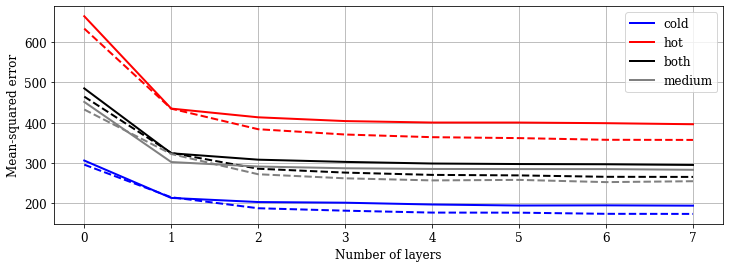

In [126]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    plt.plot(CItest[key]['plot'],label=key,color=color_array[ikey])
    plt.plot(BFtest[key]['plot'],linestyle='--',color=color_array[ikey])
    ikey += 1
    
plt.legend()
plt.grid()
plt.xlabel('Number of layers')
plt.ylabel('Mean-squared error')

# Small data experiments

## Overall parameters

In [20]:
N_batch = 8 # Number of batches for each experiment
Nep = 100
N_NN = 10 # Number of NN trained per experiment
N_layer = 7 # Number of layers for the NNs
batch_size_array = 2**np.arange(0,14) # Batch sizes we will consider in these experiments
N_samples = BFgen['both']['train'].n_samples # Total number of samples in the dataset
ptrain = path_array['both'][0]

## Design generators

In [21]:
BFgenSD = {}
CIgenSD = {}

In [22]:
for isize,batch_size in enumerate(batch_size_array):
    BFgenSD[batch_size] = {}
    CIgenSD[batch_size] = {}
    N_batch_max = int(N_samples/batch_size)
    print('batch_size=',batch_size,'& N_batch_max=',N_batch_max)
    
    for iexp in range(N_NN):
        BFgenSD[batch_size][iexp] = {}
        CIgenSD[batch_size][iexp] = {}
        # Randomly select 8 batches
        b_random = np.random.choice(np.linspace(0,N_batch_max-1,N_batch_max),
                                    size=((N_batch,)),
                                    replace=False).astype('int')
        print('Exp#',str(iexp),'b_random=',b_random)
        
        BFgenSD[batch_size][iexp]['train'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[0:4],batch_size=batch_size,rescaling=None)
        BFgenSD[batch_size][iexp]['valid'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[4:],batch_size=batch_size,rescaling=None)
        
        CIgenSD[batch_size][iexp]['train'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[0:4],batch_size=batch_size,rescaling='CI')
        CIgenSD[batch_size][iexp]['valid'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[4:],batch_size=batch_size,rescaling='CI')

batch_size= 1 & N_batch_max= 94355456
Exp# 0 b_random= [60801227 41494347 34939643 81425233 18221766 58015923 41213042 33352564]
Exp# 1 b_random= [62434638 61219185 74747568 91136293 78371521 83540194 67679753 53677988]
Exp# 2 b_random= [ 3012347 79959850 30672198 93585540  5104430 73488077 92908367 55385991]
Exp# 3 b_random= [49415369 40797164 22720366 59541881  4545420 67070868 52023242 64034363]
Exp# 4 b_random= [ 3133037 83811583 22787986 90019381 89615078 93194372 63461950 91062707]
Exp# 5 b_random= [41513738 23841721 34118260 73471016 71672288 63972516 75124087 67580360]
Exp# 6 b_random= [64461894 14154816 90987772 15268032 47060280  3327401 66650053 43575174]
Exp# 7 b_random= [28729879 68158281 22494140  1707217 17398685 20964960 41936839 86743278]
Exp# 8 b_random= [93827368 64235141 26103619 36238385 37950274  1257149 90813978 75236919]
Exp# 9 b_random= [47987885 71628033 12504742 48225853 11733327 12761023 57321521 21605887]
batch_size= 2 & N_batch_max= 47177728
Exp# 0 b_rando

Exp# 3 b_random= [169992 179407 104233 154755 155996 131693  98805   8787]
Exp# 4 b_random= [ 54017   1918  18507  72532 155412 123459  29844  36445]
Exp# 5 b_random= [ 99550   2170 175313  25882  49150  64346  52466  73975]
Exp# 6 b_random= [ 84746 122909 126272   2785  58510 127017  31719  36058]
Exp# 7 b_random= [ 25057  93645  54151  74557 184255  75325 105439 150804]
Exp# 8 b_random= [150514   4333 148903 171524  90089  17956  22910  77687]
Exp# 9 b_random= [ 64859 165795 144401   6354 131103 111942   1874  95540]
batch_size= 1024 & N_batch_max= 92144
Exp# 0 b_random= [14289 32199 48445 67216 61256 74621 28402 58072]
Exp# 1 b_random= [29909 88974 68834 34690 47567   959 14233 35635]
Exp# 2 b_random= [91872 68692 21959 32379 35536 52712 60814  4101]
Exp# 3 b_random= [48474 61894 29540 73000 75264 32065 63579 31564]
Exp# 4 b_random= [ 1831 82811 39769 30863 63206 45728 33005 10979]
Exp# 5 b_random= [33245 69718 61153 64878 89582 36485 62140 10216]
Exp# 6 b_random= [30342 80473 79131

## Train models

In [23]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')

In [24]:
# Inputs
inpBFSD = {}
inpCISD = {}
# Model
NNBFSD = {}
NNCISD = {}
# History
hisBF = {}
hisCI = {}

In [28]:
for isize,batch_size in enumerate(batch_size_array):
    inpBFSD[batch_size] = {}
    inpCISD[batch_size] = {}
    NNBFSD[batch_size] = {}
    NNCISD[batch_size] = {}
    hisBF[batch_size] = {}
    hisCI[batch_size] = {}
    for iexp in range(N_NN):
        print('batch_size=',batch_size,'& iexp=',iexp)
        # Model definition
        inpBFSD[batch_size][iexp] = Input(shape=(64,))
        inpCISD[batch_size][iexp] = Input(shape=(64,))
        NNBFSD[batch_size][iexp] = NN_model(inpBFSD[batch_size][iexp],N_layer)
        NNCISD[batch_size][iexp] = NN_model(inpCISD[batch_size][iexp],N_layer)
        NNBFSD[batch_size][iexp].compile(tf.keras.optimizers.Adam(), loss=mse)
        NNCISD[batch_size][iexp].compile(tf.keras.optimizers.Adam(), loss=mse)
        # Model callbacks
        path_BF = path_data + 'HDF5_DATA/2022_07_12_BF_'+str(batch_size)+'_'+str(iexp)+'.hdf5'
        path_CI = path_data + 'HDF5_DATA/2022_07_12_CI_'+str(batch_size)+'_'+str(iexp)+'.hdf5'
        mcp_BF = ModelCheckpoint(path_BF,save_best_only=True, monitor='val_loss', mode='min')
        mcp_CI = ModelCheckpoint(path_CI,save_best_only=True, monitor='val_loss', mode='min')
        # Model training
#         hisBF[batch_size][iexp] = NNBFSD[batch_size][iexp].fit_generator(
#             BFgenSD[batch_size][iexp]['train'],epochs=Nep,
#             validation_data = BFgenSD[batch_size][iexp]['valid'],
#             callbacks=[mcp_BF,earlyStopping])
        hisCI[batch_size][iexp] = NNCISD[batch_size][iexp].fit_generator(
            CIgenSD[batch_size][iexp]['train'],epochs=Nep,
            validation_data = CIgenSD[batch_size][iexp]['valid'],
            callbacks=[mcp_CI,earlyStopping])

batch_size= 1 & iexp= 0
Epoch 1/100
4/4 [==============================] - 1s 152ms/step - loss: 133.2678 - val_loss: 65.5621
Epoch 2/100
4/4 [==============================] - 0s 59ms/step - loss: 132.9428 - val_loss: 65.3040
Epoch 3/100
4/4 [==============================] - 0s 63ms/step - loss: 131.9760 - val_loss: 64.5985
Epoch 4/100
4/4 [==============================] - 0s 60ms/step - loss: 129.9988 - val_loss: 62.7220
Epoch 5/100
4/4 [==============================] - 0s 59ms/step - loss: 125.2816 - val_loss: 58.2584
Epoch 6/100
4/4 [==============================] - 0s 64ms/step - loss: 110.6351 - val_loss: 52.1904
Epoch 7/100
4/4 [==============================] - 0s 45ms/step - loss: 97.3022 - val_loss: 55.7681
Epoch 8/100
4/4 [==============================] - 0s 45ms/step - loss: 92.8638 - val_loss: 53.2160
Epoch 9/100
4/4 [==============================] - 0s 60ms/step - loss: 76.8204 - val_loss: 49.0554
Epoch 10/100
4/4 [==============================] - 0s 45ms/step - lo

4/4 [==============================] - 0s 68ms/step - loss: 535.4321 - val_loss: 910.7723
Epoch 3/100
4/4 [==============================] - 0s 63ms/step - loss: 533.8978 - val_loss: 909.7365
Epoch 4/100
4/4 [==============================] - 0s 64ms/step - loss: 530.9496 - val_loss: 907.2588
Epoch 5/100
4/4 [==============================] - 0s 63ms/step - loss: 525.1820 - val_loss: 901.6050
Epoch 6/100
4/4 [==============================] - 0s 67ms/step - loss: 508.5455 - val_loss: 890.8993
Epoch 7/100
4/4 [==============================] - 0s 63ms/step - loss: 447.3682 - val_loss: 876.7251
Epoch 8/100
4/4 [==============================] - 0s 62ms/step - loss: 371.9962 - val_loss: 861.6144
Epoch 9/100
4/4 [==============================] - 0s 46ms/step - loss: 318.0188 - val_loss: 895.6867
Epoch 10/100
4/4 [==============================] - 0s 46ms/step - loss: 317.7414 - val_loss: 889.7701
Epoch 11/100
4/4 [==============================] - 0s 64ms/step - loss: 225.2510 - val_loss:

4/4 [==============================] - 0s 44ms/step - loss: 13.7690 - val_loss: 112.8544
Epoch 38/100
4/4 [==============================] - 0s 49ms/step - loss: 18.4587 - val_loss: 112.8275
Epoch 39/100
4/4 [==============================] - 0s 49ms/step - loss: 9.9475 - val_loss: 112.3363
Epoch 40/100
4/4 [==============================] - 0s 50ms/step - loss: 11.2610 - val_loss: 111.8577
Epoch 41/100
4/4 [==============================] - 0s 50ms/step - loss: 9.9612 - val_loss: 112.7702
Epoch 42/100
4/4 [==============================] - 0s 48ms/step - loss: 8.5854 - val_loss: 113.2562
Epoch 43/100
4/4 [==============================] - 0s 50ms/step - loss: 9.2961 - val_loss: 112.8609
Epoch 44/100
4/4 [==============================] - 0s 46ms/step - loss: 8.4568 - val_loss: 111.7424
Epoch 45/100
4/4 [==============================] - 0s 45ms/step - loss: 8.4171 - val_loss: 112.1306
Epoch 46/100
4/4 [==============================] - 0s 45ms/step - loss: 8.0622 - val_loss: 112.1195


4/4 [==============================] - 0s 45ms/step - loss: 39.6306 - val_loss: 60.5432
Epoch 11/100
4/4 [==============================] - 0s 44ms/step - loss: 37.9835 - val_loss: 61.6857
Epoch 12/100
4/4 [==============================] - 0s 44ms/step - loss: 37.8529 - val_loss: 63.5871
Epoch 13/100
4/4 [==============================] - 0s 50ms/step - loss: 33.9030 - val_loss: 61.8909
Epoch 14/100
4/4 [==============================] - 0s 51ms/step - loss: 31.7472 - val_loss: 63.1717
Epoch 15/100
4/4 [==============================] - 0s 47ms/step - loss: 27.6967 - val_loss: 66.6268
Epoch 16/100
4/4 [==============================] - 0s 50ms/step - loss: 27.1758 - val_loss: 70.6358
Epoch 17/100
4/4 [==============================] - 0s 53ms/step - loss: 23.2321 - val_loss: 69.5092
Epoch 18/100
4/4 [==============================] - 0s 49ms/step - loss: 22.8591 - val_loss: 71.1000
Epoch 19/100
4/4 [==============================] - 0s 50ms/step - loss: 19.9577 - val_loss: 74.3121
Epo

Epoch 92/100
4/4 [==============================] - 0s 45ms/step - loss: 0.1263 - val_loss: 59.0441
Epoch 93/100
4/4 [==============================] - 0s 44ms/step - loss: 0.1016 - val_loss: 58.5758
Epoch 94/100
4/4 [==============================] - 0s 44ms/step - loss: 0.0404 - val_loss: 58.6640
Epoch 95/100
4/4 [==============================] - 0s 45ms/step - loss: 0.1551 - val_loss: 58.6887
Epoch 96/100
4/4 [==============================] - 0s 44ms/step - loss: 0.1977 - val_loss: 58.3414
Epoch 97/100
4/4 [==============================] - 0s 44ms/step - loss: 0.0473 - val_loss: 59.2080
Epoch 98/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0889 - val_loss: 59.0266
Epoch 99/100
4/4 [==============================] - 0s 48ms/step - loss: 0.0464 - val_loss: 58.0740
Epoch 100/100
4/4 [==============================] - 0s 48ms/step - loss: 0.1618 - val_loss: 58.6750
batch_size= 1 & iexp= 8
Epoch 1/100
4/4 [==============================] - 0s 89ms/step - loss: 138

4/4 [==============================] - 0s 47ms/step - loss: 5.4068 - val_loss: 327.4503
Epoch 40/100
4/4 [==============================] - 0s 46ms/step - loss: 5.2776 - val_loss: 329.0703
Epoch 41/100
4/4 [==============================] - 0s 45ms/step - loss: 5.3507 - val_loss: 328.9059
Epoch 42/100
4/4 [==============================] - 0s 47ms/step - loss: 4.7728 - val_loss: 326.0209
Epoch 43/100
4/4 [==============================] - 0s 45ms/step - loss: 4.8117 - val_loss: 327.9746
Epoch 44/100
4/4 [==============================] - 0s 45ms/step - loss: 4.5027 - val_loss: 328.0271
Epoch 45/100
4/4 [==============================] - 0s 46ms/step - loss: 4.3534 - val_loss: 328.9289
Epoch 46/100
4/4 [==============================] - 0s 46ms/step - loss: 4.1288 - val_loss: 328.3068
Epoch 47/100
4/4 [==============================] - 0s 51ms/step - loss: 4.3554 - val_loss: 327.8277
Epoch 48/100
4/4 [==============================] - 0s 50ms/step - loss: 4.1673 - val_loss: 328.4779
Epo

4/4 [==============================] - 0s 61ms/step - loss: 296.0206 - val_loss: 113.3418
Epoch 3/100
4/4 [==============================] - 0s 62ms/step - loss: 295.5001 - val_loss: 113.0589
Epoch 4/100
4/4 [==============================] - 0s 61ms/step - loss: 294.0539 - val_loss: 112.2108
Epoch 5/100
4/4 [==============================] - 0s 62ms/step - loss: 289.4265 - val_loss: 110.2726
Epoch 6/100
4/4 [==============================] - 0s 67ms/step - loss: 279.5474 - val_loss: 107.5673
Epoch 7/100
4/4 [==============================] - 0s 48ms/step - loss: 264.5036 - val_loss: 111.5040
Epoch 8/100
4/4 [==============================] - 0s 47ms/step - loss: 253.6522 - val_loss: 112.7153
Epoch 9/100
4/4 [==============================] - 0s 48ms/step - loss: 234.5292 - val_loss: 111.0944
Epoch 10/100
4/4 [==============================] - 0s 45ms/step - loss: 225.2341 - val_loss: 114.5474
Epoch 11/100
4/4 [==============================] - 0s 51ms/step - loss: 211.0178 - val_loss:

Epoch 82/100
4/4 [==============================] - 0s 45ms/step - loss: 44.0298 - val_loss: 209.2024
Epoch 83/100
4/4 [==============================] - 0s 47ms/step - loss: 30.5202 - val_loss: 190.0314
Epoch 84/100
4/4 [==============================] - 0s 46ms/step - loss: 25.8326 - val_loss: 208.4524
Epoch 85/100
4/4 [==============================] - 0s 51ms/step - loss: 30.3576 - val_loss: 189.9151
batch_size= 2 & iexp= 3
Epoch 1/100
4/4 [==============================] - 1s 125ms/step - loss: 102.1498 - val_loss: 436.7299
Epoch 2/100
4/4 [==============================] - 0s 63ms/step - loss: 101.6224 - val_loss: 436.0806
Epoch 3/100
4/4 [==============================] - 0s 63ms/step - loss: 100.0907 - val_loss: 434.3108
Epoch 4/100
4/4 [==============================] - 0s 61ms/step - loss: 96.2451 - val_loss: 431.0141
Epoch 5/100
4/4 [==============================] - 0s 61ms/step - loss: 89.8136 - val_loss: 430.7145
Epoch 6/100
4/4 [==============================] - 0s 65ms/

4/4 [==============================] - 0s 46ms/step - loss: 75.2744 - val_loss: 155.3000
Epoch 15/100
4/4 [==============================] - 0s 46ms/step - loss: 55.3232 - val_loss: 139.7469
Epoch 16/100
4/4 [==============================] - 0s 46ms/step - loss: 40.7509 - val_loss: 161.1100
Epoch 17/100
4/4 [==============================] - 0s 51ms/step - loss: 33.1158 - val_loss: 184.3782
Epoch 18/100
4/4 [==============================] - 0s 48ms/step - loss: 33.2498 - val_loss: 167.4472
Epoch 19/100
4/4 [==============================] - 0s 46ms/step - loss: 25.9002 - val_loss: 140.0210
Epoch 20/100
4/4 [==============================] - 0s 45ms/step - loss: 40.7658 - val_loss: 142.0473
Epoch 21/100
4/4 [==============================] - 0s 45ms/step - loss: 23.6500 - val_loss: 203.5300
Epoch 22/100
4/4 [==============================] - 0s 44ms/step - loss: 24.9919 - val_loss: 180.1202
Epoch 23/100
4/4 [==============================] - 0s 45ms/step - loss: 21.4785 - val_loss: 16

Epoch 3/100
4/4 [==============================] - 0s 65ms/step - loss: 107.2121 - val_loss: 285.1816
Epoch 4/100
4/4 [==============================] - 0s 61ms/step - loss: 104.7630 - val_loss: 284.5013
Epoch 5/100
4/4 [==============================] - 0s 61ms/step - loss: 100.4953 - val_loss: 283.9333
Epoch 6/100
4/4 [==============================] - 0s 50ms/step - loss: 92.7308 - val_loss: 285.5658
Epoch 7/100
4/4 [==============================] - 0s 50ms/step - loss: 91.3903 - val_loss: 285.4674
Epoch 8/100
4/4 [==============================] - 0s 67ms/step - loss: 82.8049 - val_loss: 283.3969
Epoch 9/100
4/4 [==============================] - 0s 46ms/step - loss: 77.8411 - val_loss: 287.3037
Epoch 10/100
4/4 [==============================] - 0s 45ms/step - loss: 73.2562 - val_loss: 295.4119
Epoch 11/100
4/4 [==============================] - 0s 45ms/step - loss: 69.3931 - val_loss: 299.8994
Epoch 12/100
4/4 [==============================] - 0s 47ms/step - loss: 64.3593 - val

4/4 [==============================] - 0s 44ms/step - loss: 21.3010 - val_loss: 377.1098
Epoch 48/100
4/4 [==============================] - 0s 45ms/step - loss: 20.3063 - val_loss: 375.6164
Epoch 49/100
4/4 [==============================] - 0s 44ms/step - loss: 20.5240 - val_loss: 375.7784
Epoch 50/100
4/4 [==============================] - 0s 49ms/step - loss: 19.3804 - val_loss: 375.9402
Epoch 51/100
4/4 [==============================] - 0s 52ms/step - loss: 20.1833 - val_loss: 378.5356
Epoch 52/100
4/4 [==============================] - 0s 49ms/step - loss: 18.8584 - val_loss: 378.9563
Epoch 53/100
4/4 [==============================] - 0s 49ms/step - loss: 20.4197 - val_loss: 377.4488
Epoch 54/100
4/4 [==============================] - 0s 45ms/step - loss: 18.3229 - val_loss: 376.5442
Epoch 55/100
4/4 [==============================] - 0s 44ms/step - loss: 21.2835 - val_loss: 379.0140
Epoch 56/100
4/4 [==============================] - 0s 44ms/step - loss: 17.8316 - val_loss: 37

Epoch 31/100
4/4 [==============================] - 0s 50ms/step - loss: 70.7249 - val_loss: 444.4379
Epoch 32/100
4/4 [==============================] - 0s 50ms/step - loss: 68.2441 - val_loss: 491.5191
Epoch 33/100
4/4 [==============================] - 0s 50ms/step - loss: 68.2067 - val_loss: 469.0386
Epoch 34/100
4/4 [==============================] - 0s 49ms/step - loss: 65.3093 - val_loss: 435.6335
Epoch 35/100
4/4 [==============================] - 0s 50ms/step - loss: 64.0673 - val_loss: 457.4220
Epoch 36/100
4/4 [==============================] - 0s 49ms/step - loss: 62.3678 - val_loss: 493.5171
Epoch 37/100
4/4 [==============================] - 0s 45ms/step - loss: 61.3262 - val_loss: 488.1218
Epoch 38/100
4/4 [==============================] - 0s 45ms/step - loss: 59.9641 - val_loss: 466.1002
Epoch 39/100
4/4 [==============================] - 0s 46ms/step - loss: 58.3571 - val_loss: 475.3234
Epoch 40/100
4/4 [==============================] - 0s 46ms/step - loss: 57.4175 -

4/4 [==============================] - 0s 49ms/step - loss: 919.0802 - val_loss: 278.0109
Epoch 11/100
4/4 [==============================] - 0s 45ms/step - loss: 877.9342 - val_loss: 379.3404
Epoch 12/100
4/4 [==============================] - 0s 45ms/step - loss: 760.2554 - val_loss: 433.1817
Epoch 13/100
4/4 [==============================] - 0s 46ms/step - loss: 655.7346 - val_loss: 617.8775
Epoch 14/100
4/4 [==============================] - 0s 46ms/step - loss: 548.9960 - val_loss: 890.5027
Epoch 15/100
4/4 [==============================] - 0s 49ms/step - loss: 485.2294 - val_loss: 1249.1688
Epoch 16/100
4/4 [==============================] - 0s 50ms/step - loss: 487.4060 - val_loss: 1603.9764
Epoch 17/100
4/4 [==============================] - 0s 50ms/step - loss: 345.8034 - val_loss: 1013.4886
Epoch 18/100
4/4 [==============================] - 0s 50ms/step - loss: 347.6825 - val_loss: 600.4508
Epoch 19/100
4/4 [==============================] - 0s 48ms/step - loss: 300.9279 -

Epoch 58/100
4/4 [==============================] - 0s 47ms/step - loss: 68.8071 - val_loss: 244.2726
Epoch 59/100
4/4 [==============================] - 0s 47ms/step - loss: 66.7786 - val_loss: 242.3347
Epoch 60/100
4/4 [==============================] - 0s 47ms/step - loss: 64.8751 - val_loss: 237.1686
Epoch 61/100
4/4 [==============================] - 0s 53ms/step - loss: 63.4351 - val_loss: 238.3081
Epoch 62/100
4/4 [==============================] - 0s 47ms/step - loss: 62.7602 - val_loss: 245.7471
Epoch 63/100
4/4 [==============================] - 0s 52ms/step - loss: 61.6755 - val_loss: 239.8478
Epoch 64/100
4/4 [==============================] - 0s 50ms/step - loss: 59.9857 - val_loss: 236.8958
Epoch 65/100
4/4 [==============================] - 0s 50ms/step - loss: 58.9773 - val_loss: 239.2848
batch_size= 4 & iexp= 8
Epoch 1/100
4/4 [==============================] - 0s 94ms/step - loss: 1284.9538 - val_loss: 239.3676
Epoch 2/100
4/4 [==============================] - 0s 60m

Epoch 39/100
4/4 [==============================] - 0s 52ms/step - loss: 69.5814 - val_loss: 364.1253
Epoch 40/100
4/4 [==============================] - 0s 51ms/step - loss: 67.3429 - val_loss: 365.0539
Epoch 41/100
4/4 [==============================] - 0s 51ms/step - loss: 65.4379 - val_loss: 370.4995
Epoch 42/100
4/4 [==============================] - 0s 51ms/step - loss: 66.8808 - val_loss: 364.9436
Epoch 43/100
4/4 [==============================] - 0s 46ms/step - loss: 65.1344 - val_loss: 371.8875
Epoch 44/100
4/4 [==============================] - 0s 52ms/step - loss: 71.1094 - val_loss: 380.7091
Epoch 45/100
4/4 [==============================] - 0s 51ms/step - loss: 73.5102 - val_loss: 357.0242
Epoch 46/100
4/4 [==============================] - 0s 51ms/step - loss: 63.4943 - val_loss: 356.0574
Epoch 47/100
4/4 [==============================] - 0s 50ms/step - loss: 60.4757 - val_loss: 367.0048
Epoch 48/100
4/4 [==============================] - 0s 50ms/step - loss: 63.5989 -

Epoch 17/100
4/4 [==============================] - 0s 51ms/step - loss: 222.7918 - val_loss: 511.6104
Epoch 18/100
4/4 [==============================] - 0s 46ms/step - loss: 216.9930 - val_loss: 516.5785
Epoch 19/100
4/4 [==============================] - 0s 45ms/step - loss: 211.2546 - val_loss: 548.4537
Epoch 20/100
4/4 [==============================] - 0s 44ms/step - loss: 205.9570 - val_loss: 582.0463
Epoch 21/100
4/4 [==============================] - 0s 44ms/step - loss: 199.1114 - val_loss: 567.8003
Epoch 22/100
4/4 [==============================] - 0s 45ms/step - loss: 193.6164 - val_loss: 627.9759
Epoch 23/100
4/4 [==============================] - 0s 48ms/step - loss: 186.4593 - val_loss: 684.6565
Epoch 24/100
4/4 [==============================] - 0s 44ms/step - loss: 180.6151 - val_loss: 652.2820
Epoch 25/100
4/4 [==============================] - 0s 44ms/step - loss: 175.0118 - val_loss: 709.0549
Epoch 26/100
4/4 [==============================] - 0s 44ms/step - loss: 

Epoch 40/100
4/4 [==============================] - 0s 44ms/step - loss: 58.3422 - val_loss: 521.5726
Epoch 41/100
4/4 [==============================] - 0s 45ms/step - loss: 57.0065 - val_loss: 517.0403
Epoch 42/100
4/4 [==============================] - 0s 45ms/step - loss: 55.8195 - val_loss: 547.0380
Epoch 43/100
4/4 [==============================] - 0s 50ms/step - loss: 55.4096 - val_loss: 531.6638
Epoch 44/100
4/4 [==============================] - 0s 50ms/step - loss: 54.5922 - val_loss: 528.3605
Epoch 45/100
4/4 [==============================] - 0s 51ms/step - loss: 53.2866 - val_loss: 538.0132
Epoch 46/100
4/4 [==============================] - 0s 52ms/step - loss: 53.0287 - val_loss: 531.0259
Epoch 47/100
4/4 [==============================] - 0s 47ms/step - loss: 52.2566 - val_loss: 527.5702
Epoch 48/100
4/4 [==============================] - 0s 49ms/step - loss: 52.7254 - val_loss: 529.6082
Epoch 49/100
4/4 [==============================] - 0s 53ms/step - loss: 52.4047 -

4/4 [==============================] - 0s 49ms/step - loss: 429.6214 - val_loss: 699.7375
Epoch 27/100
4/4 [==============================] - 0s 48ms/step - loss: 417.6837 - val_loss: 710.2582
Epoch 28/100
4/4 [==============================] - 0s 45ms/step - loss: 406.6219 - val_loss: 724.7340
Epoch 29/100
4/4 [==============================] - 0s 44ms/step - loss: 398.9773 - val_loss: 729.2018
Epoch 30/100
4/4 [==============================] - 0s 44ms/step - loss: 393.9586 - val_loss: 740.7944
Epoch 31/100
4/4 [==============================] - 0s 44ms/step - loss: 387.7902 - val_loss: 758.6026
Epoch 32/100
4/4 [==============================] - 0s 44ms/step - loss: 384.8444 - val_loss: 740.4736
Epoch 33/100
4/4 [==============================] - 0s 45ms/step - loss: 383.2565 - val_loss: 749.9315
Epoch 34/100
4/4 [==============================] - 0s 44ms/step - loss: 379.6322 - val_loss: 757.2712
Epoch 35/100
4/4 [==============================] - 0s 45ms/step - loss: 378.6959 - va

4/4 [==============================] - 0s 50ms/step - loss: 97.3726 - val_loss: 791.8361
Epoch 58/100
4/4 [==============================] - 0s 49ms/step - loss: 94.1735 - val_loss: 787.8279
Epoch 59/100
4/4 [==============================] - 0s 49ms/step - loss: 92.6884 - val_loss: 811.1889
Epoch 60/100
4/4 [==============================] - 0s 44ms/step - loss: 92.4731 - val_loss: 812.2548
Epoch 61/100
4/4 [==============================] - 0s 44ms/step - loss: 90.9000 - val_loss: 825.8293
Epoch 62/100
4/4 [==============================] - 0s 44ms/step - loss: 94.8382 - val_loss: 789.4376
Epoch 63/100
4/4 [==============================] - 0s 45ms/step - loss: 93.9894 - val_loss: 805.1313
Epoch 64/100
4/4 [==============================] - 0s 45ms/step - loss: 90.3096 - val_loss: 796.8192
Epoch 65/100
4/4 [==============================] - 0s 45ms/step - loss: 87.3090 - val_loss: 796.9251
batch_size= 16 & iexp= 0
Epoch 1/100
4/4 [==============================] - 0s 90ms/step - loss

Epoch 93/100
4/4 [==============================] - 0s 50ms/step - loss: 104.5513 - val_loss: 722.5612
Epoch 94/100
4/4 [==============================] - 0s 50ms/step - loss: 109.4954 - val_loss: 764.1291
Epoch 95/100
4/4 [==============================] - 0s 51ms/step - loss: 91.7790 - val_loss: 742.5868
Epoch 96/100
4/4 [==============================] - 0s 50ms/step - loss: 109.3712 - val_loss: 740.6682
Epoch 97/100
4/4 [==============================] - 0s 51ms/step - loss: 93.0780 - val_loss: 730.5236
Epoch 98/100
4/4 [==============================] - 0s 46ms/step - loss: 83.2624 - val_loss: 700.0012
Epoch 99/100
4/4 [==============================] - 0s 45ms/step - loss: 95.6472 - val_loss: 691.1385
Epoch 100/100
4/4 [==============================] - 0s 44ms/step - loss: 77.2772 - val_loss: 734.0547
batch_size= 16 & iexp= 2
Epoch 1/100
4/4 [==============================] - 0s 78ms/step - loss: 1138.3215 - val_loss: 480.5085
Epoch 2/100
4/4 [==============================] - 0

4/4 [==============================] - 0s 44ms/step - loss: 176.7746 - val_loss: 898.3979
Epoch 52/100
4/4 [==============================] - 0s 45ms/step - loss: 178.5414 - val_loss: 875.3362
Epoch 53/100
4/4 [==============================] - 0s 48ms/step - loss: 180.1780 - val_loss: 872.0614
Epoch 54/100
4/4 [==============================] - 0s 67ms/step - loss: 190.7119 - val_loss: 868.6886
Epoch 55/100
4/4 [==============================] - 0s 61ms/step - loss: 213.8576 - val_loss: 862.0903
Epoch 56/100
4/4 [==============================] - 0s 44ms/step - loss: 197.9048 - val_loss: 924.7646
Epoch 57/100
4/4 [==============================] - 0s 43ms/step - loss: 323.9390 - val_loss: 871.4472
Epoch 58/100
4/4 [==============================] - 0s 63ms/step - loss: 216.3440 - val_loss: 853.5934
Epoch 59/100
4/4 [==============================] - 0s 64ms/step - loss: 261.8487 - val_loss: 849.6981
Epoch 60/100
4/4 [==============================] - 0s 45ms/step - loss: 249.2817 - va

4/4 [==============================] - 0s 50ms/step - loss: 93.1985 - val_loss: 779.2336
Epoch 49/100
4/4 [==============================] - 0s 44ms/step - loss: 93.0416 - val_loss: 770.6829
Epoch 50/100
4/4 [==============================] - 0s 44ms/step - loss: 92.5167 - val_loss: 773.2502
Epoch 51/100
4/4 [==============================] - 0s 45ms/step - loss: 91.3048 - val_loss: 773.4228
Epoch 52/100
4/4 [==============================] - 0s 45ms/step - loss: 89.8269 - val_loss: 779.5501
Epoch 53/100
4/4 [==============================] - 0s 50ms/step - loss: 89.8728 - val_loss: 775.6022
Epoch 54/100
4/4 [==============================] - 0s 49ms/step - loss: 87.8802 - val_loss: 770.5200
Epoch 55/100
4/4 [==============================] - 0s 48ms/step - loss: 86.6489 - val_loss: 780.3302
Epoch 56/100
4/4 [==============================] - 0s 51ms/step - loss: 84.2700 - val_loss: 780.5888
Epoch 57/100
4/4 [==============================] - 0s 46ms/step - loss: 83.3664 - val_loss: 77

4/4 [==============================] - 0s 45ms/step - loss: 181.3373 - val_loss: 361.7813
Epoch 32/100
4/4 [==============================] - 0s 45ms/step - loss: 179.6574 - val_loss: 362.3239
Epoch 33/100
4/4 [==============================] - 0s 44ms/step - loss: 178.7770 - val_loss: 359.2734
Epoch 34/100
4/4 [==============================] - 0s 44ms/step - loss: 177.3463 - val_loss: 364.1023
Epoch 35/100
4/4 [==============================] - 0s 44ms/step - loss: 175.8718 - val_loss: 361.7535
Epoch 36/100
4/4 [==============================] - 0s 44ms/step - loss: 174.9408 - val_loss: 360.9026
Epoch 37/100
4/4 [==============================] - 0s 44ms/step - loss: 173.4942 - val_loss: 363.6655
Epoch 38/100
4/4 [==============================] - 0s 46ms/step - loss: 172.1540 - val_loss: 360.3683
Epoch 39/100
4/4 [==============================] - 0s 52ms/step - loss: 170.8235 - val_loss: 363.2895
Epoch 40/100
4/4 [==============================] - 0s 50ms/step - loss: 169.5300 - va

4/4 [==============================] - 0s 45ms/step - loss: 408.9460 - val_loss: 426.8931
Epoch 22/100
4/4 [==============================] - 0s 47ms/step - loss: 405.7981 - val_loss: 395.6137
Epoch 23/100
4/4 [==============================] - 0s 48ms/step - loss: 388.2278 - val_loss: 350.1819
Epoch 24/100
4/4 [==============================] - 0s 49ms/step - loss: 409.2926 - val_loss: 339.8485
Epoch 25/100
4/4 [==============================] - 0s 46ms/step - loss: 395.2832 - val_loss: 383.0469
Epoch 26/100
4/4 [==============================] - 0s 46ms/step - loss: 398.8701 - val_loss: 399.3700
Epoch 27/100
4/4 [==============================] - 0s 45ms/step - loss: 390.0550 - val_loss: 334.1256
Epoch 28/100
4/4 [==============================] - 0s 45ms/step - loss: 390.2815 - val_loss: 339.2308
Epoch 29/100
4/4 [==============================] - 0s 48ms/step - loss: 383.7156 - val_loss: 374.7243
Epoch 30/100
4/4 [==============================] - 0s 46ms/step - loss: 387.7848 - va

4/4 [==============================] - 0s 114ms/step - loss: 734.4298 - val_loss: 680.2432
Epoch 2/100
4/4 [==============================] - 0s 64ms/step - loss: 733.8848 - val_loss: 679.6757
Epoch 3/100
4/4 [==============================] - 0s 62ms/step - loss: 732.5613 - val_loss: 677.9729
Epoch 4/100
4/4 [==============================] - 0s 63ms/step - loss: 727.7312 - val_loss: 674.4615
Epoch 5/100
4/4 [==============================] - 0s 60ms/step - loss: 718.8369 - val_loss: 673.9243
Epoch 6/100
4/4 [==============================] - 0s 48ms/step - loss: 700.1038 - val_loss: 692.6558
Epoch 7/100
4/4 [==============================] - 0s 45ms/step - loss: 685.0602 - val_loss: 694.1887
Epoch 8/100
4/4 [==============================] - 0s 44ms/step - loss: 671.8737 - val_loss: 706.1496
Epoch 9/100
4/4 [==============================] - 0s 44ms/step - loss: 641.8994 - val_loss: 704.8170
Epoch 10/100
4/4 [==============================] - 0s 45ms/step - loss: 613.0153 - val_loss:

4/4 [==============================] - 0s 44ms/step - loss: 353.0437 - val_loss: 539.6236
Epoch 27/100
4/4 [==============================] - 0s 47ms/step - loss: 350.0921 - val_loss: 542.6517
Epoch 28/100
4/4 [==============================] - 0s 46ms/step - loss: 350.2195 - val_loss: 533.5476
Epoch 29/100
4/4 [==============================] - 0s 47ms/step - loss: 345.9977 - val_loss: 535.5873
Epoch 30/100
4/4 [==============================] - 0s 44ms/step - loss: 346.2302 - val_loss: 547.2761
Epoch 31/100
4/4 [==============================] - 0s 42ms/step - loss: 342.9059 - val_loss: 549.7891
Epoch 32/100
4/4 [==============================] - 0s 44ms/step - loss: 346.4883 - val_loss: 532.4063
Epoch 33/100
4/4 [==============================] - 0s 44ms/step - loss: 341.1942 - val_loss: 535.8968
Epoch 34/100
4/4 [==============================] - 0s 45ms/step - loss: 341.1082 - val_loss: 551.7031
Epoch 35/100
4/4 [==============================] - 0s 45ms/step - loss: 338.9277 - va

4/4 [==============================] - 0s 60ms/step - loss: 464.3710 - val_loss: 318.2479
Epoch 18/100
4/4 [==============================] - 0s 62ms/step - loss: 433.9084 - val_loss: 308.8988
Epoch 19/100
4/4 [==============================] - 0s 47ms/step - loss: 415.7618 - val_loss: 309.8544
Epoch 20/100
4/4 [==============================] - 0s 61ms/step - loss: 394.9051 - val_loss: 308.1491
Epoch 21/100
4/4 [==============================] - 0s 64ms/step - loss: 383.7376 - val_loss: 303.8430
Epoch 22/100
4/4 [==============================] - 0s 60ms/step - loss: 374.9970 - val_loss: 300.8241
Epoch 23/100
4/4 [==============================] - 0s 62ms/step - loss: 366.2266 - val_loss: 298.5708
Epoch 24/100
4/4 [==============================] - 0s 46ms/step - loss: 362.3169 - val_loss: 299.2478
Epoch 25/100
4/4 [==============================] - 0s 45ms/step - loss: 359.6694 - val_loss: 299.7962
Epoch 26/100
4/4 [==============================] - 0s 48ms/step - loss: 357.2246 - va

4/4 [==============================] - 0s 63ms/step - loss: 1034.7799 - val_loss: 464.6189
Epoch 3/100
4/4 [==============================] - 0s 60ms/step - loss: 1033.7934 - val_loss: 463.2851
Epoch 4/100
4/4 [==============================] - 0s 62ms/step - loss: 1031.3026 - val_loss: 459.6989
Epoch 5/100
4/4 [==============================] - 0s 59ms/step - loss: 1024.2724 - val_loss: 453.6965
Epoch 6/100
4/4 [==============================] - 0s 60ms/step - loss: 1014.3839 - val_loss: 450.5491
Epoch 7/100
4/4 [==============================] - 0s 60ms/step - loss: 1003.5533 - val_loss: 447.3033
Epoch 8/100
4/4 [==============================] - 0s 60ms/step - loss: 988.7168 - val_loss: 445.5502
Epoch 9/100
4/4 [==============================] - 0s 45ms/step - loss: 975.5923 - val_loss: 445.8623
Epoch 10/100
4/4 [==============================] - 0s 45ms/step - loss: 955.8799 - val_loss: 450.0699
Epoch 11/100
4/4 [==============================] - 0s 46ms/step - loss: 919.0228 - val

4/4 [==============================] - 0s 45ms/step - loss: 165.1313 - val_loss: 695.0682
Epoch 61/100
4/4 [==============================] - 0s 44ms/step - loss: 164.3078 - val_loss: 693.0954
Epoch 62/100
4/4 [==============================] - 0s 46ms/step - loss: 163.5867 - val_loss: 702.9370
Epoch 63/100
4/4 [==============================] - 0s 45ms/step - loss: 160.5350 - val_loss: 690.1447
Epoch 64/100
4/4 [==============================] - 0s 44ms/step - loss: 160.1469 - val_loss: 692.4298
Epoch 65/100
4/4 [==============================] - 0s 44ms/step - loss: 158.2093 - val_loss: 715.8806
Epoch 66/100
4/4 [==============================] - 0s 48ms/step - loss: 156.3429 - val_loss: 691.8370
Epoch 67/100
4/4 [==============================] - 0s 46ms/step - loss: 157.0979 - val_loss: 692.1208
Epoch 68/100
4/4 [==============================] - 0s 46ms/step - loss: 155.8145 - val_loss: 724.4447
Epoch 69/100
4/4 [==============================] - 0s 45ms/step - loss: 153.4782 - va

4/4 [==============================] - 0s 44ms/step - loss: 314.8302 - val_loss: 655.0856
Epoch 43/100
4/4 [==============================] - 0s 46ms/step - loss: 302.5951 - val_loss: 613.4163
Epoch 44/100
4/4 [==============================] - 0s 45ms/step - loss: 314.0110 - val_loss: 618.3656
Epoch 45/100
4/4 [==============================] - 0s 47ms/step - loss: 306.9291 - val_loss: 661.9611
Epoch 46/100
4/4 [==============================] - 0s 71ms/step - loss: 301.4812 - val_loss: 617.6262
Epoch 47/100
4/4 [==============================] - 0s 45ms/step - loss: 297.6231 - val_loss: 633.9531
Epoch 48/100
4/4 [==============================] - 0s 45ms/step - loss: 292.9480 - val_loss: 654.6441
Epoch 49/100
4/4 [==============================] - 0s 44ms/step - loss: 292.9608 - val_loss: 643.3685
Epoch 50/100
4/4 [==============================] - 0s 47ms/step - loss: 292.2597 - val_loss: 649.0284
Epoch 51/100
4/4 [==============================] - 0s 71ms/step - loss: 292.6249 - va

4/4 [==============================] - 0s 45ms/step - loss: 350.2822 - val_loss: 406.5090
Epoch 24/100
4/4 [==============================] - 0s 44ms/step - loss: 334.5662 - val_loss: 499.0465
Epoch 25/100
4/4 [==============================] - 0s 46ms/step - loss: 325.5692 - val_loss: 410.3385
Epoch 26/100
4/4 [==============================] - 0s 45ms/step - loss: 328.3414 - val_loss: 408.4840
Epoch 27/100
4/4 [==============================] - 0s 45ms/step - loss: 315.9539 - val_loss: 483.7161
Epoch 28/100
4/4 [==============================] - 0s 44ms/step - loss: 309.0806 - val_loss: 400.2405
Epoch 29/100
4/4 [==============================] - 0s 44ms/step - loss: 308.8400 - val_loss: 419.3128
Epoch 30/100
4/4 [==============================] - 0s 46ms/step - loss: 302.9980 - val_loss: 472.9417
Epoch 31/100
4/4 [==============================] - 0s 46ms/step - loss: 298.2434 - val_loss: 386.5653
Epoch 32/100
4/4 [==============================] - 0s 46ms/step - loss: 297.7366 - va

4/4 [==============================] - 0s 60ms/step - loss: 366.9612 - val_loss: 291.5277
Epoch 27/100
4/4 [==============================] - 0s 62ms/step - loss: 367.0870 - val_loss: 291.3262
Epoch 28/100
4/4 [==============================] - 0s 45ms/step - loss: 365.9556 - val_loss: 291.5129
Epoch 29/100
4/4 [==============================] - 0s 45ms/step - loss: 364.1873 - val_loss: 291.8148
Epoch 30/100
4/4 [==============================] - 0s 48ms/step - loss: 363.3041 - val_loss: 291.8676
Epoch 31/100
4/4 [==============================] - 0s 44ms/step - loss: 362.0724 - val_loss: 292.0170
Epoch 32/100
4/4 [==============================] - 0s 44ms/step - loss: 360.9931 - val_loss: 292.6197
Epoch 33/100
4/4 [==============================] - 0s 44ms/step - loss: 361.6009 - val_loss: 293.4904
Epoch 34/100
4/4 [==============================] - 0s 45ms/step - loss: 360.2361 - val_loss: 293.8802
Epoch 35/100
4/4 [==============================] - 0s 47ms/step - loss: 358.4925 - va

4/4 [==============================] - 0s 47ms/step - loss: 327.9886 - val_loss: 504.9619
Epoch 85/100
4/4 [==============================] - 0s 45ms/step - loss: 328.6135 - val_loss: 490.1991
batch_size= 64 & iexp= 7
Epoch 1/100
4/4 [==============================] - 0s 114ms/step - loss: 591.8033 - val_loss: 476.8726
Epoch 2/100
4/4 [==============================] - 0s 58ms/step - loss: 591.3110 - val_loss: 476.1280
Epoch 3/100
4/4 [==============================] - 0s 58ms/step - loss: 589.7932 - val_loss: 473.8861
Epoch 4/100
4/4 [==============================] - 0s 59ms/step - loss: 585.4873 - val_loss: 468.3532
Epoch 5/100
4/4 [==============================] - 0s 63ms/step - loss: 577.8730 - val_loss: 462.7427
Epoch 6/100
4/4 [==============================] - 0s 62ms/step - loss: 572.3142 - val_loss: 457.2067
Epoch 7/100
4/4 [==============================] - 0s 62ms/step - loss: 563.7493 - val_loss: 451.4067
Epoch 8/100
4/4 [==============================] - 0s 59ms/step - l

4/4 [==============================] - 0s 60ms/step - loss: 369.0332 - val_loss: 218.2512
Epoch 86/100
4/4 [==============================] - 0s 48ms/step - loss: 365.0420 - val_loss: 223.3581
Epoch 87/100
4/4 [==============================] - 0s 50ms/step - loss: 365.2535 - val_loss: 219.1108
Epoch 88/100
4/4 [==============================] - 0s 64ms/step - loss: 359.3273 - val_loss: 217.9746
Epoch 89/100
4/4 [==============================] - 0s 47ms/step - loss: 357.3003 - val_loss: 220.8557
Epoch 90/100
4/4 [==============================] - 0s 49ms/step - loss: 357.2367 - val_loss: 219.6596
Epoch 91/100
4/4 [==============================] - 0s 45ms/step - loss: 353.6924 - val_loss: 218.5276
Epoch 92/100
4/4 [==============================] - 0s 46ms/step - loss: 348.7707 - val_loss: 220.1368
Epoch 93/100
4/4 [==============================] - 0s 70ms/step - loss: 355.4007 - val_loss: 220.3617
Epoch 94/100
4/4 [==============================] - 0s 44ms/step - loss: 345.2221 - va

4/4 [==============================] - 0s 45ms/step - loss: 465.7601 - val_loss: 400.2510
Epoch 56/100
4/4 [==============================] - 0s 46ms/step - loss: 467.2204 - val_loss: 389.7988
Epoch 57/100
4/4 [==============================] - 0s 46ms/step - loss: 457.7036 - val_loss: 382.8126
Epoch 58/100
4/4 [==============================] - 0s 46ms/step - loss: 456.6112 - val_loss: 385.9007
Epoch 59/100
4/4 [==============================] - 0s 47ms/step - loss: 449.2502 - val_loss: 385.3054
Epoch 60/100
4/4 [==============================] - 0s 47ms/step - loss: 449.6951 - val_loss: 382.3291
Epoch 61/100
4/4 [==============================] - 0s 46ms/step - loss: 447.6837 - val_loss: 381.3344
Epoch 62/100
4/4 [==============================] - 0s 50ms/step - loss: 446.4284 - val_loss: 381.3075
Epoch 63/100
4/4 [==============================] - 0s 48ms/step - loss: 445.0199 - val_loss: 382.1871
Epoch 64/100
4/4 [==============================] - 0s 72ms/step - loss: 444.8822 - va

4/4 [==============================] - 0s 86ms/step - loss: 371.1552 - val_loss: 632.4218
Epoch 12/100
4/4 [==============================] - 0s 58ms/step - loss: 365.0962 - val_loss: 620.1295
Epoch 13/100
4/4 [==============================] - 0s 60ms/step - loss: 355.4690 - val_loss: 611.2565
Epoch 14/100
4/4 [==============================] - 0s 60ms/step - loss: 347.8338 - val_loss: 600.9863
Epoch 15/100
4/4 [==============================] - 0s 59ms/step - loss: 344.0128 - val_loss: 591.6958
Epoch 16/100
4/4 [==============================] - 0s 85ms/step - loss: 337.6025 - val_loss: 590.7054
Epoch 17/100
4/4 [==============================] - 0s 58ms/step - loss: 326.7570 - val_loss: 579.1037
Epoch 18/100
4/4 [==============================] - 0s 59ms/step - loss: 323.7588 - val_loss: 572.7948
Epoch 19/100
4/4 [==============================] - 0s 45ms/step - loss: 316.4631 - val_loss: 574.5910
Epoch 20/100
4/4 [==============================] - 0s 59ms/step - loss: 311.4638 - va

4/4 [==============================] - 0s 62ms/step - loss: 162.5242 - val_loss: 515.1620
Epoch 92/100
4/4 [==============================] - 0s 45ms/step - loss: 161.5314 - val_loss: 522.3589
Epoch 93/100
4/4 [==============================] - 0s 48ms/step - loss: 160.3132 - val_loss: 524.6663
Epoch 94/100
4/4 [==============================] - 0s 46ms/step - loss: 160.7621 - val_loss: 523.9581
Epoch 95/100
4/4 [==============================] - 0s 44ms/step - loss: 160.1855 - val_loss: 521.6268
Epoch 96/100
4/4 [==============================] - 0s 45ms/step - loss: 159.4057 - val_loss: 527.4302
Epoch 97/100
4/4 [==============================] - 0s 48ms/step - loss: 158.9374 - val_loss: 528.8664
Epoch 98/100
4/4 [==============================] - 0s 45ms/step - loss: 159.1455 - val_loss: 527.0642
Epoch 99/100
4/4 [==============================] - 0s 73ms/step - loss: 158.7779 - val_loss: 524.1406
Epoch 100/100
4/4 [==============================] - 0s 71ms/step - loss: 157.5710 - v

4/4 [==============================] - 0s 46ms/step - loss: 332.4624 - val_loss: 336.8225
Epoch 50/100
4/4 [==============================] - 0s 46ms/step - loss: 333.2829 - val_loss: 336.5486
Epoch 51/100
4/4 [==============================] - 0s 47ms/step - loss: 330.7589 - val_loss: 337.5056
Epoch 52/100
4/4 [==============================] - 0s 48ms/step - loss: 328.2730 - val_loss: 338.8483
Epoch 53/100
4/4 [==============================] - 0s 73ms/step - loss: 326.4409 - val_loss: 337.8197
Epoch 54/100
4/4 [==============================] - 0s 72ms/step - loss: 324.9815 - val_loss: 340.9759
Epoch 55/100
4/4 [==============================] - 0s 72ms/step - loss: 324.5764 - val_loss: 338.3006
Epoch 56/100
4/4 [==============================] - 0s 80ms/step - loss: 323.7557 - val_loss: 339.0548
Epoch 57/100
4/4 [==============================] - 0s 70ms/step - loss: 320.6427 - val_loss: 341.3708
Epoch 58/100
4/4 [==============================] - 0s 45ms/step - loss: 318.4117 - va

4/4 [==============================] - 0s 61ms/step - loss: 342.8834 - val_loss: 347.8330
Epoch 19/100
4/4 [==============================] - 0s 62ms/step - loss: 338.7892 - val_loss: 346.9050
Epoch 20/100
4/4 [==============================] - 0s 60ms/step - loss: 336.7679 - val_loss: 346.5738
Epoch 21/100
4/4 [==============================] - 0s 44ms/step - loss: 333.5143 - val_loss: 347.8181
Epoch 22/100
4/4 [==============================] - 0s 45ms/step - loss: 331.7072 - val_loss: 349.0690
Epoch 23/100
4/4 [==============================] - 0s 44ms/step - loss: 330.2619 - val_loss: 351.0474
Epoch 24/100
4/4 [==============================] - 0s 48ms/step - loss: 329.7019 - val_loss: 348.1982
Epoch 25/100
4/4 [==============================] - 0s 71ms/step - loss: 328.4072 - val_loss: 348.4286
Epoch 26/100
4/4 [==============================] - 0s 45ms/step - loss: 326.6753 - val_loss: 349.2834
Epoch 27/100
4/4 [==============================] - 0s 45ms/step - loss: 322.5885 - va

4/4 [==============================] - 0s 47ms/step - loss: 340.5046 - val_loss: 511.2700
Epoch 98/100
4/4 [==============================] - 0s 45ms/step - loss: 343.3240 - val_loss: 513.6516
Epoch 99/100
4/4 [==============================] - 0s 45ms/step - loss: 345.5721 - val_loss: 516.9000
Epoch 100/100
4/4 [==============================] - 0s 46ms/step - loss: 341.4025 - val_loss: 511.2981
batch_size= 256 & iexp= 0
Epoch 1/100
4/4 [==============================] - 0s 122ms/step - loss: 689.6886 - val_loss: 733.8608
Epoch 2/100
4/4 [==============================] - 0s 60ms/step - loss: 688.7584 - val_loss: 732.1174
Epoch 3/100
4/4 [==============================] - 0s 86ms/step - loss: 686.0176 - val_loss: 726.8075
Epoch 4/100
4/4 [==============================] - 0s 64ms/step - loss: 677.8897 - val_loss: 716.5560
Epoch 5/100
4/4 [==============================] - 0s 86ms/step - loss: 668.9487 - val_loss: 710.0969
Epoch 6/100
4/4 [==============================] - 0s 62ms/step

4/4 [==============================] - 0s 46ms/step - loss: 401.1715 - val_loss: 253.0186
Epoch 56/100
4/4 [==============================] - 0s 45ms/step - loss: 400.3933 - val_loss: 252.6284
Epoch 57/100
4/4 [==============================] - 0s 46ms/step - loss: 399.3245 - val_loss: 260.0843
Epoch 58/100
4/4 [==============================] - 0s 44ms/step - loss: 397.8360 - val_loss: 252.0951
Epoch 59/100
4/4 [==============================] - 0s 46ms/step - loss: 397.6101 - val_loss: 254.9875
Epoch 60/100
4/4 [==============================] - 0s 46ms/step - loss: 397.5535 - val_loss: 257.1920
Epoch 61/100
4/4 [==============================] - 0s 71ms/step - loss: 396.6887 - val_loss: 254.5656
Epoch 62/100
4/4 [==============================] - 0s 44ms/step - loss: 396.1007 - val_loss: 254.8927
Epoch 63/100
4/4 [==============================] - 0s 45ms/step - loss: 395.6880 - val_loss: 256.2236
Epoch 64/100
4/4 [==============================] - 0s 46ms/step - loss: 395.1549 - va

4/4 [==============================] - 0s 60ms/step - loss: 283.8581 - val_loss: 605.2848
Epoch 14/100
4/4 [==============================] - 0s 63ms/step - loss: 278.6333 - val_loss: 592.0997
Epoch 15/100
4/4 [==============================] - 0s 60ms/step - loss: 271.3523 - val_loss: 585.2092
Epoch 16/100
4/4 [==============================] - 0s 45ms/step - loss: 266.9275 - val_loss: 593.4283
Epoch 17/100
4/4 [==============================] - 0s 60ms/step - loss: 262.9526 - val_loss: 580.2469
Epoch 18/100
4/4 [==============================] - 0s 60ms/step - loss: 262.0589 - val_loss: 577.9890
Epoch 19/100
4/4 [==============================] - 0s 60ms/step - loss: 255.8824 - val_loss: 572.4299
Epoch 20/100
4/4 [==============================] - 0s 45ms/step - loss: 253.9409 - val_loss: 590.8539
Epoch 21/100
4/4 [==============================] - 0s 59ms/step - loss: 255.1066 - val_loss: 570.5031
Epoch 22/100
4/4 [==============================] - 0s 45ms/step - loss: 251.8064 - va

4/4 [==============================] - 0s 87ms/step - loss: 349.9839 - val_loss: 408.4915
Epoch 72/100
4/4 [==============================] - 0s 60ms/step - loss: 348.9230 - val_loss: 407.9455
Epoch 73/100
4/4 [==============================] - 0s 61ms/step - loss: 348.2274 - val_loss: 407.3432
Epoch 74/100
4/4 [==============================] - 0s 45ms/step - loss: 347.8102 - val_loss: 407.8973
Epoch 75/100
4/4 [==============================] - 0s 64ms/step - loss: 349.1465 - val_loss: 407.0370
Epoch 76/100
4/4 [==============================] - 0s 60ms/step - loss: 349.4196 - val_loss: 406.7861
Epoch 77/100
4/4 [==============================] - 0s 71ms/step - loss: 348.6711 - val_loss: 407.0133
Epoch 78/100
4/4 [==============================] - 0s 45ms/step - loss: 350.0497 - val_loss: 407.9749
Epoch 79/100
4/4 [==============================] - 0s 45ms/step - loss: 351.2291 - val_loss: 417.0467
Epoch 80/100
4/4 [==============================] - 0s 44ms/step - loss: 349.6705 - va

4/4 [==============================] - 0s 44ms/step - loss: 406.5924 - val_loss: 536.5284
Epoch 49/100
4/4 [==============================] - 0s 73ms/step - loss: 405.2627 - val_loss: 530.2759
Epoch 50/100
4/4 [==============================] - 0s 45ms/step - loss: 403.1342 - val_loss: 536.2317
Epoch 51/100
4/4 [==============================] - 0s 45ms/step - loss: 403.0173 - val_loss: 528.3318
Epoch 52/100
4/4 [==============================] - 0s 46ms/step - loss: 401.6342 - val_loss: 539.6832
Epoch 53/100
4/4 [==============================] - 0s 45ms/step - loss: 401.5017 - val_loss: 534.3407
Epoch 54/100
4/4 [==============================] - 0s 73ms/step - loss: 400.2627 - val_loss: 530.7305
Epoch 55/100
4/4 [==============================] - 0s 48ms/step - loss: 399.3434 - val_loss: 530.2081
Epoch 56/100
4/4 [==============================] - 0s 70ms/step - loss: 398.2745 - val_loss: 532.7295
Epoch 57/100
4/4 [==============================] - 0s 46ms/step - loss: 397.1609 - va

4/4 [==============================] - 0s 44ms/step - loss: 339.0881 - val_loss: 619.1716
Epoch 31/100
4/4 [==============================] - 0s 45ms/step - loss: 338.3847 - val_loss: 620.8834
Epoch 32/100
4/4 [==============================] - 0s 44ms/step - loss: 333.5813 - val_loss: 662.6151
Epoch 33/100
4/4 [==============================] - 0s 45ms/step - loss: 331.7401 - val_loss: 617.3671
Epoch 34/100
4/4 [==============================] - 0s 71ms/step - loss: 331.8835 - val_loss: 635.8428
Epoch 35/100
4/4 [==============================] - 0s 71ms/step - loss: 329.6999 - val_loss: 651.3527
Epoch 36/100
4/4 [==============================] - 0s 46ms/step - loss: 328.0365 - val_loss: 624.2890
Epoch 37/100
4/4 [==============================] - 0s 45ms/step - loss: 328.0086 - val_loss: 639.3491
Epoch 38/100
4/4 [==============================] - 0s 45ms/step - loss: 326.4993 - val_loss: 642.4363
Epoch 39/100
4/4 [==============================] - 0s 70ms/step - loss: 325.6900 - va

4/4 [==============================] - 0s 46ms/step - loss: 364.3788 - val_loss: 360.3637
Epoch 20/100
4/4 [==============================] - 0s 47ms/step - loss: 366.8267 - val_loss: 358.0483
Epoch 21/100
4/4 [==============================] - 0s 69ms/step - loss: 363.1409 - val_loss: 355.1688
Epoch 22/100
4/4 [==============================] - 0s 92ms/step - loss: 365.7708 - val_loss: 351.8513
Epoch 23/100
4/4 [==============================] - 0s 62ms/step - loss: 365.5941 - val_loss: 351.5558
Epoch 24/100
4/4 [==============================] - 0s 47ms/step - loss: 364.3140 - val_loss: 353.5439
Epoch 25/100
4/4 [==============================] - 0s 54ms/step - loss: 357.4848 - val_loss: 355.8451
Epoch 26/100
4/4 [==============================] - 0s 49ms/step - loss: 359.7971 - val_loss: 353.4505
Epoch 27/100
4/4 [==============================] - 0s 67ms/step - loss: 356.9931 - val_loss: 348.7879
Epoch 28/100
4/4 [==============================] - 0s 98ms/step - loss: 353.3575 - va

4/4 [==============================] - 0s 87ms/step - loss: 389.8954 - val_loss: 321.8543
Epoch 78/100
4/4 [==============================] - 0s 71ms/step - loss: 388.4573 - val_loss: 326.8146
Epoch 79/100
4/4 [==============================] - 0s 73ms/step - loss: 382.4922 - val_loss: 325.3190
Epoch 80/100
4/4 [==============================] - 0s 86ms/step - loss: 379.2549 - val_loss: 320.7459
Epoch 81/100
4/4 [==============================] - 0s 62ms/step - loss: 381.5208 - val_loss: 318.4078
Epoch 82/100
4/4 [==============================] - 0s 54ms/step - loss: 382.0304 - val_loss: 323.6066
Epoch 83/100
4/4 [==============================] - 0s 72ms/step - loss: 378.0261 - val_loss: 332.2794
Epoch 84/100
4/4 [==============================] - 0s 72ms/step - loss: 383.6431 - val_loss: 320.1023
Epoch 85/100
4/4 [==============================] - 0s 71ms/step - loss: 385.8790 - val_loss: 333.7757
Epoch 86/100
4/4 [==============================] - 0s 45ms/step - loss: 383.0082 - va

4/4 [==============================] - 0s 65ms/step - loss: 510.1921 - val_loss: 539.6366
Epoch 36/100
4/4 [==============================] - 0s 77ms/step - loss: 511.9320 - val_loss: 555.2384
Epoch 37/100
4/4 [==============================] - 0s 59ms/step - loss: 507.7774 - val_loss: 539.5546
Epoch 38/100
4/4 [==============================] - 0s 46ms/step - loss: 508.0959 - val_loss: 555.2971
Epoch 39/100
4/4 [==============================] - 0s 89ms/step - loss: 511.1761 - val_loss: 538.0594
Epoch 40/100
4/4 [==============================] - 0s 45ms/step - loss: 508.7470 - val_loss: 556.6843
Epoch 41/100
4/4 [==============================] - 0s 65ms/step - loss: 503.0346 - val_loss: 536.6574
Epoch 42/100
4/4 [==============================] - 0s 49ms/step - loss: 506.9813 - val_loss: 562.7934
Epoch 43/100
4/4 [==============================] - 0s 71ms/step - loss: 507.4414 - val_loss: 537.1819
Epoch 44/100
4/4 [==============================] - 0s 70ms/step - loss: 503.9644 - va

4/4 [==============================] - 0s 50ms/step - loss: 208.5570 - val_loss: 382.2875
Epoch 94/100
4/4 [==============================] - 0s 49ms/step - loss: 206.5725 - val_loss: 385.6714
Epoch 95/100
4/4 [==============================] - 0s 75ms/step - loss: 206.4808 - val_loss: 413.2237
Epoch 96/100
4/4 [==============================] - 0s 86ms/step - loss: 207.3505 - val_loss: 377.7656
Epoch 97/100
4/4 [==============================] - 0s 45ms/step - loss: 206.7857 - val_loss: 404.0650
Epoch 98/100
4/4 [==============================] - 0s 48ms/step - loss: 206.5849 - val_loss: 392.0037
Epoch 99/100
4/4 [==============================] - 0s 52ms/step - loss: 204.6430 - val_loss: 381.6877
Epoch 100/100
4/4 [==============================] - 0s 49ms/step - loss: 204.3720 - val_loss: 407.7477
batch_size= 512 & iexp= 5
Epoch 1/100
4/4 [==============================] - 0s 122ms/step - loss: 504.2521 - val_loss: 371.5911
Epoch 2/100
4/4 [==============================] - 0s 61ms/

4/4 [==============================] - 0s 61ms/step - loss: 369.2886 - val_loss: 292.0428
Epoch 52/100
4/4 [==============================] - 0s 79ms/step - loss: 368.7073 - val_loss: 292.1822
Epoch 53/100
4/4 [==============================] - 0s 86ms/step - loss: 367.6259 - val_loss: 291.5776
Epoch 54/100
4/4 [==============================] - 0s 59ms/step - loss: 366.8032 - val_loss: 290.9322
Epoch 55/100
4/4 [==============================] - 0s 64ms/step - loss: 366.2378 - val_loss: 290.9098
Epoch 56/100
4/4 [==============================] - 0s 87ms/step - loss: 364.9559 - val_loss: 289.6355
Epoch 57/100
4/4 [==============================] - 0s 46ms/step - loss: 364.0426 - val_loss: 289.8312
Epoch 58/100
4/4 [==============================] - 0s 64ms/step - loss: 362.5247 - val_loss: 288.9594
Epoch 59/100
4/4 [==============================] - 0s 93ms/step - loss: 361.6385 - val_loss: 287.6609
Epoch 60/100
4/4 [==============================] - 0s 71ms/step - loss: 360.2421 - va

4/4 [==============================] - 0s 64ms/step - loss: 643.3931 - val_loss: 297.3260
Epoch 10/100
4/4 [==============================] - 0s 62ms/step - loss: 619.9276 - val_loss: 284.8611
Epoch 11/100
4/4 [==============================] - 0s 91ms/step - loss: 594.2209 - val_loss: 280.4301
Epoch 12/100
4/4 [==============================] - 0s 61ms/step - loss: 576.1648 - val_loss: 274.6052
Epoch 13/100
4/4 [==============================] - 0s 89ms/step - loss: 556.8611 - val_loss: 269.0175
Epoch 14/100
4/4 [==============================] - 0s 61ms/step - loss: 537.2705 - val_loss: 258.5825
Epoch 15/100
4/4 [==============================] - 0s 76ms/step - loss: 531.4153 - val_loss: 268.8438
Epoch 16/100
4/4 [==============================] - 0s 88ms/step - loss: 515.0683 - val_loss: 253.4456
Epoch 17/100
4/4 [==============================] - 0s 46ms/step - loss: 512.1686 - val_loss: 266.1000
Epoch 18/100
4/4 [==============================] - 0s 49ms/step - loss: 512.2119 - va

4/4 [==============================] - 0s 73ms/step - loss: 314.4251 - val_loss: 482.8200
Epoch 68/100
4/4 [==============================] - 0s 72ms/step - loss: 312.4644 - val_loss: 487.5023
Epoch 69/100
4/4 [==============================] - 0s 45ms/step - loss: 313.7479 - val_loss: 508.7903
Epoch 70/100
4/4 [==============================] - 0s 48ms/step - loss: 315.2927 - val_loss: 482.5350
Epoch 71/100
4/4 [==============================] - 0s 49ms/step - loss: 312.2869 - val_loss: 492.3210
Epoch 72/100
4/4 [==============================] - 0s 66ms/step - loss: 306.8109 - val_loss: 474.4752
Epoch 73/100
4/4 [==============================] - 0s 77ms/step - loss: 306.3088 - val_loss: 478.4676
Epoch 74/100
4/4 [==============================] - 0s 88ms/step - loss: 302.8304 - val_loss: 471.6059
Epoch 75/100
4/4 [==============================] - 0s 46ms/step - loss: 301.8170 - val_loss: 474.0736
Epoch 76/100
4/4 [==============================] - 0s 54ms/step - loss: 301.4668 - va

4/4 [==============================] - 0s 71ms/step - loss: 382.3900 - val_loss: 329.7133
Epoch 26/100
4/4 [==============================] - 0s 86ms/step - loss: 380.9361 - val_loss: 328.6522
Epoch 27/100
4/4 [==============================] - 0s 87ms/step - loss: 379.2744 - val_loss: 328.3960
Epoch 28/100
4/4 [==============================] - 0s 87ms/step - loss: 377.9272 - val_loss: 327.9718
Epoch 29/100
4/4 [==============================] - 0s 71ms/step - loss: 376.7021 - val_loss: 329.6744
Epoch 30/100
4/4 [==============================] - 0s 71ms/step - loss: 376.3785 - val_loss: 328.2865
Epoch 31/100
4/4 [==============================] - 0s 73ms/step - loss: 376.4958 - val_loss: 329.4006
Epoch 32/100
4/4 [==============================] - 0s 87ms/step - loss: 377.0812 - val_loss: 326.9852
Epoch 33/100
4/4 [==============================] - 0s 71ms/step - loss: 375.3916 - val_loss: 338.2641
Epoch 34/100
4/4 [==============================] - 0s 71ms/step - loss: 376.1818 - va

4/4 [==============================] - 0s 89ms/step - loss: 351.3677 - val_loss: 429.4737
Epoch 84/100
4/4 [==============================] - 0s 72ms/step - loss: 350.5898 - val_loss: 430.1625
Epoch 85/100
4/4 [==============================] - 0s 90ms/step - loss: 349.7482 - val_loss: 429.2799
Epoch 86/100
4/4 [==============================] - 0s 73ms/step - loss: 348.7655 - val_loss: 430.0560
Epoch 87/100
4/4 [==============================] - 0s 90ms/step - loss: 348.9240 - val_loss: 428.6222
Epoch 88/100
4/4 [==============================] - 0s 72ms/step - loss: 348.8474 - val_loss: 429.8020
Epoch 89/100
4/4 [==============================] - 0s 73ms/step - loss: 348.0530 - val_loss: 429.3548
Epoch 90/100
4/4 [==============================] - 0s 76ms/step - loss: 347.0373 - val_loss: 429.8379
Epoch 91/100
4/4 [==============================] - 0s 72ms/step - loss: 347.4949 - val_loss: 432.7619
Epoch 92/100
4/4 [==============================] - 0s 89ms/step - loss: 346.4041 - va

4/4 [==============================] - 0s 71ms/step - loss: 316.2677 - val_loss: 319.9541
Epoch 42/100
4/4 [==============================] - 0s 89ms/step - loss: 315.2468 - val_loss: 318.8233
Epoch 43/100
4/4 [==============================] - 0s 71ms/step - loss: 314.3523 - val_loss: 318.9148
Epoch 44/100
4/4 [==============================] - 0s 72ms/step - loss: 314.8720 - val_loss: 322.3481
Epoch 45/100
4/4 [==============================] - 0s 87ms/step - loss: 314.4962 - val_loss: 318.3092
Epoch 46/100
4/4 [==============================] - 0s 89ms/step - loss: 313.4639 - val_loss: 317.7217
Epoch 47/100
4/4 [==============================] - 0s 72ms/step - loss: 313.7456 - val_loss: 319.0225
Epoch 48/100
4/4 [==============================] - 0s 73ms/step - loss: 313.7649 - val_loss: 319.7742
Epoch 49/100
4/4 [==============================] - 0s 89ms/step - loss: 315.4147 - val_loss: 316.1393
Epoch 50/100
4/4 [==============================] - 0s 90ms/step - loss: 313.2524 - va

4/4 [==============================] - 0s 70ms/step - loss: 415.1012 - val_loss: 368.3783
Epoch 100/100
4/4 [==============================] - 0s 71ms/step - loss: 417.9557 - val_loss: 380.7024
batch_size= 1024 & iexp= 6
Epoch 1/100
4/4 [==============================] - 1s 128ms/step - loss: 724.7888 - val_loss: 647.6198
Epoch 2/100
4/4 [==============================] - 0s 88ms/step - loss: 723.3371 - val_loss: 645.1343
Epoch 3/100
4/4 [==============================] - 0s 88ms/step - loss: 719.3178 - val_loss: 638.0722
Epoch 4/100
4/4 [==============================] - 0s 89ms/step - loss: 706.8057 - val_loss: 624.2638
Epoch 5/100
4/4 [==============================] - 0s 91ms/step - loss: 689.5906 - val_loss: 610.7805
Epoch 6/100
4/4 [==============================] - 0s 88ms/step - loss: 667.8170 - val_loss: 589.9624
Epoch 7/100
4/4 [==============================] - 0s 87ms/step - loss: 640.0380 - val_loss: 572.2134
Epoch 8/100
4/4 [==============================] - 0s 87ms/step 

4/4 [==============================] - 0s 72ms/step - loss: 342.2524 - val_loss: 320.1864
Epoch 58/100
4/4 [==============================] - 0s 74ms/step - loss: 341.6326 - val_loss: 318.7314
Epoch 59/100
4/4 [==============================] - 0s 91ms/step - loss: 342.2062 - val_loss: 317.3649
Epoch 60/100
4/4 [==============================] - 0s 74ms/step - loss: 341.7264 - val_loss: 318.6388
Epoch 61/100
4/4 [==============================] - 0s 90ms/step - loss: 340.8641 - val_loss: 316.5297
Epoch 62/100
4/4 [==============================] - 0s 90ms/step - loss: 339.1691 - val_loss: 316.1409
Epoch 63/100
4/4 [==============================] - 0s 72ms/step - loss: 338.4117 - val_loss: 317.0781
Epoch 64/100
4/4 [==============================] - 0s 87ms/step - loss: 337.9112 - val_loss: 315.6358
Epoch 65/100
4/4 [==============================] - 0s 90ms/step - loss: 338.3640 - val_loss: 315.3118
Epoch 66/100
4/4 [==============================] - 0s 73ms/step - loss: 337.2389 - va

4/4 [==============================] - 0s 72ms/step - loss: 388.5880 - val_loss: 354.7287
Epoch 16/100
4/4 [==============================] - 0s 88ms/step - loss: 385.1774 - val_loss: 339.2862
Epoch 17/100
4/4 [==============================] - 0s 73ms/step - loss: 380.9211 - val_loss: 351.1307
Epoch 18/100
4/4 [==============================] - 0s 90ms/step - loss: 380.0388 - val_loss: 336.5349
Epoch 19/100
4/4 [==============================] - 0s 74ms/step - loss: 379.1497 - val_loss: 343.9226
Epoch 20/100
4/4 [==============================] - 0s 91ms/step - loss: 376.3451 - val_loss: 334.2668
Epoch 21/100
4/4 [==============================] - 0s 72ms/step - loss: 374.4859 - val_loss: 338.5605
Epoch 22/100
4/4 [==============================] - 0s 88ms/step - loss: 373.0133 - val_loss: 332.4674
Epoch 23/100
4/4 [==============================] - 0s 72ms/step - loss: 372.8384 - val_loss: 337.8030
Epoch 24/100
4/4 [==============================] - 0s 88ms/step - loss: 372.1926 - va

4/4 [==============================] - 0s 78ms/step - loss: 433.4913 - val_loss: 437.3538
Epoch 74/100
4/4 [==============================] - 0s 92ms/step - loss: 433.7142 - val_loss: 423.1006
Epoch 75/100
4/4 [==============================] - 0s 90ms/step - loss: 434.1089 - val_loss: 420.1214
Epoch 76/100
4/4 [==============================] - 0s 72ms/step - loss: 432.4011 - val_loss: 423.3293
Epoch 77/100
4/4 [==============================] - 0s 92ms/step - loss: 429.3065 - val_loss: 419.4260
Epoch 78/100
4/4 [==============================] - 0s 91ms/step - loss: 425.6038 - val_loss: 418.2858
Epoch 79/100
4/4 [==============================] - 0s 73ms/step - loss: 425.7030 - val_loss: 419.2325
Epoch 80/100
4/4 [==============================] - 0s 91ms/step - loss: 424.7704 - val_loss: 417.3933
Epoch 81/100
4/4 [==============================] - 0s 100ms/step - loss: 422.3813 - val_loss: 416.4298
Epoch 82/100
4/4 [==============================] - 0s 74ms/step - loss: 424.5574 - v

4/4 [==============================] - 0s 120ms/step - loss: 493.3796 - val_loss: 382.5569
Epoch 32/100
4/4 [==============================] - 0s 93ms/step - loss: 491.6019 - val_loss: 380.4512
Epoch 33/100
4/4 [==============================] - 0s 75ms/step - loss: 489.6601 - val_loss: 385.4991
Epoch 34/100
4/4 [==============================] - 0s 118ms/step - loss: 489.2351 - val_loss: 379.4767
Epoch 35/100
4/4 [==============================] - 0s 74ms/step - loss: 486.9001 - val_loss: 382.0202
Epoch 36/100
4/4 [==============================] - 0s 73ms/step - loss: 488.4257 - val_loss: 380.5663
Epoch 37/100
4/4 [==============================] - 0s 94ms/step - loss: 488.8477 - val_loss: 377.6042
Epoch 38/100
4/4 [==============================] - 0s 119ms/step - loss: 486.0786 - val_loss: 376.7555
Epoch 39/100
4/4 [==============================] - 0s 119ms/step - loss: 483.4486 - val_loss: 376.5804
Epoch 40/100
4/4 [==============================] - 0s 91ms/step - loss: 481.7329 

4/4 [==============================] - 0s 116ms/step - loss: 428.1041 - val_loss: 300.2946
Epoch 90/100
4/4 [==============================] - 0s 74ms/step - loss: 427.9295 - val_loss: 301.1972
Epoch 91/100
4/4 [==============================] - 0s 93ms/step - loss: 427.4362 - val_loss: 299.5776
Epoch 92/100
4/4 [==============================] - 0s 75ms/step - loss: 426.5367 - val_loss: 300.7555
Epoch 93/100
4/4 [==============================] - 0s 72ms/step - loss: 426.5123 - val_loss: 300.4154
Epoch 94/100
4/4 [==============================] - 0s 73ms/step - loss: 425.6051 - val_loss: 299.9489
Epoch 95/100
4/4 [==============================] - 0s 73ms/step - loss: 425.4316 - val_loss: 299.6957
Epoch 96/100
4/4 [==============================] - 0s 90ms/step - loss: 425.3021 - val_loss: 299.0884
Epoch 97/100
4/4 [==============================] - 0s 73ms/step - loss: 425.1145 - val_loss: 299.6063
Epoch 98/100
4/4 [==============================] - 1s 130ms/step - loss: 424.6336 - 

4/4 [==============================] - 0s 100ms/step - loss: 316.9885 - val_loss: 441.7575
Epoch 48/100
4/4 [==============================] - 0s 92ms/step - loss: 314.0826 - val_loss: 437.4821
Epoch 49/100
4/4 [==============================] - 0s 91ms/step - loss: 313.0619 - val_loss: 435.8790
Epoch 50/100
4/4 [==============================] - 0s 76ms/step - loss: 312.3341 - val_loss: 437.8617
Epoch 51/100
4/4 [==============================] - 0s 92ms/step - loss: 311.6114 - val_loss: 434.0048
Epoch 52/100
4/4 [==============================] - 0s 89ms/step - loss: 310.7163 - val_loss: 433.3178
Epoch 53/100
4/4 [==============================] - 0s 90ms/step - loss: 309.8700 - val_loss: 432.4393
Epoch 54/100
4/4 [==============================] - 0s 76ms/step - loss: 308.4197 - val_loss: 438.1344
Epoch 55/100
4/4 [==============================] - 0s 90ms/step - loss: 312.3592 - val_loss: 430.0523
Epoch 56/100
4/4 [==============================] - 0s 73ms/step - loss: 308.7025 - v

4/4 [==============================] - 0s 87ms/step - loss: 733.9209 - val_loss: 558.8363
Epoch 6/100
4/4 [==============================] - 0s 91ms/step - loss: 720.1455 - val_loss: 543.5307
Epoch 7/100
4/4 [==============================] - 0s 89ms/step - loss: 701.5830 - val_loss: 529.0279
Epoch 8/100
4/4 [==============================] - 0s 90ms/step - loss: 681.9048 - val_loss: 512.6067
Epoch 9/100
4/4 [==============================] - 0s 87ms/step - loss: 661.3717 - val_loss: 493.4610
Epoch 10/100
4/4 [==============================] - 0s 93ms/step - loss: 638.1750 - val_loss: 479.2758
Epoch 11/100
4/4 [==============================] - 0s 88ms/step - loss: 615.5257 - val_loss: 464.6793
Epoch 12/100
4/4 [==============================] - 0s 90ms/step - loss: 591.7422 - val_loss: 452.7912
Epoch 13/100
4/4 [==============================] - 0s 87ms/step - loss: 579.0571 - val_loss: 449.8440
Epoch 14/100
4/4 [==============================] - 0s 87ms/step - loss: 574.0053 - val_lo

4/4 [==============================] - 0s 74ms/step - loss: 289.7862 - val_loss: 313.9422
Epoch 64/100
4/4 [==============================] - 0s 88ms/step - loss: 287.5198 - val_loss: 312.3885
Epoch 65/100
4/4 [==============================] - 0s 89ms/step - loss: 287.3169 - val_loss: 311.9845
Epoch 66/100
4/4 [==============================] - 0s 90ms/step - loss: 286.6162 - val_loss: 311.8986
Epoch 67/100
4/4 [==============================] - 0s 72ms/step - loss: 286.0849 - val_loss: 311.9744
Epoch 68/100
4/4 [==============================] - 0s 94ms/step - loss: 285.9175 - val_loss: 311.0577
Epoch 69/100
4/4 [==============================] - 0s 74ms/step - loss: 285.4011 - val_loss: 311.4161
Epoch 70/100
4/4 [==============================] - 0s 87ms/step - loss: 285.5511 - val_loss: 310.2079
Epoch 71/100
4/4 [==============================] - 0s 74ms/step - loss: 284.9596 - val_loss: 311.7189
Epoch 72/100
4/4 [==============================] - 0s 90ms/step - loss: 285.3104 - va

4/4 [==============================] - 1s 142ms/step - loss: 424.5935 - val_loss: 355.7065
Epoch 22/100
4/4 [==============================] - 1s 138ms/step - loss: 425.5109 - val_loss: 354.0926
Epoch 23/100
4/4 [==============================] - 1s 141ms/step - loss: 421.8111 - val_loss: 351.7580
Epoch 24/100
4/4 [==============================] - 1s 138ms/step - loss: 420.4207 - val_loss: 351.5555
Epoch 25/100
4/4 [==============================] - 1s 141ms/step - loss: 418.8638 - val_loss: 351.1018
Epoch 26/100
4/4 [==============================] - 1s 139ms/step - loss: 417.8398 - val_loss: 349.7507
Epoch 27/100
4/4 [==============================] - 0s 100ms/step - loss: 416.6145 - val_loss: 350.2465
Epoch 28/100
4/4 [==============================] - 1s 154ms/step - loss: 416.5957 - val_loss: 348.3424
Epoch 29/100
4/4 [==============================] - 1s 139ms/step - loss: 414.5607 - val_loss: 347.2712
Epoch 30/100
4/4 [==============================] - 1s 138ms/step - loss: 413

Epoch 100/100
4/4 [==============================] - 0s 124ms/step - loss: 368.3144 - val_loss: 309.4810
batch_size= 4096 & iexp= 1
Epoch 1/100
4/4 [==============================] - 1s 233ms/step - loss: 364.4483 - val_loss: 604.2193
Epoch 2/100
4/4 [==============================] - 1s 140ms/step - loss: 363.7274 - val_loss: 602.5383
Epoch 3/100
4/4 [==============================] - 1s 142ms/step - loss: 361.3018 - val_loss: 597.5011
Epoch 4/100
4/4 [==============================] - 1s 140ms/step - loss: 355.5383 - val_loss: 588.3454
Epoch 5/100
4/4 [==============================] - 1s 138ms/step - loss: 349.2837 - val_loss: 578.8020
Epoch 6/100
4/4 [==============================] - 1s 140ms/step - loss: 340.1645 - val_loss: 565.6106
Epoch 7/100
4/4 [==============================] - 1s 141ms/step - loss: 329.1999 - val_loss: 547.4390
Epoch 8/100
4/4 [==============================] - 1s 143ms/step - loss: 318.9543 - val_loss: 530.8218
Epoch 9/100
4/4 [===========================

4/4 [==============================] - 1s 148ms/step - loss: 372.7233 - val_loss: 233.8840
Epoch 57/100
4/4 [==============================] - 1s 129ms/step - loss: 371.8003 - val_loss: 233.8910
Epoch 58/100
4/4 [==============================] - 1s 147ms/step - loss: 370.1174 - val_loss: 233.3410
Epoch 59/100
4/4 [==============================] - 1s 139ms/step - loss: 368.6705 - val_loss: 232.2422
Epoch 60/100
4/4 [==============================] - 1s 140ms/step - loss: 367.3792 - val_loss: 230.9486
Epoch 61/100
4/4 [==============================] - 0s 125ms/step - loss: 367.1816 - val_loss: 231.6589
Epoch 62/100
4/4 [==============================] - 1s 125ms/step - loss: 366.2989 - val_loss: 233.1644
Epoch 63/100
4/4 [==============================] - 1s 140ms/step - loss: 365.7306 - val_loss: 230.1430
Epoch 64/100
4/4 [==============================] - 1s 125ms/step - loss: 363.9999 - val_loss: 230.9050
Epoch 65/100
4/4 [==============================] - 1s 141ms/step - loss: 364

4/4 [==============================] - 0s 119ms/step - loss: 381.2710 - val_loss: 443.3603
Epoch 13/100
4/4 [==============================] - 0s 121ms/step - loss: 370.3922 - val_loss: 433.8486
Epoch 14/100
4/4 [==============================] - 1s 142ms/step - loss: 363.3640 - val_loss: 427.3522
Epoch 15/100
4/4 [==============================] - 1s 125ms/step - loss: 357.8734 - val_loss: 427.9840
Epoch 16/100
4/4 [==============================] - 1s 144ms/step - loss: 356.4279 - val_loss: 420.4748
Epoch 17/100
4/4 [==============================] - 1s 146ms/step - loss: 352.6465 - val_loss: 418.0085
Epoch 18/100
4/4 [==============================] - 1s 140ms/step - loss: 355.5758 - val_loss: 414.0794
Epoch 19/100
4/4 [==============================] - 1s 143ms/step - loss: 351.9304 - val_loss: 407.9439
Epoch 20/100
4/4 [==============================] - 1s 126ms/step - loss: 345.8097 - val_loss: 408.7537
Epoch 21/100
4/4 [==============================] - 0s 116ms/step - loss: 344

Epoch 91/100
4/4 [==============================] - 1s 142ms/step - loss: 297.2014 - val_loss: 355.2704
Epoch 92/100
4/4 [==============================] - 1s 127ms/step - loss: 295.7167 - val_loss: 356.3775
Epoch 93/100
4/4 [==============================] - 1s 141ms/step - loss: 294.4735 - val_loss: 354.2832
Epoch 94/100
4/4 [==============================] - 1s 125ms/step - loss: 293.6619 - val_loss: 354.4590
Epoch 95/100
4/4 [==============================] - 1s 142ms/step - loss: 293.3153 - val_loss: 354.2802
Epoch 96/100
4/4 [==============================] - 1s 127ms/step - loss: 293.0190 - val_loss: 354.7772
Epoch 97/100
4/4 [==============================] - 1s 138ms/step - loss: 292.7113 - val_loss: 353.6076
Epoch 98/100
4/4 [==============================] - 1s 143ms/step - loss: 292.0734 - val_loss: 353.5246
Epoch 99/100
4/4 [==============================] - 1s 144ms/step - loss: 292.0556 - val_loss: 352.7764
Epoch 100/100
4/4 [==============================] - 1s 127ms/st

4/4 [==============================] - 0s 124ms/step - loss: 456.9072 - val_loss: 322.6487
Epoch 48/100
4/4 [==============================] - 1s 141ms/step - loss: 458.0842 - val_loss: 320.1185
Epoch 49/100
4/4 [==============================] - 1s 126ms/step - loss: 456.5085 - val_loss: 327.6239
Epoch 50/100
4/4 [==============================] - 1s 127ms/step - loss: 456.9125 - val_loss: 329.9389
Epoch 51/100
4/4 [==============================] - 1s 139ms/step - loss: 455.4719 - val_loss: 319.3640
Epoch 52/100
4/4 [==============================] - 1s 138ms/step - loss: 452.0382 - val_loss: 318.7105
Epoch 53/100
4/4 [==============================] - 0s 125ms/step - loss: 450.5100 - val_loss: 319.0490
Epoch 54/100
4/4 [==============================] - 1s 139ms/step - loss: 449.1787 - val_loss: 318.0662
Epoch 55/100
4/4 [==============================] - 1s 125ms/step - loss: 448.1984 - val_loss: 318.0957
Epoch 56/100
4/4 [==============================] - 1s 142ms/step - loss: 447

4/4 [==============================] - 1s 138ms/step - loss: 471.8038 - val_loss: 577.2408
Epoch 4/100
4/4 [==============================] - 1s 140ms/step - loss: 466.2831 - val_loss: 567.8510
Epoch 5/100
4/4 [==============================] - 1s 138ms/step - loss: 456.8851 - val_loss: 558.1810
Epoch 6/100
4/4 [==============================] - 1s 143ms/step - loss: 445.7725 - val_loss: 541.6823
Epoch 7/100
4/4 [==============================] - 1s 138ms/step - loss: 430.0200 - val_loss: 522.3521
Epoch 8/100
4/4 [==============================] - 1s 139ms/step - loss: 411.1743 - val_loss: 505.8389
Epoch 9/100
4/4 [==============================] - 1s 139ms/step - loss: 397.4468 - val_loss: 485.7608
Epoch 10/100
4/4 [==============================] - 0s 115ms/step - loss: 380.0008 - val_loss: 470.4942
Epoch 11/100
4/4 [==============================] - 1s 144ms/step - loss: 370.7600 - val_loss: 453.2272
Epoch 12/100
4/4 [==============================] - 1s 139ms/step - loss: 359.4093 

Epoch 82/100
4/4 [==============================] - 0s 124ms/step - loss: 309.5537 - val_loss: 374.1552
Epoch 83/100
4/4 [==============================] - 0s 124ms/step - loss: 301.0244 - val_loss: 379.1786
Epoch 84/100
4/4 [==============================] - 0s 124ms/step - loss: 298.3474 - val_loss: 387.8096
Epoch 85/100
4/4 [==============================] - 1s 126ms/step - loss: 301.0022 - val_loss: 374.1663
Epoch 86/100
4/4 [==============================] - 1s 139ms/step - loss: 294.7736 - val_loss: 371.5418
Epoch 87/100
4/4 [==============================] - 1s 141ms/step - loss: 293.6378 - val_loss: 371.0245
Epoch 88/100
4/4 [==============================] - 0s 125ms/step - loss: 292.8133 - val_loss: 371.9788
Epoch 89/100
4/4 [==============================] - 0s 112ms/step - loss: 291.4302 - val_loss: 370.3404
Epoch 90/100
4/4 [==============================] - 1s 152ms/step - loss: 290.9730 - val_loss: 368.8308
Epoch 91/100
4/4 [==============================] - 1s 141ms/ste

4/4 [==============================] - 1s 187ms/step - loss: 336.1908 - val_loss: 419.0033
Epoch 39/100
4/4 [==============================] - 1s 190ms/step - loss: 338.9952 - val_loss: 409.5924
Epoch 40/100
4/4 [==============================] - 1s 189ms/step - loss: 336.1121 - val_loss: 408.9901
Epoch 41/100
4/4 [==============================] - 1s 194ms/step - loss: 335.2753 - val_loss: 408.8690
Epoch 42/100
4/4 [==============================] - 1s 211ms/step - loss: 334.1876 - val_loss: 407.2546
Epoch 43/100
4/4 [==============================] - 1s 205ms/step - loss: 331.8790 - val_loss: 406.1563
Epoch 44/100
4/4 [==============================] - 1s 206ms/step - loss: 331.6631 - val_loss: 404.3188
Epoch 45/100
4/4 [==============================] - 1s 199ms/step - loss: 330.7951 - val_loss: 403.9239
Epoch 46/100
4/4 [==============================] - 1s 194ms/step - loss: 330.8274 - val_loss: 404.5490
Epoch 47/100
4/4 [==============================] - 1s 199ms/step - loss: 330

Epoch 95/100
4/4 [==============================] - 1s 213ms/step - loss: 288.3795 - val_loss: 364.5111
Epoch 96/100
4/4 [==============================] - 1s 213ms/step - loss: 288.6901 - val_loss: 363.6278
Epoch 97/100
4/4 [==============================] - 1s 206ms/step - loss: 288.3287 - val_loss: 363.0794
Epoch 98/100
4/4 [==============================] - 1s 213ms/step - loss: 287.4822 - val_loss: 362.1064
Epoch 99/100
4/4 [==============================] - 1s 230ms/step - loss: 287.2122 - val_loss: 361.7930
Epoch 100/100
4/4 [==============================] - 1s 206ms/step - loss: 287.3663 - val_loss: 361.4407
batch_size= 8192 & iexp= 2
Epoch 1/100
4/4 [==============================] - 2s 419ms/step - loss: 459.3709 - val_loss: 676.0047
Epoch 2/100
4/4 [==============================] - 1s 226ms/step - loss: 458.7030 - val_loss: 674.4879
Epoch 3/100
4/4 [==============================] - 1s 201ms/step - loss: 456.4256 - val_loss: 669.8129
Epoch 4/100
4/4 [======================

4/4 [==============================] - 1s 209ms/step - loss: 408.1560 - val_loss: 470.9384
Epoch 52/100
4/4 [==============================] - 1s 224ms/step - loss: 407.5857 - val_loss: 467.6304
Epoch 53/100
4/4 [==============================] - 1s 206ms/step - loss: 406.0614 - val_loss: 469.0258
Epoch 54/100
4/4 [==============================] - 1s 234ms/step - loss: 407.3479 - val_loss: 466.3612
Epoch 55/100
4/4 [==============================] - 1s 212ms/step - loss: 404.2235 - val_loss: 467.5365
Epoch 56/100
4/4 [==============================] - 1s 210ms/step - loss: 403.0025 - val_loss: 467.1193
Epoch 57/100
4/4 [==============================] - 1s 207ms/step - loss: 405.7176 - val_loss: 461.9248
Epoch 58/100
4/4 [==============================] - 1s 187ms/step - loss: 404.3299 - val_loss: 476.1689
Epoch 59/100
4/4 [==============================] - 1s 208ms/step - loss: 409.0592 - val_loss: 467.5971
Epoch 60/100
4/4 [==============================] - 1s 214ms/step - loss: 405

4/4 [==============================] - 1s 227ms/step - loss: 528.7601 - val_loss: 440.3165
Epoch 8/100
4/4 [==============================] - 1s 229ms/step - loss: 513.5909 - val_loss: 426.3750
Epoch 9/100
4/4 [==============================] - 1s 203ms/step - loss: 500.4361 - val_loss: 410.5197
Epoch 10/100
4/4 [==============================] - 1s 226ms/step - loss: 481.7510 - val_loss: 393.9537
Epoch 11/100
4/4 [==============================] - 1s 204ms/step - loss: 463.1448 - val_loss: 380.1427
Epoch 12/100
4/4 [==============================] - 1s 201ms/step - loss: 450.8355 - val_loss: 369.5608
Epoch 13/100
4/4 [==============================] - 1s 235ms/step - loss: 438.0812 - val_loss: 358.3885
Epoch 14/100
4/4 [==============================] - 1s 224ms/step - loss: 430.4028 - val_loss: 356.5071
Epoch 15/100
4/4 [==============================] - 1s 229ms/step - loss: 426.0854 - val_loss: 351.6453
Epoch 16/100
4/4 [==============================] - 1s 230ms/step - loss: 422.4

Epoch 86/100
4/4 [==============================] - 1s 210ms/step - loss: 365.5555 - val_loss: 302.6677
Epoch 87/100
4/4 [==============================] - 1s 223ms/step - loss: 364.4319 - val_loss: 300.4999
Epoch 88/100
4/4 [==============================] - 1s 228ms/step - loss: 362.0002 - val_loss: 299.1687
Epoch 89/100
4/4 [==============================] - 1s 213ms/step - loss: 360.9743 - val_loss: 300.3686
Epoch 90/100
4/4 [==============================] - 1s 209ms/step - loss: 361.7092 - val_loss: 301.5129
Epoch 91/100
4/4 [==============================] - 1s 226ms/step - loss: 361.3816 - val_loss: 299.1290
Epoch 92/100
4/4 [==============================] - 1s 226ms/step - loss: 361.2365 - val_loss: 298.5195
Epoch 93/100
4/4 [==============================] - 1s 191ms/step - loss: 360.2968 - val_loss: 299.2274
Epoch 94/100
4/4 [==============================] - 1s 186ms/step - loss: 360.1731 - val_loss: 299.6439
Epoch 95/100
4/4 [==============================] - 1s 208ms/ste

4/4 [==============================] - 1s 224ms/step - loss: 398.2044 - val_loss: 324.0452
Epoch 43/100
4/4 [==============================] - 1s 212ms/step - loss: 399.0605 - val_loss: 333.9193
Epoch 44/100
4/4 [==============================] - 1s 209ms/step - loss: 398.8998 - val_loss: 330.3547
Epoch 45/100
4/4 [==============================] - 1s 222ms/step - loss: 398.2461 - val_loss: 322.4688
Epoch 46/100
4/4 [==============================] - 1s 228ms/step - loss: 395.0544 - val_loss: 322.0610
Epoch 47/100
4/4 [==============================] - 1s 226ms/step - loss: 392.3497 - val_loss: 320.9298
Epoch 48/100
4/4 [==============================] - 1s 212ms/step - loss: 391.7081 - val_loss: 320.9734
Epoch 49/100
4/4 [==============================] - 1s 188ms/step - loss: 390.8660 - val_loss: 321.4531
Epoch 50/100
4/4 [==============================] - 1s 197ms/step - loss: 390.0880 - val_loss: 320.1500
Epoch 51/100
4/4 [==============================] - 1s 225ms/step - loss: 388

Epoch 99/100
4/4 [==============================] - 1s 208ms/step - loss: 421.0733 - val_loss: 443.5755
Epoch 100/100
4/4 [==============================] - 1s 225ms/step - loss: 419.5859 - val_loss: 442.2323
batch_size= 8192 & iexp= 9
Epoch 1/100
4/4 [==============================] - 2s 420ms/step - loss: 371.2397 - val_loss: 368.9260
Epoch 2/100
4/4 [==============================] - 1s 226ms/step - loss: 370.6686 - val_loss: 367.7405
Epoch 3/100
4/4 [==============================] - 1s 226ms/step - loss: 368.7015 - val_loss: 363.9919
Epoch 4/100
4/4 [==============================] - 1s 203ms/step - loss: 363.2489 - val_loss: 356.0702
Epoch 5/100
4/4 [==============================] - 1s 229ms/step - loss: 355.8349 - val_loss: 349.9730
Epoch 6/100
4/4 [==============================] - 1s 205ms/step - loss: 348.0363 - val_loss: 340.1785
Epoch 7/100
4/4 [==============================] - 1s 225ms/step - loss: 337.8204 - val_loss: 328.4058
Epoch 8/100
4/4 [==========================

In [187]:
# path_history = path_data + 'PKL_DATA/2022_04_29_Train_Small_Data'

In [188]:
# pickle.dump({'history_BF':hisBF,'history_CI':hisCI},
#             open(path_history,'wb'))

## Evaluate models

In [29]:
st = 'test'
BFtest = {}; CItest = {}

In [ ]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFtest[clim] = {}; CItest[clim] = {}
    
    BFg = BFgen[clim][st]; CIg = CIgen[clim][st]
    
    for isize,batch_size in enumerate(batch_size_array):
        BFtest[clim][batch_size] = {}; 
        CItest[clim][batch_size] = {}
        
        for iexp in range(N_NN):
            print('batch_size=',batch_size,'& iexp=',iexp)
            path_BF = path_data + 'HDF5_DATA/2022_05_16_BF_'+str(batch_size)+'_'+str(iexp)+'.hdf5'
            path_CI = path_data + 'HDF5_DATA/2022_07_12_CI_'+str(batch_size)+'_'+str(iexp)+'.hdf5'
#             BFNN = tf.keras.models.load_model(path_BF)
            CINN = tf.keras.models.load_model(path_CI)
    
#             BFtest[clim][batch_size][iexp] = BFNN.evaluate_generator(BFg)
            CItest[clim][batch_size][iexp] = CINN.evaluate_generator(CIg)

Climate =  cold
batch_size= 1 & iexp= 0
batch_size= 1 & iexp= 1
batch_size= 1 & iexp= 2
batch_size= 1 & iexp= 3
batch_size= 1 & iexp= 4
batch_size= 1 & iexp= 5
batch_size= 1 & iexp= 6
batch_size= 1 & iexp= 7
batch_size= 1 & iexp= 8
batch_size= 1 & iexp= 9
batch_size= 2 & iexp= 0
batch_size= 2 & iexp= 1
batch_size= 2 & iexp= 2
batch_size= 2 & iexp= 3
batch_size= 2 & iexp= 4
batch_size= 2 & iexp= 5
batch_size= 2 & iexp= 6
batch_size= 2 & iexp= 7
batch_size= 2 & iexp= 8
batch_size= 2 & iexp= 9
batch_size= 4 & iexp= 0
batch_size= 4 & iexp= 1
batch_size= 4 & iexp= 2
batch_size= 4 & iexp= 3
batch_size= 4 & iexp= 4
batch_size= 4 & iexp= 5
batch_size= 4 & iexp= 6
batch_size= 4 & iexp= 7
batch_size= 4 & iexp= 8
batch_size= 4 & iexp= 9
batch_size= 8 & iexp= 0
batch_size= 8 & iexp= 1
batch_size= 8 & iexp= 2
batch_size= 8 & iexp= 3
batch_size= 8 & iexp= 4
batch_size= 8 & iexp= 5
batch_size= 8 & iexp= 6
batch_size= 8 & iexp= 7
batch_size= 8 & iexp= 8
batch_size= 8 & iexp= 9
batch_size= 16 & iexp= 0

In [9]:
path_test = path_data + 'PKL_DATA/2022_07_12_Performance_Four_Climates_Small_Data'

# pickle.dump({'BFtest':BFtest,'CItest':CItest},open(path_test,'wb'))

In [ ]:
# tmp = pickle.load(open(path_test,'rb'))
# BFtest = tmp['BFtest']
# CItest = tmp['CItest']

## Plot results

In [25]:
path_test = path_data + 'PKL_DATA/2022_05_16_Performance_Four_Climates_Small_Data'
Load_file = pickle.load(open(path_test,'rb'))
BFtest = Load_file['BFtest']
OldCItest = Load_file['CItest']
path_test = path_data + 'PKL_DATA/2022_07_12_Performance_Four_Climates_Small_Data'
Load_file = pickle.load(open(path_test,'rb'))
CItest = Load_file['CItest']

In [26]:
CItest

{'cold': {1: {0: 360.9655102163782,
   1: 372.4368545076157,
   2: 475.6396092311426,
   3: 363.8397747505638,
   4: 413.26444824114503,
   5: 362.1502309015732,
   6: 363.33067737452296,
   7: 369.55558551947956,
   8: 358.5541613154489,
   9: 364.3032147545167},
  2: {0: 361.24880729694837,
   1: 360.30465075381284,
   2: 413.8612019474541,
   3: 364.2016081173943,
   4: 357.36341533970364,
   5: 375.44747274840216,
   6: 363.35257599632723,
   7: 354.76614809370164,
   8: 363.037950033942,
   9: 362.93133534497423},
  4: {0: 355.65552240464547,
   1: 354.40567830751127,
   2: 359.5272875517887,
   3: 360.1786103884651,
   4: 367.9917368145299,
   5: 360.1008423112174,
   6: 360.50539085329547,
   7: 368.75912047662257,
   8: 359.644800117421,
   9: 358.8880762323368},
  8: {0: 351.12840256141254,
   1: 353.9954512807063,
   2: 365.42565922659753,
   3: 361.83207726873565,
   4: 358.28890227098736,
   5: 361.48501461299435,
   6: 366.30994030751293,
   7: 389.94478278677246,
   8: 35

In [27]:
BFtest

{'cold': {1: {0: 413.0112388812814,
   1: 364.0194155698755,
   2: 360.89331033317376,
   3: 364.7394944579453,
   4: 365.19366171011853,
   5: 366.88973270875584,
   6: 366.7731282482587,
   7: 360.4898202063791,
   8: 935.4742211476236,
   9: 365.40022871765086},
  2: {0: 364.1186325164456,
   1: 358.4127882829596,
   2: 362.4085256105809,
   3: 362.6116436887459,
   4: 360.34295859658545,
   5: 366.9229188523264,
   6: 359.6020626442744,
   7: 367.52452306055187,
   8: 376.3760127926769,
   9: 366.87677591455787},
  4: {0: 367.2122101220995,
   1: 364.3887827442407,
   2: 351.79771628440903,
   3: 363.3508124660163,
   4: 360.73445242760425,
   5: 364.9773690762019,
   6: 380.3024882641539,
   7: 366.47245310352565,
   8: 360.44870710234477,
   9: 385.56883566292},
  8: {0: 343.8350258922495,
   1: 362.6978629876975,
   2: 359.53040835594743,
   3: 360.0373322288976,
   4: 366.7915657545134,
   5: 355.1911932576324,
   6: 370.4219133046425,
   7: 359.21639210923325,
   8: 345.843382

In [28]:
color_array = ['blue','red','black','gray']

Text(0, 0.5, 'Log10(Mean-squared error)')

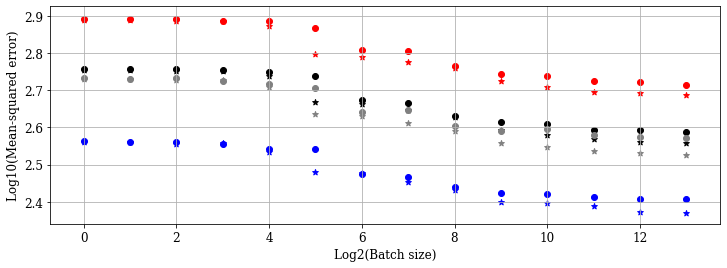

In [30]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        OldCIval = list(OldCItest[key][batchkey].values())
        plt.scatter(np.log2(batchkey),np.log10(np.median(BFval)),label=key,color=color_array[ikey])
        plt.scatter(np.log2(batchkey),np.log10(np.median(CIval)),marker='*',color=color_array[ikey])
#         plt.scatter(np.log2(batchkey),np.log10(np.median(OldCIval)),marker='^',color=color_array[ikey])
    ikey += 1
    
plt.grid()
#plt.legend()
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

Text(0, 0.5, 'Log10(Mean-squared error)')

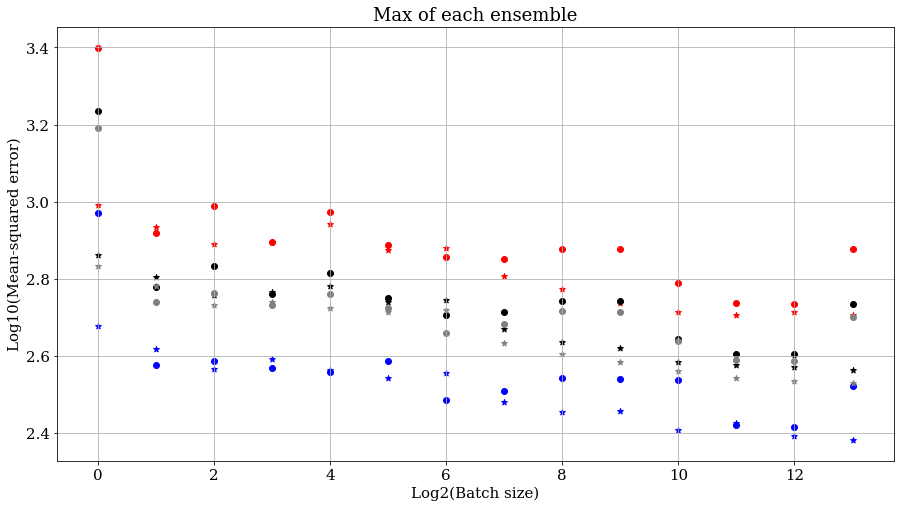

In [46]:
fig = plt.figure(figsize=(15,8))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        plt.scatter(np.log2(batchkey),np.log10(np.max(BFval)),label=key,color=color_array[ikey])
        plt.scatter(np.log2(batchkey),np.log10(np.max(CIval)),marker='*',color=color_array[ikey])
#         plt.scatter(np.log2(batchkey),np.log10(np.max(BFval)),label=key,color=color_array[ikey],facecolors='none')
#         plt.scatter(np.log2(batchkey),np.log10(np.max(CIval)),marker='*',color=color_array[ikey],facecolors='none')
    ikey += 1
    
plt.grid()
#plt.legend()
plt.title('Max of each ensemble')
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

In [38]:
10**(2.7)

501.18723362727246

Text(0, 0.5, 'Log10(Mean-squared error)')

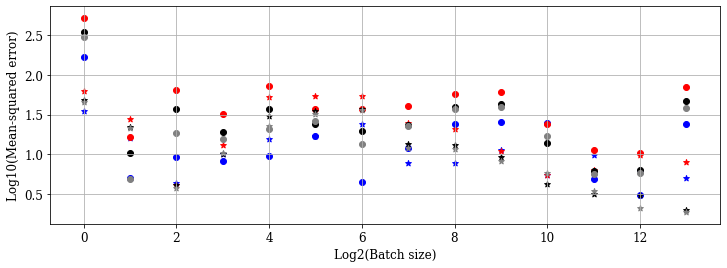

In [33]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        plt.scatter(np.log2(batchkey),np.log10(np.std(BFval)),label=key,color=color_array[ikey])
        plt.scatter(np.log2(batchkey),np.log10(np.std(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
plt.grid()
#plt.legend()
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

Text(0, 0.5, 'Log10(Mean-squared error)')

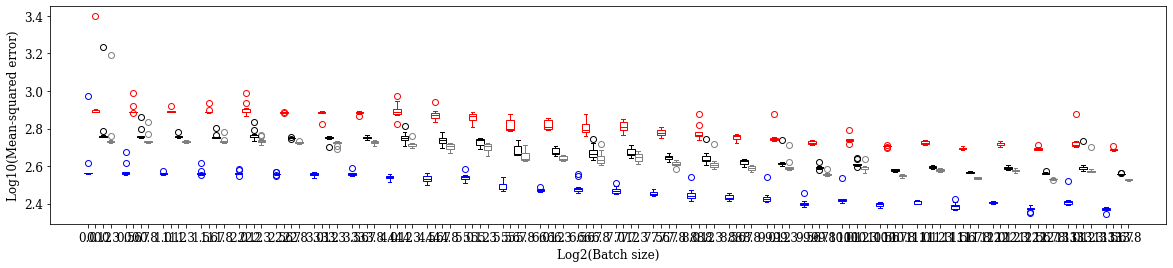

In [34]:
fig = plt.figure(figsize=(20,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        c = color_array[ikey]
        plt.boxplot(x = np.log10(BFval), vert=True,
                    patch_artist=True,
                    boxprops=dict(facecolor='w', color=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),
                    flierprops=dict(color=c, markeredgecolor=c),
                    medianprops=dict(color=c),widths=0.1,
                    positions=[np.log2(batchkey)+ikey/10])
        plt.boxplot(x = np.log10(CIval), vert=True,
                    patch_artist=True,
                    boxprops=dict(facecolor='w', color=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),
                    flierprops=dict(color=c, markeredgecolor=c),
                    medianprops=dict(color=c),widths=0.1,
                    positions=[np.log2(batchkey)+0.5+ikey/10])
        #plt.scatter(np.log2(batchkey),np.log10(np.mean(BFval)),label=key,color=color_array[ikey])
        #plt.scatter(np.log2(batchkey),np.log10(np.mean(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
#plt.legend()
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

Text(0, 0.5, 'Log10(Mean-squared error)')

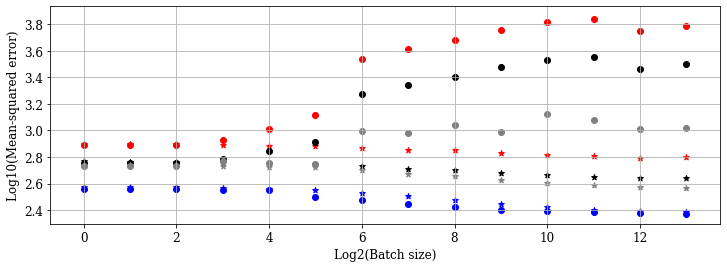

In [29]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        plt.scatter(np.log2(batchkey),np.log10(np.median(BFval)),label=key,color=color_array[ikey])
        plt.scatter(np.log2(batchkey),np.log10(np.median(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
plt.grid()
#plt.legend()
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

Text(0, 0.5, 'Log10(Mean-squared error)')

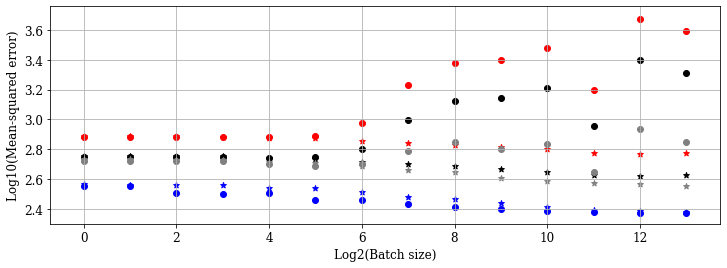

In [30]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        plt.scatter(np.log2(batchkey),np.log10(np.min(BFval)),label=key,color=color_array[ikey])
        plt.scatter(np.log2(batchkey),np.log10(np.min(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
plt.grid()
#plt.legend()
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

Text(0, 0.5, 'Log10(Mean-squared error)')

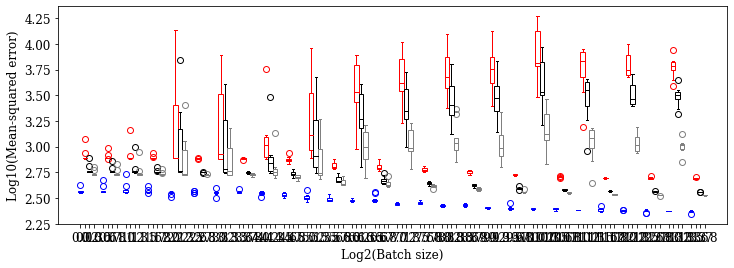

In [19]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        c = color_array[ikey]
        plt.boxplot(x = np.log10(BFval), vert=True,
                    patch_artist=True,
                    boxprops=dict(facecolor='w', color=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),
                    flierprops=dict(color=c, markeredgecolor=c),
                    medianprops=dict(color=c),widths=0.1,
                    positions=[np.log2(batchkey)+ikey/10])
        plt.boxplot(x = np.log10(CIval), vert=True,
                    patch_artist=True,
                    boxprops=dict(facecolor='w', color=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),
                    flierprops=dict(color=c, markeredgecolor=c),
                    medianprops=dict(color=c),widths=0.1,
                    positions=[np.log2(batchkey)+0.5+ikey/10])
        #plt.scatter(np.log2(batchkey),np.log10(np.mean(BFval)),label=key,color=color_array[ikey])
        #plt.scatter(np.log2(batchkey),np.log10(np.mean(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
#plt.legend()
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

In [40]:
np.log10(400)

2.6020599913279625

# Small data experiments using number of batches instead of batch size

## Overall parameters

In [21]:
N_batch_array = 2**np.arange(3,10) # Number of batches for each experiment
Nep = 50
N_NN = 10 # Number of NN trained per experiment
N_layer = 7 # Number of layers for the NNs
batch_size = 512 # Batch sizes we will consider in these experiments
N_samples = BFgen['both']['train'].n_samples # Total number of samples in the dataset
ptrain = path_array['both'][0]

## Design generators

In [22]:
BFgenSD = {}
CIgenSD = {}

In [27]:
for iN,N_batch in enumerate(N_batch_array):
    BFgenSD[N_batch] = {}
    CIgenSD[N_batch] = {}
    N_batch_max = int(N_samples/batch_size)
    print('N_batch=',N_batch,'& N_batch_max=',N_batch_max)
    
    for iexp in range(N_NN):
        BFgenSD[N_batch][iexp] = {}
        CIgenSD[N_batch][iexp] = {}
        # Randomly select 8 batches
        b_random = np.random.choice(np.linspace(0,N_batch_max-1,N_batch_max),
                                    size=((N_batch,)),
                                    replace=False).astype('int')
        print('Exp#',str(iexp),'b_random=',b_random)
        
        BFgenSD[N_batch][iexp]['train'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[0:int(N_batch/2)],batch_size=batch_size,rescaling=None)
        BFgenSD[N_batch][iexp]['valid'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[int(N_batch/2):],batch_size=batch_size,rescaling=None)
        
        CIgenSD[N_batch][iexp]['train'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[0:int(N_batch/2)],batch_size=batch_size,rescaling='CI')
        CIgenSD[N_batch][iexp]['valid'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[int(N_batch/2):],batch_size=batch_size,rescaling='CI')

N_batch= 8 & N_batch_max= 184288
Exp# 0 b_random= [ 45994 174838 168687  95954  31701 148002  53434 141927]
Exp# 1 b_random= [ 42302 114048 119168  64488  96953 128816  58201  62558]
Exp# 2 b_random= [155717  18586 115366  55906 165001  73470 118107 114275]
Exp# 3 b_random= [ 55238  53453 134526  45782 142772  57711  72338  58870]
Exp# 4 b_random= [ 51888  64578  53134  20666  72440  50209 102304 128431]
Exp# 5 b_random= [121431 121768  88298 125460 165338 110201  70371  63148]
Exp# 6 b_random= [101307  36317   3366   4655 126533  51311  84126  74292]
Exp# 7 b_random= [ 56388  78427 121025  11026  37909 146716 137880 117594]
Exp# 8 b_random= [104730   8790  46795  65198  64511 126798  76782 150181]
Exp# 9 b_random= [  5742 112433  59247 130267 121487 100278  86569  72329]
N_batch= 16 & N_batch_max= 184288
Exp# 0 b_random= [146771 160217  94618  72509 101810 132301 157200 172729 128860 180073
  50372  77249 176897  37565  57243  52730]
Exp# 1 b_random= [123351  85307 145946  18670  9266

Exp# 8 b_random= [163823  59392  21627 144181  66934 124392 141419  19617 125223 142713
   2780  80715  64298  92611  31194  86754  10543 133081 135356  78084
 180034  80415   8593  38251 182235 124879 162414  80895 126867 177816
 129291 144641 157156 122210  98968   1210 146891  98702  43228 114483
  65381  75189  97582  80656 175247  40747 126814 153246  53272 120243
 132776 126856 107689  11643 184033  11662 133904 162773 139111  84449
 170425 168300 165762 117404]
Exp# 9 b_random= [ 14091  50005  95974 173995  73141  97863  67313  69250 123109 171556
  76707  50693   6858  15364 155907   4725  53883  85604  76181  70645
  27957 150215 156002  79771  46002  32649 120585  22185 152377  91713
 144986 137223 159707 183535  54564 183631 152347 183441 110073 155361
  88094  12334 165914  64567  33431 112494  91502   8714 176849   1090
 168984 118954     49  29507 166347  24857 131469  16325 149422 168299
  70779 174388 159172 154777]
N_batch= 128 & N_batch_max= 184288
Exp# 0 b_random= [ 

Exp# 8 b_random= [145743  90210 150311 158582  26838 163441   6447 126892  80372 111881
  47770  34774   5218  95989 125998  19848 124907 168652 138781  79704
 165310 156219  66834  97618  52422 136104 122716  50480 162589  10814
 148645  14817  77673  29481  13631 110206 145851 181091  95515 150125
  95233   9392  98916 150302 109286 184085 124497   2819  45547 183593
  62426  48348  16478  94897  13211 160181 101124  23443 118944  14090
 183460  83745  38318  57130  57858 131658   2232 143566  68019  78154
  83057  35240 164547  52677 154052  48444  40432  86322 111984 111399
 119474 136269  92531  40474 125695 103887 125031  90103   7142  66243
  50343  35069   4798  52396  35910   1579 112905  37677  88915 102645
 179810  73359 118432 179862  50421  88018  76473  35814  50121  74642
  65525  31171 175693  87503 181439    407  81197  39860 157438  19594
  56473  26518  95229 157896  50154   8795  76213  11317]
Exp# 9 b_random= [ 14623  72934 105777  48319 101091 114656  88594 102609

Exp# 4 b_random= [ 38339  53781 169573 176907   9621  88045 136411  60008  27951  26458
  96151  27540 101559 148975  49330  97234  50533  87896  51743  51460
 116129  45550  91232 103369 175827  56577  53376  36522 137033  35824
 116228 177237  35386  73948 152538  22610 140928  51838 147584  83017
 160826  53216 149859  71561 153966  93351 163852 124888 143520  85547
 171736 148930  68654  33529 172425  82504  19468   3110  80008 130568
 112625 110170 122732 128751  30148  29306   3376 144397  76162  95288
 177449  53116  85401 155460  17975  88224  20480 160160 125616 121907
  41378 120026  78041 122012  40846  48275  65914 170542 121831  65200
  20323  32999  92407  88362 112142 138010  58988 152002 173309  43924
 145291  15057 110986 110730 147922 118424  32508 169487  77544  58196
 161271  17039  99872   5451  35959  23453 179472  80933 105297 146733
 104965  64725  37349  54128 162864 139706  41863 173074 177669 167786
 132652    557  87016 101296  24152  43893  24250 107303  82

N_batch= 512 & N_batch_max= 184288
Exp# 0 b_random= [151417  62183 153855 137672 175968  15481 148669  23451  20423    361
 174387 167554 144856 107786  54639  66393  68075  89373 109217  43890
 175669  19820  53527  48512  23775 154042  92350 138563 140300   5586
  74616 175939 124046  18597 106633  72282 160483  93570 111586  93089
 108799 113515 139737 118162  81908  78835  30520 115137  56962 115852
 109609  77694  81796 138671  63485   5263  13455   3944 153117 100827
  66748  28913  74831  80405  74027 134418 120462  68941 109750  49189
 121266  26166  94086 132537 120260 113875 142675 166546  52924  68817
 160164  36140  18687 138270  45584    696  72341  83857 150978 179998
 173955 174019  31418  93804  43880  87689 146705 109693 123269  77180
  77266 136906  20275  51035  82378  78038  99151  57749  46935  44911
  29204  70128 135302 133916  41442  95229  55200  47220 163793  62393
  79822 152403 150225   7929 159326 183029 165690  91250 138639  27735
 132930  86113  38605 179

Exp# 4 b_random= [154979 110294 179797   1392  95722 153817  77135  86192  54130 173493
  97123   9235 132173  83596  81373  26724  60898 112809 139648  35363
  30177  88727 126033 163102 160821   9277 152748 107287 169242  21172
 104942 170600 166287  61525  46900 115913 103992 142956  48571  71619
 156218 122020  85614 153724   5243 133485  84997 139082  29929 105422
  86249  73528 173983 183140  87129  24932 107094  92577 156060   5269
 151538  52932 119487 109103 144660 167480 168015 109462  41137  12112
   3529 109014 161404 153153   3965  82212  57520 133349  20667  77233
 130844  30256  95555  50311   3061 155567 155353 116636 139839  27841
  48623  22821   7045  30518 159387 183751 111887  91900 149441  80797
  69650    567  52580 154501  73514  71895 118484 143240  31139  55674
  15201 106928 132950  69864  43211 145479  60888 102851  99024  64574
  16422 173619 142138  97469 133629 110661 111429 159196   5292  81247
  25099  79067 119426  43577  64817  15367  33626 108589  29

Exp# 8 b_random= [ 72616  98124  83865  52447 160450 168336 159735  32888  53201 131753
  49562  30862  55882  83059 167485 140282 112780 109693  92907 148765
  38098  73523 101586 164744  18906  86852 112489  70084 107387 172160
  65324 165250  71131 131258  51646   4651 103766 126783 158297  25008
  66043 145968   5103 112256   5463  59994  20769 111120 164539 148567
  23477  33551   3693  56544 110501 172534 157942 110238 104121  53159
 107668  93738  19175 103045 118204 123527 168235  16678 137500   9008
 126891 129273  79025 133243   6540  67556  63050   5893  79548  74746
 121922  44963  93576  30530   7522 123245 178536 110729  12556 170676
 105787 105995 161813 153961 176380 170036 180518 122820 101367  85917
  78795  19760  65457  45708  28206 151120 107784 135462  81046   7663
 167570  68682  78862 103544 108076  55945  92987  21827 132608    766
  27900 171069 127070  39780 170134  87236 180240  11691  50587 120696
  21746  64778 183409   4522 178791  65331 146140   4922 129

## Train models

In [32]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')

In [33]:
# Inputs
inpBFSD = {}
inpCISD = {}
# Model
NNBFSD = {}
NNCISD = {}
# History
hisBF = {}
hisCI = {}

In [34]:
for iN,N_batch in enumerate(N_batch_array):
    inpBFSD[N_batch] = {}
    inpCISD[N_batch] = {}
    NNBFSD[N_batch] = {}
    NNCISD[N_batch] = {}
    hisBF[N_batch] = {}
    hisCI[N_batch] = {}
    for iexp in range(N_NN):
        print('batch_number=',N_batch,'& iexp=',iexp)
        # Model definition
        inpBFSD[N_batch][iexp] = Input(shape=(64,))
        inpCISD[N_batch][iexp] = Input(shape=(64,))
        NNBFSD[N_batch][iexp] = NN_model(inpBFSD[N_batch][iexp],N_layer)
        NNCISD[N_batch][iexp] = NN_model(inpCISD[N_batch][iexp],N_layer)
        NNBFSD[N_batch][iexp].compile(tf.keras.optimizers.Adam(), loss=mse)
        NNCISD[N_batch][iexp].compile(tf.keras.optimizers.Adam(), loss=mse)
        # Model callbacks
        path_BF = path_data + 'HDF5_DATA/2022_05_17_BF_'+str(N_batch)+'_'+str(iexp)+'.hdf5'
        path_CI = path_data + 'HDF5_DATA/2022_05_17_CI_'+str(N_batch)+'_'+str(iexp)+'.hdf5'
        mcp_BF = ModelCheckpoint(path_BF,save_best_only=True, monitor='val_loss', mode='min')
        mcp_CI = ModelCheckpoint(path_CI,save_best_only=True, monitor='val_loss', mode='min')
        # Model training
        hisBF[N_batch][iexp] = NNBFSD[N_batch][iexp].fit_generator(
            BFgenSD[N_batch][iexp]['train'],epochs=Nep,
            validation_data = BFgenSD[N_batch][iexp]['valid'],
            callbacks=[mcp_BF,earlyStopping])
        hisCI[N_batch][iexp] = NNCISD[N_batch][iexp].fit_generator(
            CIgenSD[N_batch][iexp]['train'],epochs=Nep,
            validation_data = CIgenSD[N_batch][iexp]['valid'],
            callbacks=[mcp_CI,earlyStopping])

batch_number= 8 & iexp= 0
Epoch 1/50
4/4 [==============================] - 1s 156ms/step - loss: 750.5109 - val_loss: 548.8025
Epoch 2/50
4/4 [==============================] - 0s 65ms/step - loss: 749.7109 - val_loss: 547.4332
Epoch 3/50
4/4 [==============================] - 0s 67ms/step - loss: 746.8882 - val_loss: 543.3331
Epoch 4/50
4/4 [==============================] - 0s 66ms/step - loss: 740.1200 - val_loss: 537.4907
Epoch 5/50
4/4 [==============================] - 0s 67ms/step - loss: 734.8697 - val_loss: 533.7068
Epoch 6/50
4/4 [==============================] - 0s 69ms/step - loss: 729.5427 - val_loss: 531.6450
Epoch 7/50
4/4 [==============================] - 0s 69ms/step - loss: 726.9506 - val_loss: 529.7818
Epoch 8/50
4/4 [==============================] - 0s 67ms/step - loss: 724.7326 - val_loss: 527.6644
Epoch 9/50
4/4 [==============================] - 0s 69ms/step - loss: 722.2585 - val_loss: 525.9343
Epoch 10/50
4/4 [==============================] - 0s 67ms/step 

4/4 [==============================] - 0s 73ms/step - loss: 424.1132 - val_loss: 472.7578
Epoch 12/50
4/4 [==============================] - 0s 73ms/step - loss: 425.9850 - val_loss: 481.9560
Epoch 13/50
4/4 [==============================] - 0s 94ms/step - loss: 443.1249 - val_loss: 460.8823
Epoch 14/50
4/4 [==============================] - 0s 53ms/step - loss: 436.1770 - val_loss: 474.0777
Epoch 15/50
4/4 [==============================] - 0s 80ms/step - loss: 427.8814 - val_loss: 475.5139
Epoch 16/50
4/4 [==============================] - 0s 65ms/step - loss: 413.1796 - val_loss: 459.8343
Epoch 17/50
4/4 [==============================] - 0s 79ms/step - loss: 411.2188 - val_loss: 462.3556
Epoch 18/50
4/4 [==============================] - 0s 92ms/step - loss: 405.0198 - val_loss: 452.6859
Epoch 19/50
4/4 [==============================] - 0s 74ms/step - loss: 397.7970 - val_loss: 459.9826
Epoch 20/50
4/4 [==============================] - 0s 75ms/step - loss: 392.9821 - val_loss: 4

4/4 [==============================] - 0s 64ms/step - loss: 389.8186 - val_loss: 369.4910
Epoch 22/50
4/4 [==============================] - 0s 49ms/step - loss: 383.0788 - val_loss: 411.1298
Epoch 23/50
4/4 [==============================] - 0s 48ms/step - loss: 393.7949 - val_loss: 383.8957
Epoch 24/50
4/4 [==============================] - 0s 47ms/step - loss: 401.2862 - val_loss: 391.5357
Epoch 25/50
4/4 [==============================] - 0s 64ms/step - loss: 391.4704 - val_loss: 365.3614
Epoch 26/50
4/4 [==============================] - 0s 51ms/step - loss: 397.6403 - val_loss: 369.3863
Epoch 27/50
4/4 [==============================] - 0s 50ms/step - loss: 382.5270 - val_loss: 406.4214
Epoch 28/50
4/4 [==============================] - 0s 67ms/step - loss: 385.1780 - val_loss: 364.8217
Epoch 29/50
4/4 [==============================] - 0s 65ms/step - loss: 382.6786 - val_loss: 364.7986
Epoch 30/50
4/4 [==============================] - 0s 47ms/step - loss: 374.4495 - val_loss: 3

4/4 [==============================] - 0s 74ms/step - loss: 270.3517 - val_loss: 466.2360
Epoch 32/50
4/4 [==============================] - 0s 92ms/step - loss: 267.3389 - val_loss: 461.7156
Epoch 33/50
4/4 [==============================] - 0s 49ms/step - loss: 262.9293 - val_loss: 463.3697
Epoch 34/50
4/4 [==============================] - 0s 97ms/step - loss: 262.8831 - val_loss: 460.8293
Epoch 35/50
4/4 [==============================] - 0s 73ms/step - loss: 259.8107 - val_loss: 462.1020
Epoch 36/50
4/4 [==============================] - 0s 74ms/step - loss: 263.2591 - val_loss: 465.1630
Epoch 37/50
4/4 [==============================] - 0s 72ms/step - loss: 270.0091 - val_loss: 479.0591
Epoch 38/50
4/4 [==============================] - 0s 74ms/step - loss: 259.4359 - val_loss: 477.9646
Epoch 39/50
4/4 [==============================] - 0s 74ms/step - loss: 262.0698 - val_loss: 479.0947
Epoch 40/50
4/4 [==============================] - 0s 49ms/step - loss: 257.5853 - val_loss: 4

4/4 [==============================] - 0s 48ms/step - loss: 335.9057 - val_loss: 333.9626
Epoch 42/50
4/4 [==============================] - 0s 68ms/step - loss: 334.4950 - val_loss: 332.7737
Epoch 43/50
4/4 [==============================] - 0s 50ms/step - loss: 333.1537 - val_loss: 334.6236
Epoch 44/50
4/4 [==============================] - 0s 47ms/step - loss: 331.9569 - val_loss: 336.9698
Epoch 45/50
4/4 [==============================] - 0s 48ms/step - loss: 332.0531 - val_loss: 333.2739
Epoch 46/50
4/4 [==============================] - 0s 68ms/step - loss: 330.6209 - val_loss: 330.7124
Epoch 47/50
4/4 [==============================] - 0s 50ms/step - loss: 329.9457 - val_loss: 334.3299
Epoch 48/50
4/4 [==============================] - 0s 50ms/step - loss: 328.5916 - val_loss: 332.3117
Epoch 49/50
4/4 [==============================] - 0s 52ms/step - loss: 327.8285 - val_loss: 330.8694
Epoch 50/50
4/4 [==============================] - 0s 50ms/step - loss: 326.7588 - val_loss: 3

4/4 [==============================] - 1s 143ms/step - loss: 488.1102 - val_loss: 565.4469
Epoch 2/50
4/4 [==============================] - 0s 67ms/step - loss: 486.9331 - val_loss: 563.3419
Epoch 3/50
4/4 [==============================] - 0s 72ms/step - loss: 484.3469 - val_loss: 558.2089
Epoch 4/50
4/4 [==============================] - 0s 66ms/step - loss: 478.7537 - val_loss: 556.6789
Epoch 5/50
4/4 [==============================] - 0s 66ms/step - loss: 476.0029 - val_loss: 550.4150
Epoch 6/50
4/4 [==============================] - 0s 70ms/step - loss: 469.5974 - val_loss: 545.2224
Epoch 7/50
4/4 [==============================] - 0s 65ms/step - loss: 468.5751 - val_loss: 543.2354
Epoch 8/50
4/4 [==============================] - 0s 64ms/step - loss: 465.8621 - val_loss: 539.7600
Epoch 9/50
4/4 [==============================] - 0s 66ms/step - loss: 461.6630 - val_loss: 535.7169
Epoch 10/50
4/4 [==============================] - 0s 65ms/step - loss: 457.4107 - val_loss: 528.0292

4/4 [==============================] - 0s 92ms/step - loss: 487.7915 - val_loss: 466.5386
Epoch 12/50
4/4 [==============================] - 0s 49ms/step - loss: 476.5713 - val_loss: 472.3418
Epoch 13/50
4/4 [==============================] - 0s 79ms/step - loss: 470.5767 - val_loss: 467.3151
Epoch 14/50
4/4 [==============================] - 0s 75ms/step - loss: 480.3585 - val_loss: 467.0133
Epoch 15/50
4/4 [==============================] - 0s 68ms/step - loss: 466.5860 - val_loss: 464.1462
Epoch 16/50
4/4 [==============================] - 0s 72ms/step - loss: 446.7569 - val_loss: 459.9937
Epoch 17/50
4/4 [==============================] - 0s 97ms/step - loss: 447.5639 - val_loss: 457.9557
Epoch 18/50
4/4 [==============================] - 0s 91ms/step - loss: 446.8691 - val_loss: 456.7234
Epoch 19/50
4/4 [==============================] - 0s 48ms/step - loss: 450.7542 - val_loss: 519.7769
Epoch 20/50
4/4 [==============================] - 0s 79ms/step - loss: 458.8315 - val_loss: 4

8/8 [==============================] - 0s 49ms/step - loss: 471.7308 - val_loss: 434.3872
Epoch 22/50
8/8 [==============================] - 0s 49ms/step - loss: 462.9303 - val_loss: 429.4666
Epoch 23/50
8/8 [==============================] - 0s 57ms/step - loss: 460.5944 - val_loss: 420.4952
Epoch 24/50
8/8 [==============================] - 0s 56ms/step - loss: 455.2334 - val_loss: 419.1606
Epoch 25/50
8/8 [==============================] - 0s 48ms/step - loss: 462.1484 - val_loss: 427.0305
Epoch 26/50
8/8 [==============================] - 0s 48ms/step - loss: 460.4756 - val_loss: 433.7463
Epoch 27/50
8/8 [==============================] - 0s 59ms/step - loss: 472.9010 - val_loss: 418.8350
Epoch 28/50
8/8 [==============================] - 0s 49ms/step - loss: 460.1966 - val_loss: 420.7132
Epoch 29/50
8/8 [==============================] - 0s 48ms/step - loss: 454.1049 - val_loss: 423.9677
Epoch 30/50
8/8 [==============================] - 0s 57ms/step - loss: 454.4004 - val_loss: 4

8/8 [==============================] - 1s 74ms/step - loss: 354.9754 - val_loss: 409.0638
Epoch 32/50
8/8 [==============================] - 0s 60ms/step - loss: 357.8633 - val_loss: 425.5955
Epoch 33/50
8/8 [==============================] - 0s 60ms/step - loss: 383.4357 - val_loss: 432.0991
Epoch 34/50
8/8 [==============================] - 0s 60ms/step - loss: 367.8581 - val_loss: 413.4243
Epoch 35/50
8/8 [==============================] - 0s 60ms/step - loss: 358.9282 - val_loss: 413.7053
Epoch 36/50
8/8 [==============================] - 1s 70ms/step - loss: 356.1019 - val_loss: 405.7354
Epoch 37/50
8/8 [==============================] - 0s 61ms/step - loss: 360.0021 - val_loss: 425.3014
Epoch 38/50
8/8 [==============================] - 0s 60ms/step - loss: 357.5999 - val_loss: 407.9218
Epoch 39/50
8/8 [==============================] - 0s 61ms/step - loss: 348.5804 - val_loss: 410.9901
Epoch 40/50
8/8 [==============================] - 0s 61ms/step - loss: 342.4358 - val_loss: 4

8/8 [==============================] - 0s 59ms/step - loss: 356.6533 - val_loss: 337.3886
Epoch 42/50
8/8 [==============================] - 0s 48ms/step - loss: 355.0256 - val_loss: 337.9203
Epoch 43/50
8/8 [==============================] - 0s 48ms/step - loss: 354.1467 - val_loss: 343.9977
Epoch 44/50
8/8 [==============================] - 0s 48ms/step - loss: 357.3169 - val_loss: 338.2520
Epoch 45/50
8/8 [==============================] - 0s 37ms/step - loss: 366.2025 - val_loss: 369.6464
Epoch 46/50
8/8 [==============================] - 0s 46ms/step - loss: 361.5969 - val_loss: 335.8207
Epoch 47/50
8/8 [==============================] - 0s 48ms/step - loss: 352.4413 - val_loss: 336.6046
Epoch 48/50
8/8 [==============================] - 0s 48ms/step - loss: 350.3739 - val_loss: 336.4270
Epoch 49/50
8/8 [==============================] - 0s 49ms/step - loss: 348.4721 - val_loss: 336.7160
Epoch 50/50
8/8 [==============================] - 0s 48ms/step - loss: 347.9143 - val_loss: 3

8/8 [==============================] - 1s 114ms/step - loss: 514.3343 - val_loss: 558.5388
Epoch 2/50
8/8 [==============================] - 0s 54ms/step - loss: 508.5865 - val_loss: 547.9448
Epoch 3/50
8/8 [==============================] - 0s 57ms/step - loss: 499.9135 - val_loss: 541.8924
Epoch 4/50
8/8 [==============================] - 0s 57ms/step - loss: 495.1281 - val_loss: 538.8528
Epoch 5/50
8/8 [==============================] - 0s 57ms/step - loss: 492.3485 - val_loss: 534.5772
Epoch 6/50
8/8 [==============================] - 0s 56ms/step - loss: 487.1968 - val_loss: 523.0240
Epoch 7/50
8/8 [==============================] - 0s 58ms/step - loss: 472.4097 - val_loss: 493.9555
Epoch 8/50
8/8 [==============================] - 0s 56ms/step - loss: 453.5551 - val_loss: 479.0378
Epoch 9/50
8/8 [==============================] - 0s 58ms/step - loss: 436.8043 - val_loss: 459.9819
Epoch 10/50
8/8 [==============================] - 0s 56ms/step - loss: 425.9636 - val_loss: 440.5710

8/8 [==============================] - 0s 60ms/step - loss: 409.9080 - val_loss: 601.1630
Epoch 12/50
8/8 [==============================] - 1s 68ms/step - loss: 402.0685 - val_loss: 595.7261
Epoch 13/50
8/8 [==============================] - 1s 68ms/step - loss: 397.0683 - val_loss: 594.5848
Epoch 14/50
8/8 [==============================] - 1s 70ms/step - loss: 396.6506 - val_loss: 591.4288
Epoch 15/50
8/8 [==============================] - 0s 60ms/step - loss: 399.2128 - val_loss: 593.0087
Epoch 16/50
8/8 [==============================] - 1s 70ms/step - loss: 419.2847 - val_loss: 583.8979
Epoch 17/50
8/8 [==============================] - 0s 61ms/step - loss: 402.8204 - val_loss: 652.3018
Epoch 18/50
8/8 [==============================] - 0s 61ms/step - loss: 407.4105 - val_loss: 591.0072
Epoch 19/50
8/8 [==============================] - 1s 70ms/step - loss: 401.7553 - val_loss: 582.3894
Epoch 20/50
8/8 [==============================] - 0s 60ms/step - loss: 389.4126 - val_loss: 5

8/8 [==============================] - 0s 57ms/step - loss: 456.2733 - val_loss: 366.5584
Epoch 22/50
8/8 [==============================] - 0s 59ms/step - loss: 453.0056 - val_loss: 364.1484
Epoch 23/50
8/8 [==============================] - 0s 52ms/step - loss: 452.0915 - val_loss: 368.3886
Epoch 24/50
8/8 [==============================] - 0s 52ms/step - loss: 452.3531 - val_loss: 365.2881
Epoch 25/50
8/8 [==============================] - 0s 59ms/step - loss: 444.9772 - val_loss: 362.3479
Epoch 26/50
8/8 [==============================] - 0s 57ms/step - loss: 444.4366 - val_loss: 360.8397
Epoch 27/50
8/8 [==============================] - 0s 56ms/step - loss: 440.2170 - val_loss: 358.3603
Epoch 28/50
8/8 [==============================] - 0s 49ms/step - loss: 435.8199 - val_loss: 365.2423
Epoch 29/50
8/8 [==============================] - 0s 48ms/step - loss: 438.5892 - val_loss: 358.8969
Epoch 30/50
8/8 [==============================] - 0s 48ms/step - loss: 446.5822 - val_loss: 3

16/16 [==============================] - 1s 59ms/step - loss: 377.3504 - val_loss: 390.1963
Epoch 31/50
16/16 [==============================] - 1s 52ms/step - loss: 404.6221 - val_loss: 381.1998
Epoch 32/50
16/16 [==============================] - 1s 52ms/step - loss: 381.9865 - val_loss: 378.5416
Epoch 33/50
16/16 [==============================] - 1s 50ms/step - loss: 387.1060 - val_loss: 412.3263
Epoch 34/50
16/16 [==============================] - 1s 58ms/step - loss: 387.1658 - val_loss: 365.2849
Epoch 35/50
16/16 [==============================] - 1s 53ms/step - loss: 369.2641 - val_loss: 361.5326
Epoch 36/50
16/16 [==============================] - 1s 58ms/step - loss: 364.0764 - val_loss: 364.7050
Epoch 37/50
16/16 [==============================] - 1s 59ms/step - loss: 380.8512 - val_loss: 374.3532
Epoch 38/50
16/16 [==============================] - 1s 52ms/step - loss: 384.4301 - val_loss: 377.5745
Epoch 39/50
16/16 [==============================] - 1s 60ms/step - loss: 36

Epoch 9/50
16/16 [==============================] - 1s 57ms/step - loss: 437.7195 - val_loss: 437.4242
Epoch 10/50
16/16 [==============================] - 1s 55ms/step - loss: 415.5821 - val_loss: 429.6280
Epoch 11/50
16/16 [==============================] - 1s 56ms/step - loss: 400.0147 - val_loss: 416.0642
Epoch 12/50
16/16 [==============================] - 1s 51ms/step - loss: 397.2508 - val_loss: 442.2030
Epoch 13/50
16/16 [==============================] - 1s 52ms/step - loss: 425.8121 - val_loss: 442.4881
Epoch 14/50
16/16 [==============================] - 1s 52ms/step - loss: 414.2306 - val_loss: 425.5792
Epoch 15/50
16/16 [==============================] - 1s 50ms/step - loss: 402.6511 - val_loss: 453.3017
Epoch 16/50
16/16 [==============================] - 1s 55ms/step - loss: 389.0748 - val_loss: 406.2446
Epoch 17/50
16/16 [==============================] - 1s 59ms/step - loss: 379.6394 - val_loss: 406.1538
Epoch 18/50
16/16 [==============================] - 1s 51ms/step

Epoch 16/50
16/16 [==============================] - 1s 41ms/step - loss: 462.1248 - val_loss: 447.0316
Epoch 17/50
16/16 [==============================] - 1s 41ms/step - loss: 472.2734 - val_loss: 462.2209
Epoch 18/50
16/16 [==============================] - 1s 40ms/step - loss: 463.7790 - val_loss: 450.0237
Epoch 19/50
16/16 [==============================] - 1s 41ms/step - loss: 460.4636 - val_loss: 450.2554
Epoch 20/50
16/16 [==============================] - 1s 45ms/step - loss: 463.2651 - val_loss: 441.7993
Epoch 21/50
16/16 [==============================] - 1s 40ms/step - loss: 461.9432 - val_loss: 446.2166
Epoch 22/50
16/16 [==============================] - 1s 41ms/step - loss: 457.8658 - val_loss: 442.1824
Epoch 23/50
16/16 [==============================] - 1s 46ms/step - loss: 447.2249 - val_loss: 441.0398
Epoch 24/50
16/16 [==============================] - 1s 43ms/step - loss: 443.0071 - val_loss: 437.6353
Epoch 25/50
16/16 [==============================] - 1s 41ms/ste

Epoch 45/50
16/16 [==============================] - 1s 58ms/step - loss: 429.8446 - val_loss: 452.2441
Epoch 46/50
16/16 [==============================] - 1s 54ms/step - loss: 425.5157 - val_loss: 439.5619
Epoch 47/50
16/16 [==============================] - 1s 56ms/step - loss: 406.2244 - val_loss: 435.6527
Epoch 48/50
16/16 [==============================] - 1s 49ms/step - loss: 394.1367 - val_loss: 450.0791
Epoch 49/50
16/16 [==============================] - 1s 63ms/step - loss: 391.0722 - val_loss: 433.6455
Epoch 50/50
16/16 [==============================] - 1s 59ms/step - loss: 403.2080 - val_loss: 445.0419
batch_number= 32 & iexp= 4
Epoch 1/50
16/16 [==============================] - 2s 104ms/step - loss: 602.3485 - val_loss: 474.5267
Epoch 2/50
16/16 [==============================] - 1s 43ms/step - loss: 587.6672 - val_loss: 465.5538
Epoch 3/50
16/16 [==============================] - 1s 44ms/step - loss: 580.9007 - val_loss: 459.8526
Epoch 4/50
16/16 [=====================

16/16 [==============================] - 1s 83ms/step - loss: 586.3423 - val_loss: 491.0830
Epoch 2/50
16/16 [==============================] - 1s 54ms/step - loss: 553.6446 - val_loss: 465.9102
Epoch 3/50
16/16 [==============================] - 1s 55ms/step - loss: 526.9295 - val_loss: 444.6914
Epoch 4/50
16/16 [==============================] - 1s 56ms/step - loss: 508.0409 - val_loss: 429.7266
Epoch 5/50
16/16 [==============================] - 1s 58ms/step - loss: 505.6502 - val_loss: 425.4291
Epoch 6/50
16/16 [==============================] - 1s 56ms/step - loss: 491.5096 - val_loss: 423.9705
Epoch 7/50
16/16 [==============================] - 1s 55ms/step - loss: 491.2730 - val_loss: 416.7971
Epoch 8/50
16/16 [==============================] - 1s 56ms/step - loss: 472.3111 - val_loss: 424.0110
Epoch 9/50
16/16 [==============================] - 1s 51ms/step - loss: 468.2005 - val_loss: 424.0639
Epoch 10/50
16/16 [==============================] - 1s 56ms/step - loss: 463.9129 -

Epoch 30/50
16/16 [==============================] - 1s 44ms/step - loss: 345.5888 - val_loss: 429.6890
Epoch 31/50
16/16 [==============================] - 1s 39ms/step - loss: 354.4450 - val_loss: 473.2965
Epoch 32/50
16/16 [==============================] - 1s 34ms/step - loss: 352.9946 - val_loss: 452.1004
Epoch 33/50
16/16 [==============================] - 1s 38ms/step - loss: 349.3018 - val_loss: 425.2696
Epoch 34/50
16/16 [==============================] - 1s 40ms/step - loss: 340.0275 - val_loss: 428.5963
Epoch 35/50
16/16 [==============================] - 1s 40ms/step - loss: 341.1804 - val_loss: 461.4131
Epoch 36/50
16/16 [==============================] - 1s 39ms/step - loss: 345.9754 - val_loss: 425.6322
Epoch 37/50
16/16 [==============================] - 1s 44ms/step - loss: 335.0192 - val_loss: 416.2037
Epoch 38/50
16/16 [==============================] - 1s 44ms/step - loss: 329.8173 - val_loss: 414.5911
Epoch 39/50
16/16 [==============================] - 1s 39ms/ste

Epoch 37/50
16/16 [==============================] - 1s 55ms/step - loss: 423.5377 - val_loss: 456.9829
Epoch 38/50
16/16 [==============================] - 1s 53ms/step - loss: 400.9006 - val_loss: 430.3875
Epoch 39/50
16/16 [==============================] - 1s 61ms/step - loss: 388.8499 - val_loss: 431.8956
Epoch 40/50
16/16 [==============================] - 1s 54ms/step - loss: 375.8267 - val_loss: 411.6301
Epoch 41/50
16/16 [==============================] - 1s 57ms/step - loss: 369.7907 - val_loss: 414.5977
Epoch 42/50
16/16 [==============================] - 1s 58ms/step - loss: 378.4411 - val_loss: 421.5283
Epoch 43/50
16/16 [==============================] - 1s 52ms/step - loss: 382.2669 - val_loss: 430.3594
Epoch 44/50
16/16 [==============================] - 1s 50ms/step - loss: 373.7166 - val_loss: 422.5491
Epoch 45/50
16/16 [==============================] - 1s 51ms/step - loss: 370.1450 - val_loss: 415.2296
Epoch 46/50
16/16 [==============================] - 1s 61ms/ste

16/16 [==============================] - 1s 41ms/step - loss: 425.1785 - val_loss: 370.2456
Epoch 44/50
16/16 [==============================] - 1s 41ms/step - loss: 426.9949 - val_loss: 372.2658
Epoch 45/50
16/16 [==============================] - 1s 45ms/step - loss: 423.6043 - val_loss: 366.6215
Epoch 46/50
16/16 [==============================] - 1s 46ms/step - loss: 425.2222 - val_loss: 366.0518
Epoch 47/50
16/16 [==============================] - 1s 39ms/step - loss: 429.0701 - val_loss: 371.6589
Epoch 48/50
16/16 [==============================] - 1s 45ms/step - loss: 423.0698 - val_loss: 365.6314
Epoch 49/50
16/16 [==============================] - 1s 40ms/step - loss: 426.2760 - val_loss: 366.2062
Epoch 50/50
16/16 [==============================] - 1s 46ms/step - loss: 426.2619 - val_loss: 364.6149
Epoch 1/50
16/16 [==============================] - 1s 70ms/step - loss: 640.9675 - val_loss: 494.1210
Epoch 2/50
16/16 [==============================] - 1s 61ms/step - loss: 602.

Epoch 22/50
32/32 [==============================] - 1s 36ms/step - loss: 426.2636 - val_loss: 405.1303
Epoch 23/50
32/32 [==============================] - 1s 38ms/step - loss: 423.6802 - val_loss: 412.1369
Epoch 24/50
32/32 [==============================] - 1s 37ms/step - loss: 421.2959 - val_loss: 401.2427
Epoch 25/50
32/32 [==============================] - 1s 36ms/step - loss: 418.1950 - val_loss: 404.8533
Epoch 26/50
32/32 [==============================] - 1s 42ms/step - loss: 421.5734 - val_loss: 400.9676
Epoch 27/50
32/32 [==============================] - 1s 39ms/step - loss: 416.2359 - val_loss: 396.7336
Epoch 28/50
32/32 [==============================] - 1s 39ms/step - loss: 416.0049 - val_loss: 427.3965
Epoch 29/50
32/32 [==============================] - 1s 41ms/step - loss: 420.5045 - val_loss: 396.6480
Epoch 30/50
32/32 [==============================] - 1s 41ms/step - loss: 423.7083 - val_loss: 396.4241
Epoch 31/50
32/32 [==============================] - 1s 40ms/ste

batch_number= 64 & iexp= 1
Epoch 1/50
32/32 [==============================] - 3s 94ms/step - loss: 542.8209 - val_loss: 593.4821
Epoch 2/50
32/32 [==============================] - 1s 42ms/step - loss: 528.0772 - val_loss: 576.2813
Epoch 3/50
32/32 [==============================] - 1s 38ms/step - loss: 489.6029 - val_loss: 502.5572
Epoch 4/50
32/32 [==============================] - 1s 39ms/step - loss: 450.0008 - val_loss: 505.0294
Epoch 5/50
32/32 [==============================] - 1s 41ms/step - loss: 443.3268 - val_loss: 468.9027
Epoch 6/50
32/32 [==============================] - 1s 39ms/step - loss: 425.1648 - val_loss: 454.3886
Epoch 7/50
32/32 [==============================] - 1s 38ms/step - loss: 451.7733 - val_loss: 542.7776
Epoch 8/50
32/32 [==============================] - 1s 36ms/step - loss: 441.6734 - val_loss: 454.6169
Epoch 9/50
32/32 [==============================] - 1s 37ms/step - loss: 424.4169 - val_loss: 468.8360
Epoch 10/50
32/32 [===========================

Epoch 8/50
32/32 [==============================] - 2s 57ms/step - loss: 445.9431 - val_loss: 475.0909
Epoch 9/50
32/32 [==============================] - 2s 53ms/step - loss: 440.6234 - val_loss: 520.4763
Epoch 10/50
32/32 [==============================] - 2s 56ms/step - loss: 446.6532 - val_loss: 469.6983
Epoch 11/50
32/32 [==============================] - 2s 52ms/step - loss: 430.8832 - val_loss: 478.2926
Epoch 12/50
32/32 [==============================] - 2s 52ms/step - loss: 433.8279 - val_loss: 486.0431
Epoch 13/50
32/32 [==============================] - 2s 52ms/step - loss: 418.2993 - val_loss: 470.5428
Epoch 14/50
32/32 [==============================] - 2s 56ms/step - loss: 428.1000 - val_loss: 462.8215
Epoch 15/50
32/32 [==============================] - 2s 51ms/step - loss: 419.5170 - val_loss: 472.8265
Epoch 16/50
32/32 [==============================] - 2s 51ms/step - loss: 415.9221 - val_loss: 473.4499
Epoch 17/50
32/32 [==============================] - 2s 56ms/step 

Epoch 15/50
32/32 [==============================] - 1s 38ms/step - loss: 389.7599 - val_loss: 377.8151
Epoch 16/50
32/32 [==============================] - 1s 39ms/step - loss: 388.4931 - val_loss: 385.7124
Epoch 17/50
32/32 [==============================] - 1s 42ms/step - loss: 386.0852 - val_loss: 369.6323
Epoch 18/50
32/32 [==============================] - 1s 42ms/step - loss: 382.3521 - val_loss: 367.8169
Epoch 19/50
32/32 [==============================] - 1s 37ms/step - loss: 381.4049 - val_loss: 363.7121
Epoch 20/50
32/32 [==============================] - 1s 38ms/step - loss: 380.7625 - val_loss: 364.4435
Epoch 21/50
32/32 [==============================] - 1s 39ms/step - loss: 371.3483 - val_loss: 364.4464
Epoch 22/50
32/32 [==============================] - 1s 38ms/step - loss: 375.2593 - val_loss: 363.2200
Epoch 23/50
32/32 [==============================] - 1s 38ms/step - loss: 376.1330 - val_loss: 370.4738
Epoch 24/50
32/32 [==============================] - 1s 39ms/ste

Epoch 44/50
32/32 [==============================] - 2s 53ms/step - loss: 357.8369 - val_loss: 374.4403
Epoch 45/50
32/32 [==============================] - 2s 53ms/step - loss: 391.3595 - val_loss: 400.6492
Epoch 46/50
32/32 [==============================] - 2s 51ms/step - loss: 379.3572 - val_loss: 363.6210
Epoch 47/50
32/32 [==============================] - 2s 54ms/step - loss: 367.0416 - val_loss: 367.5266
Epoch 48/50
32/32 [==============================] - 2s 53ms/step - loss: 352.5934 - val_loss: 365.5280
Epoch 49/50
32/32 [==============================] - 2s 53ms/step - loss: 348.4292 - val_loss: 355.1292
Epoch 50/50
32/32 [==============================] - 2s 52ms/step - loss: 345.7204 - val_loss: 356.3262
batch_number= 64 & iexp= 5
Epoch 1/50
32/32 [==============================] - 3s 90ms/step - loss: 572.8348 - val_loss: 556.9970
Epoch 2/50
32/32 [==============================] - 1s 38ms/step - loss: 528.4252 - val_loss: 486.3356
Epoch 3/50
32/32 [=====================

32/32 [==============================] - 1s 36ms/step - loss: 342.0920 - val_loss: 409.0852
Epoch 1/50
32/32 [==============================] - 2s 62ms/step - loss: 522.1392 - val_loss: 552.9793
Epoch 2/50
32/32 [==============================] - 2s 53ms/step - loss: 475.2585 - val_loss: 580.9544
Epoch 3/50
32/32 [==============================] - 2s 57ms/step - loss: 499.7203 - val_loss: 535.1338
Epoch 4/50
32/32 [==============================] - 2s 57ms/step - loss: 456.1428 - val_loss: 527.5139
Epoch 5/50
32/32 [==============================] - 2s 53ms/step - loss: 458.3565 - val_loss: 553.0404
Epoch 6/50
32/32 [==============================] - 2s 53ms/step - loss: 452.0802 - val_loss: 497.7408
Epoch 7/50
32/32 [==============================] - 2s 56ms/step - loss: 427.1827 - val_loss: 488.7809
Epoch 8/50
32/32 [==============================] - 2s 53ms/step - loss: 430.2035 - val_loss: 494.1853
Epoch 9/50
32/32 [==============================] - 2s 52ms/step - loss: 430.4706 - 

Epoch 29/50
32/32 [==============================] - 1s 39ms/step - loss: 404.0526 - val_loss: 393.3719
Epoch 30/50
32/32 [==============================] - 1s 35ms/step - loss: 405.4491 - val_loss: 389.5861
Epoch 31/50
32/32 [==============================] - 1s 37ms/step - loss: 405.2303 - val_loss: 387.0922
Epoch 32/50
32/32 [==============================] - 1s 35ms/step - loss: 398.0611 - val_loss: 390.9277
Epoch 33/50
32/32 [==============================] - 1s 38ms/step - loss: 397.0093 - val_loss: 389.9048
Epoch 34/50
32/32 [==============================] - 1s 36ms/step - loss: 397.9371 - val_loss: 391.9122
Epoch 35/50
32/32 [==============================] - 1s 39ms/step - loss: 403.5040 - val_loss: 402.4901
Epoch 36/50
32/32 [==============================] - 1s 41ms/step - loss: 399.5419 - val_loss: 381.6450
Epoch 37/50
32/32 [==============================] - 1s 40ms/step - loss: 397.9472 - val_loss: 388.7804
Epoch 38/50
32/32 [==============================] - 1s 38ms/ste

Epoch 36/50
32/32 [==============================] - 2s 48ms/step - loss: 383.3348 - val_loss: 444.1135
Epoch 37/50
32/32 [==============================] - 2s 52ms/step - loss: 381.2806 - val_loss: 452.1967
Epoch 38/50
32/32 [==============================] - 2s 54ms/step - loss: 376.8771 - val_loss: 458.6710
Epoch 39/50
32/32 [==============================] - 2s 56ms/step - loss: 379.0232 - val_loss: 440.0472
Epoch 40/50
32/32 [==============================] - 2s 53ms/step - loss: 377.4219 - val_loss: 438.9978
Epoch 41/50
32/32 [==============================] - 2s 51ms/step - loss: 370.9430 - val_loss: 442.4463
Epoch 42/50
32/32 [==============================] - 2s 50ms/step - loss: 370.3688 - val_loss: 454.1057
Epoch 43/50
32/32 [==============================] - 2s 50ms/step - loss: 365.9376 - val_loss: 444.6729
Epoch 44/50
32/32 [==============================] - 2s 53ms/step - loss: 376.3215 - val_loss: 442.1003
Epoch 45/50
32/32 [==============================] - 2s 51ms/ste

64/64 [==============================] - 2s 36ms/step - loss: 350.9577 - val_loss: 385.6731
Epoch 43/50
64/64 [==============================] - 2s 36ms/step - loss: 354.5342 - val_loss: 386.3897
Epoch 44/50
64/64 [==============================] - 2s 35ms/step - loss: 351.8226 - val_loss: 382.7338
Epoch 45/50
64/64 [==============================] - 2s 38ms/step - loss: 352.7641 - val_loss: 404.2364
Epoch 46/50
64/64 [==============================] - 2s 38ms/step - loss: 357.5949 - val_loss: 378.7915
Epoch 47/50
64/64 [==============================] - 2s 35ms/step - loss: 349.3989 - val_loss: 378.9981
Epoch 48/50
64/64 [==============================] - 2s 36ms/step - loss: 353.8384 - val_loss: 446.5888
Epoch 49/50
64/64 [==============================] - 2s 35ms/step - loss: 356.7364 - val_loss: 379.3405
Epoch 50/50
64/64 [==============================] - 2s 36ms/step - loss: 350.8531 - val_loss: 397.9972
Epoch 1/50
64/64 [==============================] - 4s 56ms/step - loss: 528

Epoch 21/50
64/64 [==============================] - 2s 36ms/step - loss: 360.2334 - val_loss: 397.5844
Epoch 22/50
64/64 [==============================] - 2s 36ms/step - loss: 361.0684 - val_loss: 399.0334
Epoch 23/50
64/64 [==============================] - 2s 35ms/step - loss: 361.4248 - val_loss: 416.3505
Epoch 24/50
64/64 [==============================] - 2s 37ms/step - loss: 360.1911 - val_loss: 399.4190
Epoch 25/50
64/64 [==============================] - 2s 36ms/step - loss: 361.3248 - val_loss: 395.4826
Epoch 26/50
64/64 [==============================] - 2s 35ms/step - loss: 363.6586 - val_loss: 406.4915
Epoch 27/50
64/64 [==============================] - 2s 35ms/step - loss: 357.3669 - val_loss: 412.5032
Epoch 28/50
64/64 [==============================] - 2s 37ms/step - loss: 355.6361 - val_loss: 387.4930
Epoch 29/50
64/64 [==============================] - 2s 35ms/step - loss: 354.2935 - val_loss: 387.7882
Epoch 30/50
64/64 [==============================] - 2s 35ms/ste

Epoch 50/50
64/64 [==============================] - 3s 51ms/step - loss: 348.3434 - val_loss: 390.3485
batch_number= 128 & iexp= 2
Epoch 1/50
64/64 [==============================] - 5s 85ms/step - loss: 519.9300 - val_loss: 463.6384
Epoch 2/50
64/64 [==============================] - 2s 39ms/step - loss: 436.8507 - val_loss: 405.7766
Epoch 3/50
64/64 [==============================] - 3s 40ms/step - loss: 419.5050 - val_loss: 403.6930
Epoch 4/50
64/64 [==============================] - 2s 37ms/step - loss: 424.3976 - val_loss: 404.7450
Epoch 5/50
64/64 [==============================] - 2s 38ms/step - loss: 407.3812 - val_loss: 393.8017
Epoch 6/50
64/64 [==============================] - 2s 38ms/step - loss: 401.8875 - val_loss: 385.9482
Epoch 7/50
64/64 [==============================] - 2s 39ms/step - loss: 397.1710 - val_loss: 380.2258
Epoch 8/50
64/64 [==============================] - 2s 36ms/step - loss: 385.9010 - val_loss: 399.5282
Epoch 9/50
64/64 [==========================

Epoch 7/50
64/64 [==============================] - 3s 52ms/step - loss: 494.6478 - val_loss: 392.8108
Epoch 8/50
64/64 [==============================] - 3s 53ms/step - loss: 494.1873 - val_loss: 402.4445
Epoch 9/50
64/64 [==============================] - 3s 50ms/step - loss: 488.9484 - val_loss: 420.9803
Epoch 10/50
64/64 [==============================] - 3s 54ms/step - loss: 481.6230 - val_loss: 391.2977
Epoch 11/50
64/64 [==============================] - 3s 51ms/step - loss: 463.5730 - val_loss: 479.4111
Epoch 12/50
64/64 [==============================] - 3s 51ms/step - loss: 467.8637 - val_loss: 384.4146
Epoch 13/50
64/64 [==============================] - 3s 53ms/step - loss: 461.9202 - val_loss: 425.3878
Epoch 14/50
64/64 [==============================] - 3s 52ms/step - loss: 452.6740 - val_loss: 407.4530
Epoch 15/50
64/64 [==============================] - 3s 50ms/step - loss: 450.6416 - val_loss: 434.5035
Epoch 16/50
64/64 [==============================] - 3s 52ms/step -

Epoch 14/50
64/64 [==============================] - 2s 34ms/step - loss: 356.9377 - val_loss: 399.5871
Epoch 15/50
64/64 [==============================] - 2s 34ms/step - loss: 363.0306 - val_loss: 458.0896
Epoch 16/50
64/64 [==============================] - 2s 33ms/step - loss: 363.9549 - val_loss: 366.6583
Epoch 17/50
64/64 [==============================] - 2s 36ms/step - loss: 342.4655 - val_loss: 358.5890
Epoch 18/50
64/64 [==============================] - 2s 35ms/step - loss: 337.7263 - val_loss: 358.7802
Epoch 19/50
64/64 [==============================] - 2s 34ms/step - loss: 336.6269 - val_loss: 359.1532
Epoch 20/50
64/64 [==============================] - 2s 34ms/step - loss: 333.6466 - val_loss: 353.4212
Epoch 21/50
64/64 [==============================] - 2s 34ms/step - loss: 365.6015 - val_loss: 383.4229
Epoch 22/50
64/64 [==============================] - 2s 34ms/step - loss: 347.9255 - val_loss: 365.8110
Epoch 23/50
64/64 [==============================] - 2s 34ms/ste

Epoch 43/50
64/64 [==============================] - 3s 53ms/step - loss: 318.0069 - val_loss: 347.2482
Epoch 44/50
64/64 [==============================] - 3s 49ms/step - loss: 322.7277 - val_loss: 360.9769
Epoch 45/50
64/64 [==============================] - 3s 51ms/step - loss: 312.2808 - val_loss: 350.4126
Epoch 46/50
64/64 [==============================] - 3s 52ms/step - loss: 338.1302 - val_loss: 376.4912
Epoch 47/50
64/64 [==============================] - 3s 54ms/step - loss: 321.4313 - val_loss: 346.3115
Epoch 48/50
64/64 [==============================] - 3s 51ms/step - loss: 344.7925 - val_loss: 354.1188
Epoch 49/50
64/64 [==============================] - 3s 53ms/step - loss: 314.5981 - val_loss: 352.0143
Epoch 50/50
64/64 [==============================] - 3s 52ms/step - loss: 307.6963 - val_loss: 353.3571
batch_number= 128 & iexp= 6
Epoch 1/50
64/64 [==============================] - 6s 86ms/step - loss: 542.7497 - val_loss: 516.2557
Epoch 2/50
64/64 [===================

64/64 [==============================] - 2s 33ms/step - loss: 367.3161 - val_loss: 332.5886
Epoch 50/50
64/64 [==============================] - 2s 33ms/step - loss: 369.4756 - val_loss: 329.9174
Epoch 1/50
64/64 [==============================] - 3s 51ms/step - loss: 562.3112 - val_loss: 466.5337
Epoch 2/50
64/64 [==============================] - 3s 53ms/step - loss: 512.8487 - val_loss: 436.5732
Epoch 3/50
64/64 [==============================] - 3s 50ms/step - loss: 489.9737 - val_loss: 460.6282
Epoch 4/50
64/64 [==============================] - 3s 50ms/step - loss: 494.2308 - val_loss: 424.5234
Epoch 5/50
64/64 [==============================] - 3s 49ms/step - loss: 477.5667 - val_loss: 418.3337
Epoch 6/50
64/64 [==============================] - 3s 52ms/step - loss: 465.0195 - val_loss: 422.5957
Epoch 7/50
64/64 [==============================] - 3s 49ms/step - loss: 469.8637 - val_loss: 481.0557
Epoch 8/50
64/64 [==============================] - 3s 51ms/step - loss: 470.1914 -

Epoch 28/50
64/64 [==============================] - 2s 33ms/step - loss: 382.5210 - val_loss: 367.4853
Epoch 29/50
64/64 [==============================] - 2s 33ms/step - loss: 378.0796 - val_loss: 342.8082
Epoch 30/50
64/64 [==============================] - 2s 34ms/step - loss: 373.2710 - val_loss: 332.0950
Epoch 31/50
64/64 [==============================] - 2s 37ms/step - loss: 368.7441 - val_loss: 331.2248
Epoch 32/50
64/64 [==============================] - 2s 34ms/step - loss: 370.9507 - val_loss: 331.8269
Epoch 33/50
64/64 [==============================] - 2s 32ms/step - loss: 363.9329 - val_loss: 331.3463
Epoch 34/50
64/64 [==============================] - 2s 35ms/step - loss: 368.2721 - val_loss: 330.1189
Epoch 35/50
64/64 [==============================] - 2s 32ms/step - loss: 365.0833 - val_loss: 330.8485
Epoch 36/50
64/64 [==============================] - 2s 36ms/step - loss: 365.2450 - val_loss: 325.5416
Epoch 37/50
64/64 [==============================] - 2s 32ms/ste

64/64 [==============================] - 3s 50ms/step - loss: 343.7325 - val_loss: 380.6635
Epoch 36/50
64/64 [==============================] - 3s 48ms/step - loss: 334.5023 - val_loss: 389.8171
Epoch 37/50
64/64 [==============================] - 3s 50ms/step - loss: 345.3420 - val_loss: 373.8358
Epoch 38/50
64/64 [==============================] - 3s 49ms/step - loss: 336.0580 - val_loss: 385.1816
Epoch 39/50
64/64 [==============================] - 3s 50ms/step - loss: 339.6095 - val_loss: 369.2752
Epoch 40/50
64/64 [==============================] - 3s 49ms/step - loss: 344.1196 - val_loss: 380.5943
Epoch 41/50
64/64 [==============================] - 3s 51ms/step - loss: 337.9702 - val_loss: 393.8826
Epoch 42/50
64/64 [==============================] - 3s 50ms/step - loss: 347.0755 - val_loss: 376.9820
Epoch 43/50
64/64 [==============================] - 3s 50ms/step - loss: 337.4185 - val_loss: 368.5453
Epoch 44/50
64/64 [==============================] - 3s 49ms/step - loss: 33

128/128 [==============================] - 4s 31ms/step - loss: 342.3536 - val_loss: 347.6404
Epoch 40/50
128/128 [==============================] - 4s 32ms/step - loss: 338.6991 - val_loss: 343.6002
Epoch 41/50
128/128 [==============================] - 4s 31ms/step - loss: 334.2106 - val_loss: 345.4398
Epoch 42/50
128/128 [==============================] - 4s 31ms/step - loss: 337.8737 - val_loss: 344.1185
Epoch 43/50
128/128 [==============================] - 4s 32ms/step - loss: 337.0697 - val_loss: 343.3144
Epoch 44/50
128/128 [==============================] - 4s 31ms/step - loss: 340.0570 - val_loss: 341.1477
Epoch 45/50
128/128 [==============================] - 4s 31ms/step - loss: 340.3176 - val_loss: 368.7845
Epoch 46/50
128/128 [==============================] - 4s 31ms/step - loss: 334.9181 - val_loss: 339.2938
Epoch 47/50
128/128 [==============================] - 4s 31ms/step - loss: 344.4189 - val_loss: 341.2728
Epoch 48/50
128/128 [==============================] - 4s 

128/128 [==============================] - 6s 49ms/step - loss: 350.4720 - val_loss: 322.8255
Epoch 44/50
128/128 [==============================] - 6s 47ms/step - loss: 342.4555 - val_loss: 313.3075
Epoch 45/50
128/128 [==============================] - 6s 50ms/step - loss: 337.7434 - val_loss: 317.6005
Epoch 46/50
128/128 [==============================] - 6s 46ms/step - loss: 341.9651 - val_loss: 315.8064
Epoch 47/50
128/128 [==============================] - 6s 48ms/step - loss: 341.3465 - val_loss: 315.9922
Epoch 48/50
128/128 [==============================] - 6s 48ms/step - loss: 336.7548 - val_loss: 312.1283
Epoch 49/50
128/128 [==============================] - 6s 48ms/step - loss: 336.8343 - val_loss: 313.9458
Epoch 50/50
128/128 [==============================] - 6s 50ms/step - loss: 339.2143 - val_loss: 348.3956
batch_number= 256 & iexp= 3
Epoch 1/50
128/128 [==============================] - 10s 76ms/step - loss: 507.2645 - val_loss: 420.5982
Epoch 2/50
128/128 [==========

128/128 [==============================] - 4s 31ms/step - loss: 331.8487 - val_loss: 336.7339
Epoch 48/50
128/128 [==============================] - 4s 31ms/step - loss: 331.7431 - val_loss: 334.0859
Epoch 49/50
128/128 [==============================] - 4s 32ms/step - loss: 333.6187 - val_loss: 327.7141
Epoch 50/50
128/128 [==============================] - 4s 31ms/step - loss: 329.9425 - val_loss: 332.4396
Epoch 1/50
128/128 [==============================] - 6s 50ms/step - loss: 503.1271 - val_loss: 459.3417
Epoch 2/50
128/128 [==============================] - 6s 48ms/step - loss: 450.8516 - val_loss: 459.1590
Epoch 3/50
128/128 [==============================] - 6s 49ms/step - loss: 435.9654 - val_loss: 443.7394
Epoch 4/50
128/128 [==============================] - 6s 48ms/step - loss: 425.2103 - val_loss: 428.0093
Epoch 5/50
128/128 [==============================] - 6s 47ms/step - loss: 414.2701 - val_loss: 400.0205
Epoch 6/50
128/128 [==============================] - 6s 46ms/s

128/128 [==============================] - 10s 78ms/step - loss: 479.7144 - val_loss: 470.6051
Epoch 2/50
128/128 [==============================] - 4s 33ms/step - loss: 411.8796 - val_loss: 420.0452
Epoch 3/50
128/128 [==============================] - 4s 32ms/step - loss: 388.9789 - val_loss: 414.6261
Epoch 4/50
128/128 [==============================] - 4s 32ms/step - loss: 388.6745 - val_loss: 397.1449
Epoch 5/50
128/128 [==============================] - 4s 32ms/step - loss: 369.9702 - val_loss: 389.1690
Epoch 6/50
128/128 [==============================] - 4s 31ms/step - loss: 368.3081 - val_loss: 399.3780
Epoch 7/50
128/128 [==============================] - 4s 32ms/step - loss: 359.1797 - val_loss: 379.0422
Epoch 8/50
128/128 [==============================] - 4s 32ms/step - loss: 359.3415 - val_loss: 377.4304
Epoch 9/50
128/128 [==============================] - 4s 31ms/step - loss: 357.9561 - val_loss: 374.2123
Epoch 10/50
128/128 [==============================] - 4s 32ms/st

128/128 [==============================] - 6s 49ms/step - loss: 414.3934 - val_loss: 386.4857
Epoch 6/50
128/128 [==============================] - 6s 48ms/step - loss: 415.8818 - val_loss: 422.0665
Epoch 7/50
128/128 [==============================] - 6s 47ms/step - loss: 400.8587 - val_loss: 392.4631
Epoch 8/50
128/128 [==============================] - 6s 48ms/step - loss: 391.5888 - val_loss: 392.4675
Epoch 9/50
128/128 [==============================] - 6s 49ms/step - loss: 381.3954 - val_loss: 370.0366
Epoch 10/50
128/128 [==============================] - 6s 47ms/step - loss: 390.4736 - val_loss: 373.5497
Epoch 11/50
128/128 [==============================] - 6s 50ms/step - loss: 388.2465 - val_loss: 370.9293
Epoch 12/50
128/128 [==============================] - 6s 48ms/step - loss: 383.5307 - val_loss: 367.3672
Epoch 13/50
128/128 [==============================] - 6s 47ms/step - loss: 370.0789 - val_loss: 381.1333
Epoch 14/50
128/128 [==============================] - 6s 46ms

128/128 [==============================] - 4s 31ms/step - loss: 387.0118 - val_loss: 399.9087
Epoch 10/50
128/128 [==============================] - 4s 32ms/step - loss: 390.8024 - val_loss: 406.0082
Epoch 11/50
128/128 [==============================] - 4s 32ms/step - loss: 383.1680 - val_loss: 390.6831
Epoch 12/50
128/128 [==============================] - 4s 31ms/step - loss: 392.2682 - val_loss: 391.0644
Epoch 13/50
128/128 [==============================] - 4s 31ms/step - loss: 384.8633 - val_loss: 388.5260
Epoch 14/50
128/128 [==============================] - 4s 33ms/step - loss: 377.4596 - val_loss: 382.3927
Epoch 15/50
128/128 [==============================] - 4s 32ms/step - loss: 373.3587 - val_loss: 380.3413
Epoch 16/50
128/128 [==============================] - 4s 31ms/step - loss: 373.1050 - val_loss: 384.0411
Epoch 17/50
128/128 [==============================] - 4s 32ms/step - loss: 372.5445 - val_loss: 378.8093
Epoch 18/50
128/128 [==============================] - 4s 

256/256 [==============================] - 12s 48ms/step - loss: 353.5673 - val_loss: 363.0405
Epoch 14/50
256/256 [==============================] - 12s 46ms/step - loss: 345.3553 - val_loss: 359.4107
Epoch 15/50
256/256 [==============================] - 12s 47ms/step - loss: 351.3175 - val_loss: 358.9269
Epoch 16/50
256/256 [==============================] - 12s 48ms/step - loss: 350.0972 - val_loss: 368.2005
Epoch 17/50
256/256 [==============================] - 12s 48ms/step - loss: 340.3040 - val_loss: 356.9588
Epoch 18/50
256/256 [==============================] - 12s 46ms/step - loss: 345.7653 - val_loss: 361.1875
Epoch 19/50
256/256 [==============================] - 12s 48ms/step - loss: 343.0787 - val_loss: 352.4906
Epoch 20/50
256/256 [==============================] - 12s 48ms/step - loss: 337.7656 - val_loss: 354.4039
Epoch 21/50
256/256 [==============================] - 12s 46ms/step - loss: 342.1016 - val_loss: 384.2362
Epoch 22/50
256/256 [============================

Epoch 40/50
256/256 [==============================] - 9s 34ms/step - loss: 340.4534 - val_loss: 332.8424
Epoch 41/50
256/256 [==============================] - 9s 34ms/step - loss: 335.7892 - val_loss: 322.6027
Epoch 42/50
256/256 [==============================] - 9s 35ms/step - loss: 338.3711 - val_loss: 327.9356
Epoch 43/50
256/256 [==============================] - 9s 35ms/step - loss: 336.4826 - val_loss: 322.0418
Epoch 44/50
256/256 [==============================] - 9s 34ms/step - loss: 337.2392 - val_loss: 335.9354
Epoch 45/50
256/256 [==============================] - 9s 34ms/step - loss: 334.6356 - val_loss: 321.2333
Epoch 46/50
256/256 [==============================] - 8s 31ms/step - loss: 339.5190 - val_loss: 320.9816
Epoch 47/50
256/256 [==============================] - 8s 32ms/step - loss: 334.8945 - val_loss: 321.2128
Epoch 48/50
256/256 [==============================] - 8s 31ms/step - loss: 335.9376 - val_loss: 328.8659
Epoch 49/50
256/256 [=========================

256/256 [==============================] - 12s 48ms/step - loss: 335.3325 - val_loss: 371.1921
Epoch 44/50
256/256 [==============================] - 12s 48ms/step - loss: 337.0560 - val_loss: 377.4721
Epoch 45/50
256/256 [==============================] - 12s 48ms/step - loss: 337.2041 - val_loss: 348.6370
Epoch 46/50
256/256 [==============================] - 12s 47ms/step - loss: 330.2941 - val_loss: 355.1036
Epoch 47/50
256/256 [==============================] - 12s 47ms/step - loss: 328.1506 - val_loss: 358.2694
Epoch 48/50
256/256 [==============================] - 12s 49ms/step - loss: 330.1169 - val_loss: 405.9769
Epoch 49/50
256/256 [==============================] - 13s 49ms/step - loss: 335.0770 - val_loss: 349.0791
Epoch 50/50
256/256 [==============================] - 13s 49ms/step - loss: 326.3174 - val_loss: 354.5856
batch_number= 512 & iexp= 3
Epoch 1/50
256/256 [==============================] - 20s 77ms/step - loss: 482.1806 - val_loss: 474.6123
Epoch 2/50
256/256 [==

256/256 [==============================] - 12s 49ms/step - loss: 365.7635 - val_loss: 360.9897
Epoch 21/50
256/256 [==============================] - 12s 48ms/step - loss: 356.0990 - val_loss: 383.0075
Epoch 22/50
256/256 [==============================] - 12s 47ms/step - loss: 358.5406 - val_loss: 368.3490
Epoch 23/50
256/256 [==============================] - 12s 48ms/step - loss: 358.0534 - val_loss: 363.8728
Epoch 24/50
256/256 [==============================] - 13s 49ms/step - loss: 352.6534 - val_loss: 370.1941
Epoch 25/50
256/256 [==============================] - 12s 48ms/step - loss: 352.3979 - val_loss: 366.5863
Epoch 26/50
256/256 [==============================] - 13s 49ms/step - loss: 354.7643 - val_loss: 359.3309
Epoch 27/50
256/256 [==============================] - 12s 48ms/step - loss: 355.3294 - val_loss: 358.0110
Epoch 28/50
256/256 [==============================] - 12s 48ms/step - loss: 352.3119 - val_loss: 370.6547
Epoch 29/50
256/256 [============================

Epoch 47/50
256/256 [==============================] - 8s 31ms/step - loss: 327.5253 - val_loss: 328.9652
Epoch 48/50
256/256 [==============================] - 8s 31ms/step - loss: 325.8377 - val_loss: 344.8194
Epoch 49/50
256/256 [==============================] - 8s 31ms/step - loss: 328.1021 - val_loss: 327.4371
Epoch 50/50
256/256 [==============================] - 8s 31ms/step - loss: 324.9761 - val_loss: 329.6971
Epoch 1/50
256/256 [==============================] - 13s 51ms/step - loss: 493.1212 - val_loss: 430.5358
Epoch 2/50
256/256 [==============================] - 12s 49ms/step - loss: 449.0396 - val_loss: 398.9192
Epoch 3/50
256/256 [==============================] - 12s 47ms/step - loss: 420.7988 - val_loss: 439.8473
Epoch 4/50
256/256 [==============================] - 12s 48ms/step - loss: 402.4968 - val_loss: 385.1791
Epoch 5/50
256/256 [==============================] - 12s 48ms/step - loss: 397.8096 - val_loss: 381.0013
Epoch 6/50
256/256 [==========================

256/256 [==============================] - 12s 48ms/step - loss: 350.1704 - val_loss: 355.7871
batch_number= 512 & iexp= 6
Epoch 1/50
256/256 [==============================] - 21s 82ms/step - loss: 475.1750 - val_loss: 417.0630
Epoch 2/50
256/256 [==============================] - 8s 32ms/step - loss: 414.4637 - val_loss: 410.6953
Epoch 3/50
256/256 [==============================] - 8s 31ms/step - loss: 395.0452 - val_loss: 505.3270
Epoch 4/50
256/256 [==============================] - 8s 32ms/step - loss: 390.9749 - val_loss: 377.3651
Epoch 5/50
256/256 [==============================] - 8s 31ms/step - loss: 378.3850 - val_loss: 378.6201
Epoch 6/50
256/256 [==============================] - 8s 31ms/step - loss: 379.2877 - val_loss: 367.5050
Epoch 7/50
256/256 [==============================] - 8s 32ms/step - loss: 370.4690 - val_loss: 364.8087
Epoch 8/50
256/256 [==============================] - 8s 32ms/step - loss: 366.0814 - val_loss: 396.9690
Epoch 9/50
256/256 [================

256/256 [==============================] - 12s 48ms/step - loss: 342.9486 - val_loss: 346.5558
Epoch 28/50
256/256 [==============================] - 12s 48ms/step - loss: 347.6997 - val_loss: 346.4051
Epoch 29/50
256/256 [==============================] - 12s 48ms/step - loss: 337.6057 - val_loss: 347.7149
Epoch 30/50
256/256 [==============================] - 12s 48ms/step - loss: 339.6728 - val_loss: 347.1430
Epoch 31/50
256/256 [==============================] - 12s 47ms/step - loss: 340.5599 - val_loss: 338.4310
Epoch 32/50
256/256 [==============================] - 12s 47ms/step - loss: 336.8787 - val_loss: 341.4691
Epoch 33/50
256/256 [==============================] - 12s 47ms/step - loss: 338.8142 - val_loss: 342.7640
Epoch 34/50
256/256 [==============================] - 12s 47ms/step - loss: 343.2922 - val_loss: 349.6941
Epoch 35/50
256/256 [==============================] - 12s 47ms/step - loss: 339.6189 - val_loss: 353.7664
Epoch 36/50
256/256 [============================

Epoch 4/50
256/256 [==============================] - 12s 47ms/step - loss: 382.2165 - val_loss: 457.1789
Epoch 5/50
256/256 [==============================] - 12s 48ms/step - loss: 378.0973 - val_loss: 454.4073
Epoch 6/50
256/256 [==============================] - 12s 48ms/step - loss: 370.4299 - val_loss: 400.9861
Epoch 7/50
256/256 [==============================] - 12s 46ms/step - loss: 365.0974 - val_loss: 390.8503
Epoch 8/50
256/256 [==============================] - 12s 47ms/step - loss: 358.3518 - val_loss: 383.4451
Epoch 9/50
256/256 [==============================] - 12s 48ms/step - loss: 358.2889 - val_loss: 380.9140
Epoch 10/50
256/256 [==============================] - 12s 46ms/step - loss: 353.9749 - val_loss: 382.9829
Epoch 11/50
256/256 [==============================] - 12s 47ms/step - loss: 350.9043 - val_loss: 377.7645
Epoch 12/50
256/256 [==============================] - 12s 48ms/step - loss: 345.4946 - val_loss: 396.8586
Epoch 13/50
256/256 [======================

Epoch 7/50
256/256 [==============================] - 8s 33ms/step - loss: 363.8336 - val_loss: 401.7871
Epoch 8/50
256/256 [==============================] - 8s 33ms/step - loss: 358.8798 - val_loss: 366.3891
Epoch 9/50
256/256 [==============================] - 8s 33ms/step - loss: 355.9927 - val_loss: 360.9403
Epoch 10/50
256/256 [==============================] - 8s 32ms/step - loss: 353.7341 - val_loss: 358.3218
Epoch 11/50
256/256 [==============================] - 8s 33ms/step - loss: 348.5880 - val_loss: 360.0886
Epoch 12/50
256/256 [==============================] - 8s 32ms/step - loss: 347.2727 - val_loss: 366.5741
Epoch 13/50
256/256 [==============================] - 8s 32ms/step - loss: 346.4247 - val_loss: 349.9918
Epoch 14/50
256/256 [==============================] - 8s 31ms/step - loss: 347.0571 - val_loss: 353.5441
Epoch 15/50
256/256 [==============================] - 8s 32ms/step - loss: 340.3309 - val_loss: 346.6111
Epoch 16/50
256/256 [============================

256/256 [==============================] - 12s 48ms/step - loss: 328.8941 - val_loss: 351.1015
Epoch 35/50
256/256 [==============================] - 12s 47ms/step - loss: 328.3790 - val_loss: 346.0536
Epoch 36/50
256/256 [==============================] - 12s 48ms/step - loss: 328.6993 - val_loss: 339.4569
Epoch 37/50
256/256 [==============================] - 12s 48ms/step - loss: 328.7465 - val_loss: 342.5875
Epoch 38/50
256/256 [==============================] - 12s 48ms/step - loss: 327.2666 - val_loss: 355.3302
Epoch 39/50
256/256 [==============================] - 12s 48ms/step - loss: 327.8972 - val_loss: 345.2687
Epoch 40/50
256/256 [==============================] - 12s 48ms/step - loss: 325.9072 - val_loss: 350.5228
Epoch 41/50
256/256 [==============================] - 12s 46ms/step - loss: 326.8059 - val_loss: 352.0062
Epoch 42/50
256/256 [==============================] - 12s 47ms/step - loss: 330.6625 - val_loss: 361.3418
Epoch 43/50
256/256 [============================

## Evaluate models

In [28]:
st = 'test'
BFtest = {}; CItest = {}

In [ ]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFtest[clim] = {}; CItest[clim] = {}
    
    BFg = BFgen[clim][st]; CIg = CIgen[clim][st]
    
    for iN,N_batch in enumerate(N_batch_array):
        BFtest[clim][N_batch] = {}; 
        CItest[clim][N_batch] = {}
        
        for iexp in range(N_NN):
            print('N_batch=',N_batch,'& iexp=',iexp)
            path_BF = path_data + 'HDF5_DATA/2022_05_17_BF_'+str(N_batch)+'_'+str(iexp)+'.hdf5'
            path_CI = path_data + 'HDF5_DATA/2022_05_17_CI_'+str(N_batch)+'_'+str(iexp)+'.hdf5'
            BFNN = tf.keras.models.load_model(path_BF)
            CINN = tf.keras.models.load_model(path_CI)
    
            BFtest[clim][N_batch][iexp] = BFNN.evaluate_generator(BFg)
            CItest[clim][N_batch][iexp] = CINN.evaluate_generator(CIg)

Climate =  cold
N_batch= 8 & iexp= 0
N_batch= 8 & iexp= 1
N_batch= 8 & iexp= 2
N_batch= 8 & iexp= 3
N_batch= 8 & iexp= 4
N_batch= 8 & iexp= 5
N_batch= 8 & iexp= 6
N_batch= 8 & iexp= 7
N_batch= 8 & iexp= 8
N_batch= 8 & iexp= 9
N_batch= 16 & iexp= 0


In [ ]:
path_test = path_data + 'PKL_DATA/2022_05_17_Performance_Four_Climates_Small_Data'

pickle.dump({'BFtest':BFtest,'CItest':CItest},open(path_test,'wb'))